### FilterNet
A neural network for filtering out gaussian noise from an image introduced by aggressive accelerations on the vehicle carrying the camera.

In [1]:
import os
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
from scipy.spatial.transform import Rotation as R
import matplotlib.pyplot as plt
from skimage import io, transform
from PIL import Image
from torch.utils.data import Dataset, DataLoader, random_split, ConcatDataset
from torchvision import transforms, utils
from typing import List, Dict, Tuple
from tqdm import tqdm

### Dataset Class and Dataloader

In [2]:
# Set device to cuda
device = torch.device('cuda:0')

# because mac :)
# device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")

# Create dataset class
class VideoDataset(Dataset):
    def __init__(self, path_to_data, augmented=False, crop=False, num_vids=7, seq_length=5, img_size=256):
        """
        Go through each video folder and build a map from
        index i in range [0, N], where N is the total number
        of frames in all the videos, to a tuple (j, k), where
        j is the video number and k the frame index in that
        video. For reference, the videos are stored in the
        dataset as:

        data:
        - test1:
          - inputs:
            - bd_poses.csv
            - bd_twists.csv
            - frame0000.png
            - frame0001.png
            - ...
          - targets:
            - frame0000.png
            - frame0001.png
            - ...
        - test2:
            - ...
        - ...
        """
        self.img_size = img_size
        self.seq_length = seq_length
        self.augmented = augmented
        self.crop = crop
        self.num_vids = num_vids
        self.path_to_data = path_to_data
        self.idx_map: List[Tuple[int, int]] = []
        self.poses: Dict[int, np.ndarray] = {}
        self.twists: Dict[int, np.ndarray] = {}
        for i in tqdm(range(1, self.num_vids + 1)):
            # Define path to pose
            pose_path = os.path.join(path_to_data, f'test{i}/inputs/bd_poses.csv')
            twist_path = os.path.join(path_to_data, f'test{i}/inputs/bd_twists.csv')

            # Check that files were opened properly
            if not os.path.isfile(pose_path):
                raise FileNotFoundError(f"Missing pose file: {pose_path}")
            if not os.path.isfile(twist_path):
                raise FileNotFoundError(f"Missing twist file: {twist_path}")

            # Get poses
            self.poses[i] = pd.read_csv(pose_path).to_numpy()
            self.twists[i] = pd.read_csv(twist_path).to_numpy()

            # Get number of sequences in this video: num_frames - (seq_length - 1)
            num_sequences = (self.poses[i].shape[0] - 1) - (self.seq_length - 1)

            # Update index map
            video_num = [i] * num_sequences
            frame_idx = list(range(0, num_sequences))
            self.idx_map.extend(list(zip(video_num, frame_idx)))

        self.total_num_sequences = len(self.idx_map)

    def __len__(self):
        """
        Return length of dataset as computed in __init__() function.
        """
        return self.total_num_sequences

    def __getitem__(self, idx):
        """
        Use map built in __init__() to retrieve the image,
        pose, and twist directly from the dataset.
        This avoids loading the entire dataset which
        overwhelms RAM.
        """

        assert idx < self.total_num_sequences
        if torch.is_tensor(idx):
            idx = idx.tolist()

        seq_start = True
        for i in range(self.seq_length):
            # Define path to data
            test_idx, frame_idx = self.idx_map[idx]
            frame_idx += i
            padded_frame_idx = self.to_zero_pad_idx(frame_idx)
            input_img_path = os.path.join(self.path_to_data,
                                    f'test{test_idx}/inputs/frame{padded_frame_idx}.png')
            output_img_path = os.path.join(self.path_to_data,
                                    f'test{test_idx}/targets/frame{padded_frame_idx}.png')

            # Debug:
            # print(f'\ntest idx, frame idx: {test_idx, frame_idx}')

            # Load and process data
            input_frame = io.imread(input_img_path)
            output_frame = io.imread(output_img_path)
            input_frame = torch.from_numpy(self.to_grayscale(input_frame)).float()
            output_frame = torch.from_numpy(self.to_grayscale(output_frame)).float()
            pose = self.poses[test_idx][frame_idx]
            pose = torch.from_numpy(self.pose_vector_from_matrix(pose).reshape(-1, 1)).float()
            twist = torch.from_numpy(self.twists[test_idx][frame_idx].reshape(-1, 1)).float()
            state = torch.cat((pose, twist), dim=0).view(-1)


            # Resize frames
            h, w = self.img_size, self.img_size
            resize_frame = transforms.Resize((h, w))


            if self.crop:
                input_frame, output_frame = self.random_crop_frames(input_frame, output_frame)
            else:
                output_frame = resize_frame(output_frame.unsqueeze(0))
                input_frame = resize_frame(input_frame.unsqueeze(0))


            if not self.augmented:
                # Initialize sequence
                if seq_start:
                    in_frame_seq = torch.zeros_like(input_frame).view(1, 1, h, w).repeat((self.seq_length, 1, 1, 1))
                    out_frame_seq = torch.zeros_like(output_frame).view(1, 1, h, w).repeat((self.seq_length, 1, 1, 1))
                    state_seq = torch.zeros_like(state).unsqueeze(0).repeat((self.seq_length, 1))
                    seq_start = False

                # Update sequence
                in_frame_seq[i] = input_frame.view(1, h, w)
                out_frame_seq[i] = output_frame.view(1, h, w)
                state_seq[i] = state


            # If we want a broadcasted frame, pose, twist tensor of shape (B, T, 1, H, W, 14)
            else:
                expanded_frame = input_frame.view(1, h, w, 1)
                expanded_state = state.view(1, 1, 1, -1).repeat(1, h, w, 1)
                augmented_frame = torch.cat((expanded_frame, expanded_state), dim=-1)

                # Initialize augmented sequence
                if seq_start:
                    aug_seq_in = torch.zeros_like(augmented_frame).unsqueeze(0).repeat((self.seq_length, 1, 1, 1, 1))
                    aug_seq_out = torch.zeros_like(output_frame).unsqueeze(0).repeat((self.seq_length, 1, 1, 1))
                    seq_start = False

                # Update augmented sequence
                aug_seq_in[i] = augmented_frame
                aug_seq_out[i] = output_frame


        return {'input': (in_frame_seq, state_seq), 'target': out_frame_seq} if not self.augmented else {'input': aug_seq_in, 'target': aug_seq_out}


    def random_crop_frames(self, input_frame, output_frame):
        '''
        Apply the same crop to the input and output frame. Resize to img_size.
        '''
        i_crop, j_crop, h_crop, w_crop = transforms.RandomResizedCrop.get_params(
            input_frame.unsqueeze(0), scale=(0.5, 0.8), ratio=(1.0, 1.0)
        )
        in_crop_frame = transforms.functional.resized_crop(input_frame.unsqueeze(0), i_crop, j_crop, h_crop, w_crop,
                                    size=(self.img_size, self.img_size))
        out_crop_frame = transforms.functional.resized_crop(output_frame.unsqueeze(0), i_crop, j_crop, h_crop, w_crop,
                                    size=(self.img_size, self.img_size))

        return in_crop_frame, out_crop_frame


    def to_zero_pad_idx(self, idx):
        """
        Convert frame index from regular index to zero-padded index.
        e.g. 1 -> 00001, 12 -> 00012
        """
        return f'{idx:05d}'

    def pose_vector_from_matrix(self, pose):
        """
        Convert 4x4 pose matrix (as a flattenned length 16 vector) into a position and quaternion length 7 vector.
        """
        pose = pose.reshape(4, 4)
        position = pose[:3, 3].reshape(3, 1)
        orientation = pose[:3, :3]

        quat = R.from_matrix(orientation).as_quat().reshape(-1, 1)
        norm_quat = quat / np.linalg.norm(quat)

        return np.vstack((position, norm_quat)).reshape(-1)

    def to_grayscale(self, image):
        """
        Convert PNG image to grayscale mask
        """
        #TODO: Try float16 type
        return (image[..., 0] > 127).astype(np.float32)


### Submodules

Here are the Encoders, Decoder, and LSTM

In [3]:
# Write classes for compression networks

#TODO: Try a conv3d encoder. conv3d layers encode temporal information. (Alternative to LSTM). An alternative to the current pipeline would
# be to use the augmented data tensor (without compressing it) and a conv3d layer to process the (T, B, 1, H, W, 14) input. Which would need to be
#reshaped to (B, 1, T, H, W, 14). I wouldn't know what to do with the state dimension. Treat them as channels (image, pose, twist)? Flatten them with the sequence dim?

class ImgEncoder(nn.Module):
    def __init__(self, in_channel=1, hidden_channel=16, out_channel=32, h_in=256, out_dim=1024):
        """
        Define convolutional neural network architecture for compressing a 256 x 256 image into a 1024 embedding vector.
        Assumes image is square.
        """
        super().__init__()

        # Compute image shape after convolution
        stride = 2
        padding_one, padding_two = 7, 1
        num_ker_one, num_ker_two = 16, 4
        h_out = (h_in + 2 * padding_one - num_ker_one) // stride + 1
        h_out = (h_out + 2 * padding_two - num_ker_two) // stride + 1

        # Define CNN
        linear_in_dim = out_channel * h_out ** 2
        linear_out_dim = out_dim
        self.conv_stack = nn.Sequential(
                            nn.Conv2d(in_channel, hidden_channel, num_ker_one, stride=stride, padding=padding_one), # h_in, w_in = (256, 256); h_out, w_out = (128, 128)
                            nn.ReLU(),
                            nn.Conv2d(hidden_channel, out_channel, num_ker_two, stride=stride, padding=padding_two), # h_in, w_in = (128, 128); h_out, w_out = (64, 64)
                            nn.ReLU(),
                            nn.Flatten(start_dim=1, end_dim=-1), # Flattens (c_out, h_out, w_out) = (32, 64, 64) into 131072
                            nn.Linear(linear_in_dim, linear_out_dim) # Encodes the 131072 length flattened convolved image into a 1024 length embedding vector
        )

    def forward(self, x):
        """
        Define neural network forward pass
        Input has shape (T, B, 1, H, W)
        """
        return self.conv_stack(x[-1])

class ImgSeqEncoder(nn.Module):
    def __init__(self, in_channel=1, hidden_channel=16, out_channel=32, h_in=256, out_dim=1024):
        """
        Define convolutional neural network architecture for compressing a SEQUENCE of 256 x 256 images into a 1024 embedding vector.
        Assumes image is square.
        """
        super().__init__()

        # Compute image shape after convolution
        stride = 2
        padding_one, padding_two = 7, 1
        num_ker_one, num_ker_two = 16, 4
        h_out = (h_in + 2 * padding_one - num_ker_one) // stride + 1
        h_out = (h_out + 2 * padding_two - num_ker_two) // stride + 1

        # Define CNN
        linear_in_dim = out_channel * h_out ** 2
        linear_out_dim = out_dim
        self.conv_stack = nn.Sequential(
                            nn.Conv2d(in_channel, hidden_channel, num_ker_one, stride=stride, padding=padding_one), # h_in, w_in = (256, 256); h_out, w_out = (128, 128)
                            nn.ReLU(),
                            nn.Conv2d(hidden_channel, out_channel, num_ker_two, stride=stride, padding=padding_two), # h_in, w_in = (128, 128); h_out, w_out = (64, 64)
                            nn.ReLU(),
                            nn.Flatten(start_dim=1, end_dim=-1), # Flattens (c_out, h_out, w_out) = (32, 64, 64) into 131072
                            nn.Linear(linear_in_dim, linear_out_dim) # Encodes the 131072 length flattened convolved image into a 1024 length embedding vector
        )

    def forward(self, x):
        """
        Define neural network forward pass
        Input has shape (T, B, 1, H, W)
        """
        seq_len, batch_size, _, h, w = x.shape
        x = x.reshape(seq_len * batch_size, 1, h, w)
        return self.conv_stack(x).reshape(seq_len, batch_size, -1)

class Conv3DImgSeqEncoder(nn.Module):
    def __init__(self, in_channel=1, hidden_channel=16, out_channel=32, h_in=256, out_dim=4096):
        super().__init__()

        # Image height after two conv layers with kernel size 3 and stride 2
        h_out = h_in // 8  # Assuming 2x2 stride twice

        self.conv_stack = nn.Sequential(
            nn.Conv3d(in_channels=in_channel, out_channels=hidden_channel,
                      kernel_size=(1, 7, 7), stride=(1, 2, 2), padding=(0, 3, 3)),  # (B, C=1, T, H=256, W=256) --> (B, 16, T, 128, 128)
            nn.ReLU(),

            nn.Conv3d(in_channels=hidden_channel, out_channels=out_channel,
                      kernel_size=(1, 3, 3), stride=(1, 2, 2), padding=(0, 1, 1)), # (B, 16, T, 128, 128) --> (B, 32, T, 64, 64)
            nn.ReLU(),

            nn.Conv3d(in_channels=out_channel, out_channels=out_channel,
                      kernel_size=(1, 3, 3), stride=(1, 2, 2), padding=(0, 1, 1)), # (B, 32, T, 64, 64) --> (B, 32, T, 32, 32)
            nn.ReLU(),
        )

        self.linear = nn.Linear(out_channel * h_out * h_out, out_dim)

    def forward(self, x):
        """
        x: (B, T, 1, H, W)
        return: (B, T, D_emb)
        """
        T, B, C, H, W = x.shape
        x = x.permute(1, 2, 0, 3, 4)  # -> (B, C=1, T, H, W)
        x = self.conv_stack(x)        # -> (B, C_out, T, H', W')
        B, C_out, T, H_out, W_out = x.shape
        x = x.permute(2, 0, 1, 3, 4)  # -> (T, B, C_out, H_out, W_out)
        x = x.reshape(T, B, -1)       # -> (T, B, C_out * H_out * W_out)
        x = self.linear(x)            # -> (T, B, D_emb)
        return x

class StateEncoder(nn.Module):
    def __init__(self, in_dim=13, out_dim=128):
        """
        Define linear layer to generate a length 128 embedding vector from length 13 pose and twist vector.
        """
        super().__init__()
        self.linear_layer = nn.Linear(in_dim, out_dim)

    def forward(self, x):
        """
        Define nueral network forward pass
        Input has shape (T, B, D) need (B, D)
        """
        return self.linear_layer(x[-1])

class StateSeqEncoder(nn.Module):
    def __init__(self, in_dim=13, out_dim=128):
        """
        Define linear layer to generate a sequence of length 128 embedding vectors from length 13 pose and twist vectors.
        """
        super().__init__()
        self.linear_layer = nn.Linear(in_dim, out_dim)

    def forward(self, x):
        """
        Define nueral network forward pass
        """
        return self.linear_layer(x)

class ImgDecoder(nn.Module):
    def __init__(self, in_channels=5, hidden_channels=3, out_channels=1, in_dim=512, hidden_dim=4096):
        """
        Reconstructs the image from the embedding vector. (B, T, in_dim): (B, 5, 512)
        Output image size is (256, 256).
        """
        super().__init__()

        # Compute output height
        h_in = int(np.sqrt(hidden_dim))
        stride = 1
        pad_one, pad_two = 34, 71
        ker_one, ker_two = 5, 15
        self.h_out = (h_in + 2 * pad_one - ker_one) // stride + 1
        self.h_out = (self.h_out + 2 * pad_two - ker_two) // stride + 1

        # Modules
        self.decoder = nn.Sequential(
                        nn.Linear(in_dim, hidden_dim), # (B, T, hidden_dim)
                        nn.ReLU(),
                        nn.Unflatten(dim=-1, unflattened_size=(h_in, h_in)),
                        nn.Conv2d(in_channels, hidden_channels, ker_one, stride, pad_one),
                        nn.ReLU(),
                        nn.Conv2d(hidden_channels, out_channels, ker_two, stride, pad_two),
        )

    def forward(self, x):
        """
        Input has shape (T, B, D_emb) = (5, 16, 512)
        Return predicted last image in sequence (B, 1, h_out, h_out)
        It treats the input sequence dimension as an images channels dimension and it convolves
        the image back to its original dimension.

        TODO: Consider instead of passing (T, B, D_emb) as (T * B, D_emb) and reconstructing as
        (T, B, 1, h_out, h_out), pass it as (B, T * D_emb) and reconstruct as (B, 1, h_out, h_out).
        """
        return self.decoder(x.permute(1, 0, 2)) # Convnet expects (B, T, H, W)

class ImgDecoder2(nn.Module):
    def __init__(self, in_channels=1, hidden_channels=32, out_channels=1, in_dim=512, hidden_dim=1024, out_size=256):
        super().__init__()
        self.out_size = out_size
        h_in = int(np.sqrt(hidden_dim))

        self.decoder = nn.Sequential(
            nn.Linear(in_dim, hidden_dim),
            nn.ReLU(),
            nn.Unflatten(dim=-1, unflattened_size=(1, h_in, h_in)),  # (B*T, 1, 32, 32)
            nn.Upsample(scale_factor=2, mode='nearest'),  # (B*T, 1, 64, 64)
            nn.Conv2d(in_channels, hidden_channels, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Upsample(scale_factor=2, mode='nearest'),  # (B*T, 32, 128, 128)
            nn.Conv2d(hidden_channels, hidden_channels, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Upsample(scale_factor=2, mode='nearest'),  # (B*T, 16, 256, 256)
            nn.Conv2d(hidden_channels, out_channels, kernel_size=3, padding=1),
        )

    def forward(self, x):

        seq_len, batch_size, D = x.shape
        x = x.reshape(seq_len * batch_size, D)
        return self.decoder(x).reshape(seq_len, batch_size, 1, self.out_size, self.out_size)

class Conv3DImgSeqDecoder(nn.Module):
    def __init__(self, in_dim=4096, out_channels=1, h_out=256):
        super().__init__()
        self.h_mid = h_out // 8  # 32
        self.c_mid = 32

        self.linear = nn.Linear(in_dim, self.c_mid * self.h_mid * self.h_mid)

        self.deconv_stack = nn.Sequential(
            nn.ConvTranspose3d(self.c_mid, self.c_mid, kernel_size=(1, 4, 4), stride=(1, 2, 2), padding=(0, 1, 1)),  # 32→64
            nn.ReLU(),
            nn.ConvTranspose3d(self.c_mid, 16, kernel_size=(1, 4, 4), stride=(1, 2, 2), padding=(0, 1, 1)),         # 64→128
            nn.ReLU(),
            nn.ConvTranspose3d(16, out_channels, kernel_size=(1, 4, 4), stride=(1, 2, 2), padding=(0, 1, 1)),       # 128→256
        )

    def forward(self, x):
        # x: (T, B, D)
        T, B, D = x.shape
        x = self.linear(x)                       # (T, B, C*H*W)
        x = x.view(T, B, self.c_mid, self.h_mid, self.h_mid)
        x = x.permute(1, 2, 0, 3, 4)             # (B, C, T, H, W)
        x = self.deconv_stack(x)                 # (B, 1, T, 256, 256)
        x = x.permute(2, 0, 1, 3, 4)             # (T, B, 1, 256, 256)
        return x



# Jialin Encoder
class SIRENActivation(nn.Module):
    def __init__(self, w0=30.0):
        super().__init__()
        self.w0 = w0

    def forward(self, x):
        return torch.sin(self.w0 * x)

class CNNEncoder(nn.Module):
    def __init__(self, input_channels=1, hidden_dim=1024, activation=SIRENActivation(30.0)): # or nn.ReLU
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(input_channels, 16, 3, padding=1),
            activation,
            nn.MaxPool2d(2),
            nn.Conv2d(16, 32, 3, padding=1),
            activation,
            nn.MaxPool2d(2)
        )
        self.flatten = nn.Flatten()
        self.out_dim = 32 * 64 * 64 # 131072
        self.fc = nn.Linear(self.out_dim, hidden_dim)

    def forward(self, x):  # (T, B, 1, H, W)
        T, B, C, H, W = x.shape
        x = x.contiguous().view(T * B, C, H, W)
        x = self.encoder(x)
        x = self.flatten(x)
        x = self.fc(x)
        x = x.view(T, B, -1)
        return x  # (T, B, hidden_dim)

# Jialin State Encoder
class JStateEncoder(nn.Module):
    def __init__(self, pose_dim=13, embed_dim=128):
        super().__init__()
        self.fc = nn.Sequential(
            nn.Linear(pose_dim, embed_dim),
            nn.ReLU(),
            nn.Linear(embed_dim, embed_dim)
        )

    def forward(self, pose):  # (T, B, 13)
        return self.fc(pose)  # (T, B, embed_dim)


In [4]:
# # Test conv encoder
# mock_img_data = torch.zeros((5, 16, 1, 256, 256))
# img_encoder = CNNEncoder()
# img_embedding = img_encoder(mock_img_data)

# # Test state encoder
# mock_state_data = torch.zeros((5,64, 13))
# state_encoder = JStateEncoder()
# state_embedding = state_encoder(mock_state_data)


In [5]:
# img_embedding.shape
# # state_embedding.shape

In [6]:
# Vanilla LSTM
class LSTM(nn.Module):
    def __init__(self, in_dim, hidden_dim, num_layers=1):
        super().__init__()
        self.model = nn.LSTM(in_dim, hidden_dim, num_layers=num_layers)

    def forward(self, x):
        return self.model(x)[0]

# Jialin's LSTM
class JLSTM(nn.Module):
    '''
    LSTM with the image + pose embeddings as input
    '''
    def __init__(self, input_dim, hidden_dim):
        super().__init__()

        self.lstm = nn.LSTM(
            input_size=input_dim,
            hidden_size=hidden_dim,
            batch_first=False,
            bidirectional=False
        )

    def forward(self, x):  # (T, B, input_dim)
        out, _ = self.lstm(x)
        return out  # (T, B, hidden_dim)


class MLP(nn.Module):
    def __init__(self, in_dim, hidden_dim, num_layers=3):
        super().__init__()

        ### Create model
        out_dim = hidden_dim
        layers = [nn.Linear(in_dim, hidden_dim), nn.ReLU()]
        for _ in range(1, num_layers):
            layers.extend([nn.Linear(hidden_dim, hidden_dim), nn.ReLU()])
        layers.append(nn.Linear(hidden_dim, out_dim))
        self.model = nn.Sequential(*layers)

    def forward(self, x):
        """
        Input has shape (B, D) and decoder Expects (1, B, D)
        """
        x = x
        return self.model(x).unsqueeze(0)


In [7]:
# Loss functions
class BCEDiceLoss(nn.Module):
    def __init__(self, weight_bce=0.7, weight_dice=0.3, smooth=1.0, weight=250.0):
        super().__init__()
        self.bce = nn.BCEWithLogitsLoss(pos_weight=torch.tensor([weight], device=device))
        self.weight_bce = weight_bce
        self.weight_dice = weight_dice
        self.smooth = smooth  # to avoid division by zero

    def forward(self, logits, targets):
        # BCEWithLogitsLoss expects raw logits
        bce_loss = self.bce(logits, targets)

        # Apply sigmoid to get probabilities
        probs = torch.sigmoid(logits)
        probs = probs.reshape(-1)
        targets = targets.reshape(-1)

        intersection = (probs * targets).sum()
        dice_score = (2. * intersection + self.smooth) / (
            probs.sum() + targets.sum() + self.smooth
        )
        dice_loss = 1 - dice_score

        return self.weight_bce * bce_loss + self.weight_dice * dice_loss

### FilterNet

This is the main module which contains the submodules to form a LSTM convolutional autoencoder

In [8]:
# Define LSTM class
class FilterNet(nn.Module):
    def __init__(self, in_dim=4224, hidden_dim=4096, seq_length=3, augmented=False):
        """
        Define LSTM architecture with image and state encoders
        Must concatenate image and state embeddings to make a 1024 + 128 length embedding vector for lstm
        lstm input dimension is then 1024 + 128 = 1152

        conv3d vals: in_dim 4224, hidden_dim 4096
        conv2d vals: in_dim 1152, hidden_dim 512
        """
        super().__init__()

        # Parameters
        self.in_dim = in_dim
        self.hidden_dim = hidden_dim
        self.seq_len = seq_length
        self.augmented = augmented

        # Jialin Modules
        # self.image_encoder = CNNEncoder()
        # self.state_encoder = JStateEncoder()
        # self.lstm = JLSTM(input_dim=in_dim, hidden_dim=hidden_dim)
        # self.image_decoder = ImgDecoder()
        # self.loss_fun = nn.MSELoss()

        # Juan Conv3d
        self.image_encoder = Conv3DImgSeqEncoder()
        self.state_encoder = StateSeqEncoder()
        self.lstm = LSTM(in_dim, hidden_dim)
        self.image_decoder = Conv3DImgSeqDecoder(in_dim=hidden_dim)
        self.loss_fun = BCEDiceLoss()

        # Juan Conv2d
        # self.image_encoder = ImgSeqEncoder()
        # self.state_encoder = StateSeqEncoder()
        # self.lstm = LSTM(in_dim, hidden_dim)
        # self.image_decoder = ImgDecoder2(in_dim=1024)
        # self.loss_fun = BCEDiceLoss()



    def loss(self, sequence):
        """
        Unless using the augmented (B, T, 1, H, W, 14) tensor, data will come in as a Tuple storing a sequence of {'input', 'target'}
        dictionaries. Each 'input' field contains a frame, a pose, and a twist, each as a tensor.

        Must loop through the sequence to generate embedding, but for small sequence lengths, the overhead is negligible, and actually
        preferable, than the memory overhead of the augmented tensor.
        """

        if self.augmented:
            # Retrieve data
            input, output = sequence['input'].permute(1, 0, 2, 3, 4, 5), sequence['target'].permute(1, 0, 2, 3, 4) # switch to sequence first
            frames = input[..., 0]
            state = input[:, :, :, 0, 0, 1:]
            out_frame = output[-1, ...]
        else:
            # Pass each element of the sequence through the model
            frames = sequence['input'][0].permute(1, 0, 2, 3, 4) # (B, T, 1, H, W) --> (T, B, 1, H, W)
            state = sequence['input'][1].permute(1, 0, 2) # (B, T, 13) --> (T, B, 13)
            out_frame = sequence['target'].permute(1, 0, 2, 3, 4) #(B, T, 1, H, W) --> (T, B, 1, H, W)

        # Pass inputs through encoders
        img_embedding = self.image_encoder(frames) # out dim should be (T, B, d_img_emb)
        state_embedding = self.state_encoder(state) # out dim should be (T, B, d_state_emb)

        # Concatenate embedding vector and reconstruct sequence as a tensor
        compressed_input = torch.cat((img_embedding, state_embedding), dim=-1) # (T, B, in_dim)

        # Pass compressed sequence through LSTM
        lstm_out = self.lstm(compressed_input) # should have shape (T, B, hidden_dim) (5, 16, 512)

        # Pass through decoder to reconstruct predicted last frame in sequence
        pred_frames = self.image_decoder(lstm_out)

        # Get loss between predicted frame and last frame in target sequence
        return self.loss_fun(pred_frames, out_frame), pred_frames[-1, ...]


In [9]:
# ### Test FilterNet

# # Generate mock input
# mock_img_npt_data = torch.zeros((16, 5, 1, 256, 256), device=device)
# mock_img_trgt_data = torch.ones((16, 5, 1, 256, 256), device=device)
# mock_state_data = torch.zeros((16, 5, 13), device=device)
# datapoint = {'input': (mock_img_npt_data, mock_state_data), 'target': mock_img_trgt_data}

# # Initialize model
# filternet = FilterNet().to(device)

# # Test loss function
# out = filternet.loss(datapoint)
# out


### Traning Loop

In [ ]:
# Define training parameters
num_epochs = 50 # originally 10
num_workers = 4
num_vids = 7
path_to_data = 'processed_flow'
augmented = False
crop = True
batch_size = 32
seq_length = 3
img_size = 256


# TODO: Split into train and val loader
# deterministic split, same split across runs
# generator = torch.Generator().manual_seed(42)
# val_ratio = 0.2
# val_size = int(len(dataset) * val_ratio)
# train_size = len(dataset) - val_size
# train_dataset, val_dataset = random_split(dataset, [train_size, val_size], generator=generator)


dataset = VideoDataset(path_to_data, augmented=augmented, num_vids=num_vids, seq_length=seq_length, img_size=img_size)
# loader = DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers) #NOTE: num_workers is the number of extra processes running in parallel retrieving the data

if crop:
    cropped_dataset = VideoDataset(path_to_data, augmented=augmented, crop=crop, num_vids=num_vids, seq_length=seq_length, img_size=img_size)
    dataset = ConcatDataset([dataset, cropped_dataset])


val_ratio = 0.2
val_size = int(len(dataset) * val_ratio)
train_size = len(dataset) - val_size

train_dataset = torch.utils.data.Subset(dataset, list(range(train_size)))
val_dataset = torch.utils.data.Subset(dataset, list(range(train_size, len(dataset))))

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers)

# Initialize model
model = FilterNet(seq_length=seq_length, hidden_dim=1024) # delete hidden dim on big gpu
model = model.to(device) # added

# Initialize optimizer
# optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001) # lr = 0.001

# next(model.parameters()).device


100%|██████████| 7/7 [00:00<00:00, 53.41it/s]


In [ ]:
# Training loop
import torchvision
for epoch in range(num_epochs):
    running_loss, last_loss = 0, 0
    num_batches, epoch_loss = 0, 0
    print(f'\nEpoch {epoch + 1}/{num_epochs}:')

    model.train()
    for i, sequence in tqdm(enumerate(train_loader)):

        # Move data to device
        frames, state = sequence['input']
        out_frame = sequence['target']

        # NOTE: Temp: mask out the sequences with no foreground #TODO remove if no improvement
        B, T, C, H, W = frames.shape
        nonzero_mask = frames.view(B, -1).any(dim=1)
        frames = frames[nonzero_mask]

        # if empty batches, dimension error comes up, skip empty batches:
        if frames.numel() == 0:
            continue

        out_frame = out_frame[nonzero_mask]
        state = state[nonzero_mask]

        sequence['input'] = (frames.to(device), state.to(device))
        sequence['target'] = out_frame.to(device)

        # Zero gradients for every batch
        optimizer.zero_grad()

        # Compute the loss and its gradients
        loss, pred  = model.loss(sequence)
        loss.backward()

        # Adjust learning weights
        optimizer.step()

        # print(pred.mean().item(), pred.std().item())
        # Gather data and report
        running_loss += loss.item()
        if i % 250 == 249: # report loss every 1000 batches
            last_loss = running_loss / 250 # loss per batch
            print(' batch {} loss: {}'.format(i + 1, last_loss))
            running_loss = 0
            with torch.no_grad():
                print(f'Prediction logit mean: {pred.mean().item()}, std: {pred.std().item()}, and max: {pred.max().item()} and min: {pred.min().item()}')


        # Update counters for average epoch loss
        epoch_loss += loss.item()
        num_batches += 1 # changed from num_epochs to num_batches

    print(f'Epoch {epoch + 1} average loss: {epoch_loss / num_batches}') # changed from num_epochs to num_batches

    # -------Validation---------
    model.eval()
    val_loss = 0
    val_batches = 0
    with torch.no_grad():
        for val_seq in val_loader:
            frames, state = val_seq['input']
            out_frame = val_seq['target']
            B, T, C, H, W = frames.shape
            nonzero_mask = frames.view(B, -1).any(dim=1)
            frames = frames[nonzero_mask]
            if frames.numel == 0:
                continue
            out_frame = out_frame[nonzero_mask]
            state = state[nonzero_mask]

            val_seq['input'] = (frames.to(device), state.to(device))
            val_seq['target'] = out_frame.to(device)

            loss, _ = model.loss(val_seq)
            val_loss += loss.item()
            val_batches += 1
    
    if val_batches > 0:
        print(f'Validation loss: {val_loss / val_batches:.4f}')
    else:
        print('Skipped empty batch in validation')



Epoch 1/50:


250it [00:54,  4.80it/s]

 batch 250 loss: 0.8478489887714385
Prediction logit mean: -1.954222559928894, std: 1.8593227863311768, and max: 1.8220244646072388 and min: -6.768239498138428


501it [01:47,  4.98it/s]

 batch 500 loss: 0.7980713303089142
Prediction logit mean: -2.371783494949341, std: 2.2511942386627197, and max: 1.2456765174865723 and min: -9.939852714538574


751it [02:40,  4.76it/s]

 batch 750 loss: 0.7927350807189941
Prediction logit mean: -2.0865964889526367, std: 2.1240456104278564, and max: 1.5262792110443115 and min: -9.80750560760498


1001it [03:33,  4.93it/s]

 batch 1000 loss: 0.7923298377990723
Prediction logit mean: -2.465852737426758, std: 2.4190170764923096, and max: 1.4630135297775269 and min: -12.297966003417969


1250it [04:24,  4.75it/s]

 batch 1250 loss: 0.7920111606121063
Prediction logit mean: -1.741127371788025, std: 1.8111960887908936, and max: 1.5515120029449463 and min: -9.232242584228516


1501it [05:17,  4.99it/s]

 batch 1500 loss: 0.771670884847641
Prediction logit mean: -2.3874270915985107, std: 2.322401285171509, and max: 1.5550203323364258 and min: -11.7310791015625


1751it [06:09,  5.06it/s]

 batch 1750 loss: 0.7773672618865967
Prediction logit mean: -1.8886958360671997, std: 1.8093689680099487, and max: 1.2048399448394775 and min: -10.443012237548828


2000it [07:01,  4.69it/s]

 batch 2000 loss: 0.7731212158203125
Prediction logit mean: -1.9173250198364258, std: 1.8966096639633179, and max: 1.3887968063354492 and min: -11.2855224609375


2137it [07:29,  4.75it/s]

Epoch 1 average loss: 0.792450798829694


TypeError: any() received an invalid combination of arguments - got (dims=int, ), but expected one of:
 * ()
      didn't match because some of the keywords were incorrect: dims
 * (tuple of ints dim = None, bool keepdim = False)
 * (int dim, bool keepdim = False)
 * (name dim, bool keepdim = False)


### Testing:


#### Testing model 

In [ ]:
# Reimplemnt pose matrix to vector >:(

def pose_vector_from_matrix(pose, seq_length):
    """
    Convert 4x4 pose matrix (as a flattenned length 16 vector) into a position and quaternion length 7 vector.
    """
    pose = pose.reshape(seq_length, 4, 4)
    position = pose[:, :3, 3].reshape(seq_length, 3)
    orientation = pose[:, :3, :3]

    quat = R.from_matrix(orientation).as_quat().reshape(seq_length, 4)
    norm_quat = quat / np.linalg.norm(quat)

    return np.hstack((position, norm_quat))

In [ ]:
# Load noisy sequence
path_to_sequence = 'processed_flow/test3/inputs'
sequence_start = 2561 #2561
sequence = torch.zeros((seq_length, 1, 480, 848))

for i in range(seq_length):
    idx = sequence_start + i
    img = io.imread(os.path.join(path_to_sequence, f'frame{idx:05d}.png'))
    img = torch.from_numpy((img[..., 0] > 127).astype(np.float32))
    sequence[i] = img

transform = transforms.Resize((256, 256))
sequence = transform(sequence)
sequence = sequence.unsqueeze(0).float() # Add batch dimension


# Load pose and twist
pose = pd.read_csv(os.path.join(path_to_sequence, 'bd_poses.csv')).to_numpy()[sequence_start:sequence_start + seq_length, :]
pose = pose_vector_from_matrix(pose, seq_length)
twist = pd.read_csv(os.path.join(path_to_sequence, 'bd_twists.csv')).to_numpy()[sequence_start:sequence_start + seq_length, :]
state = torch.from_numpy(np.hstack((pose, twist)))
state = state.unsqueeze(0).float() # Add batch dimension

# Make dummy output
out_seq = torch.zeros_like(sequence)

# Build input dict
datapoint = {'input': (sequence.to(device), state.to(device)), 'target': out_seq.to(device)}

# Save og image for plotting
og_image = sequence[0, -1, 0, :, :].detach().numpy().copy()
target = out_seq[0, -1, 0, :, :].detach().numpy().copy()


In [ ]:
# Test model
import time
start = time.time()
model.eval()
_, pred_frame = model.loss(datapoint)

print(f"Took {time.time() - start} seconds to compute")


Took 0.0028879642486572266 seconds to compute


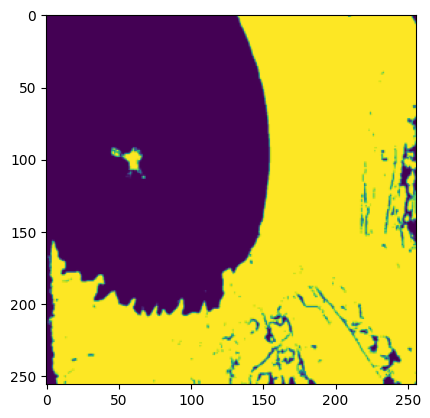

In [ ]:
# Plot output frame
plt.imshow(og_image)

tensor(1.0000, device='cuda:0', grad_fn=<MaxBackward1>)

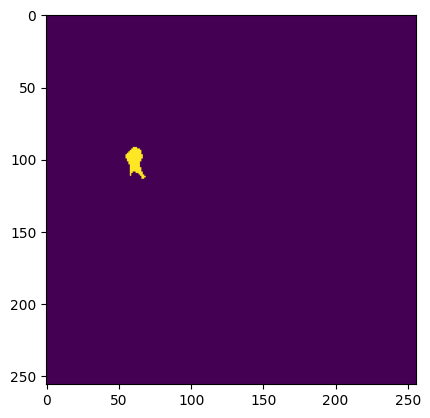

In [ ]:
prob_pred_frame = torch.sigmoid(pred_frame)
out = (prob_pred_frame > 0.5).to(torch.float32)
plt.imshow(out[0, 0, :, :].cpu().detach().numpy())
out.max()
prob_pred_frame.max()

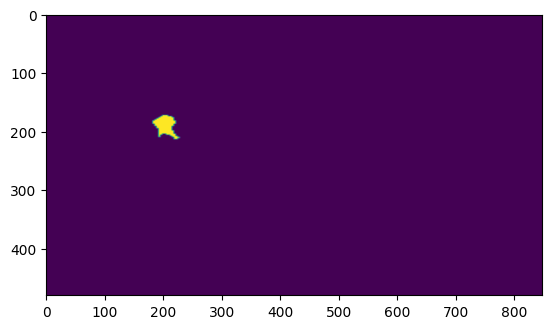

In [ ]:
h, w = 480, 848
resize_frame = transforms.Resize((h, w))
output_frame = resize_frame(out[0, 0, :, :].unsqueeze(0))
plt.imshow(output_frame[0, :, :].cpu().detach().numpy())

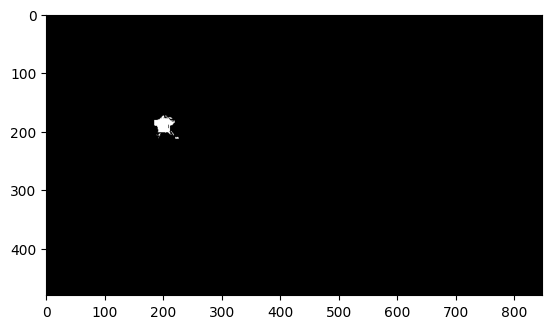

In [ ]:
# Actual gt
path_to_sequence = 'processed_flow/test3/targets'
idx = sequence_start + (seq_length - 1)
img = io.imread(os.path.join(path_to_sequence, f'frame{idx:05d}.png'))
plt.imshow(img)

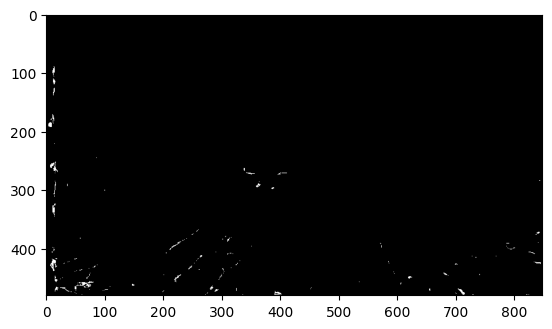

In [ ]:
# Actual gt
path_to_sequence = 'processed_flow/test1/inputs'
sequence_start = 1500
idx = sequence_start + (seq_length - 1)
img = io.imread(os.path.join(path_to_sequence, f'frame{idx:05d}.png'))
plt.imshow(img)

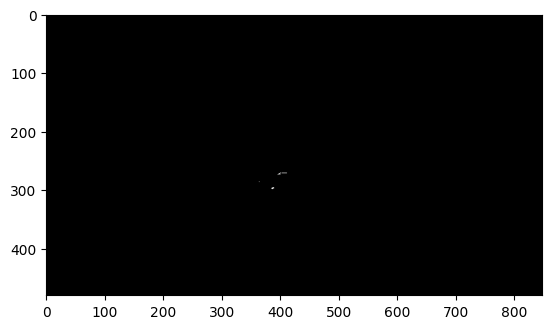

In [ ]:
# Actual gt
path_to_sequence = 'processed_flow/test1/targets'
idx = sequence_start + (seq_length - 1)
img = io.imread(os.path.join(path_to_sequence, f'frame{idx:05d}.png'))
plt.imshow(img)

100%|██████████| 7/7 [00:00<00:00, 63.48it/s]


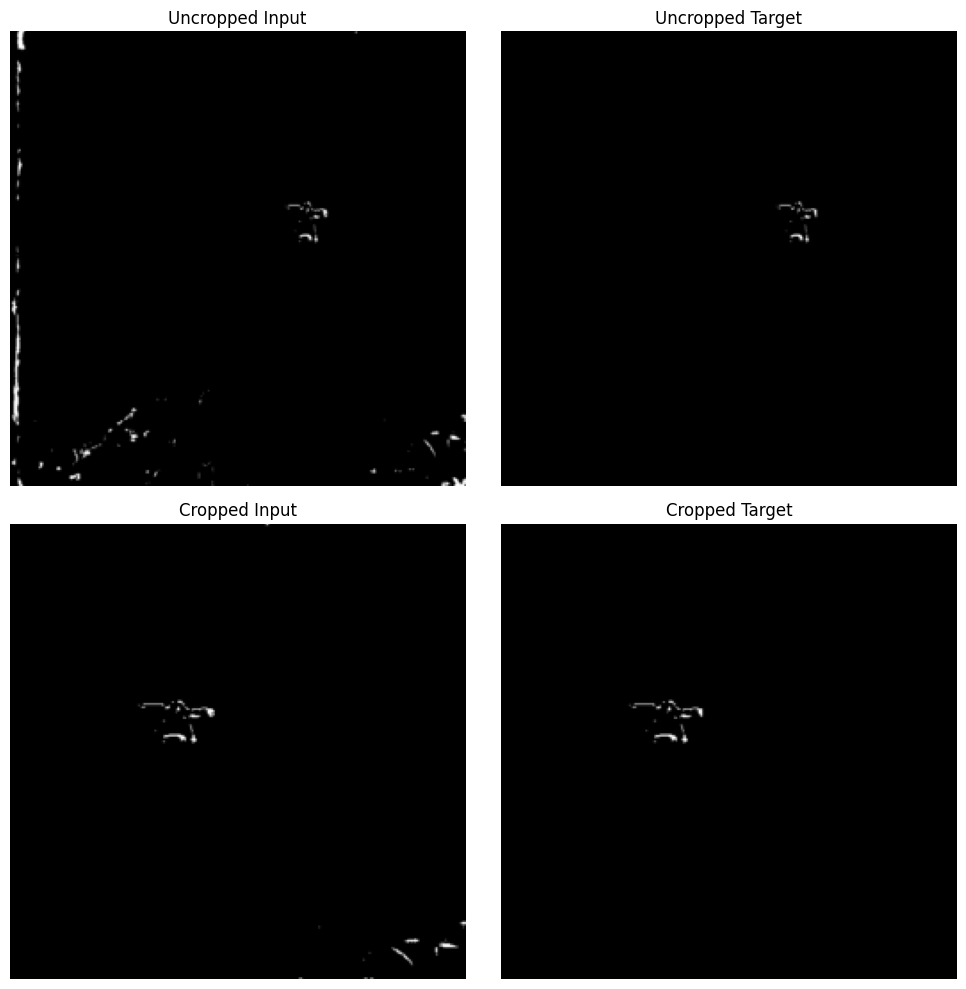

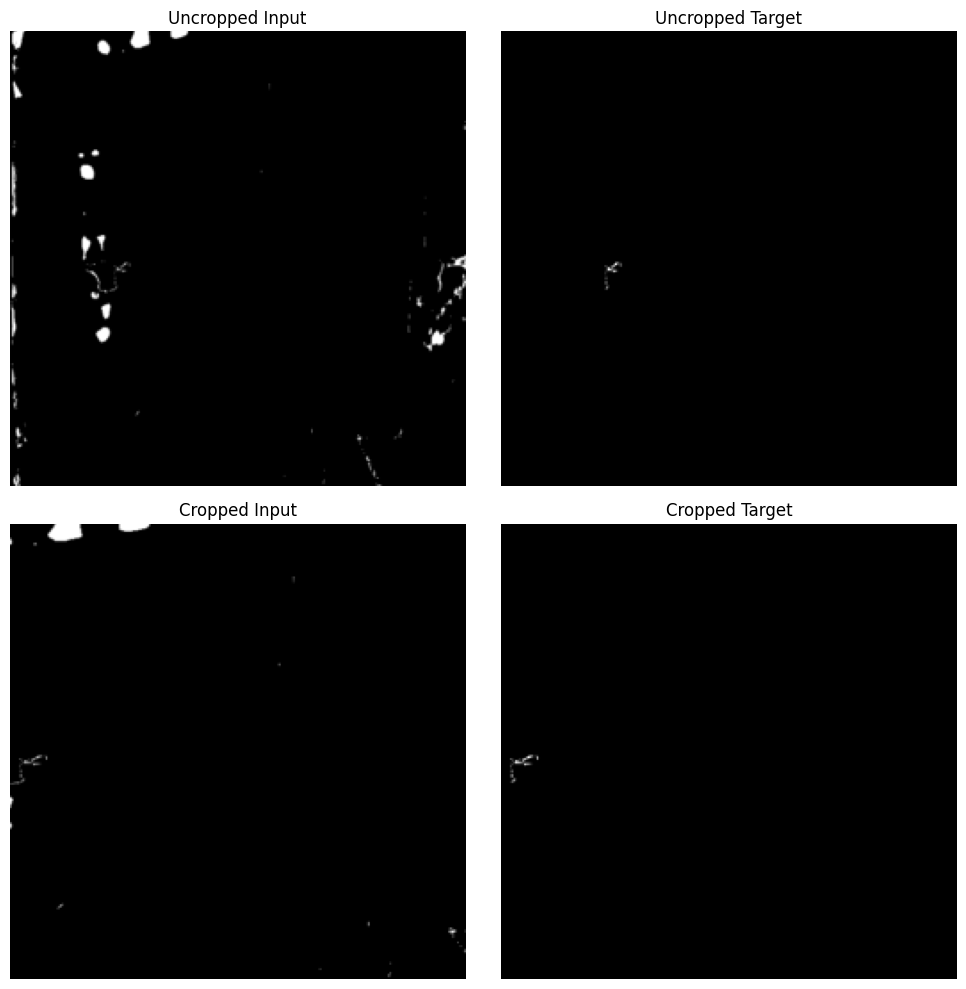

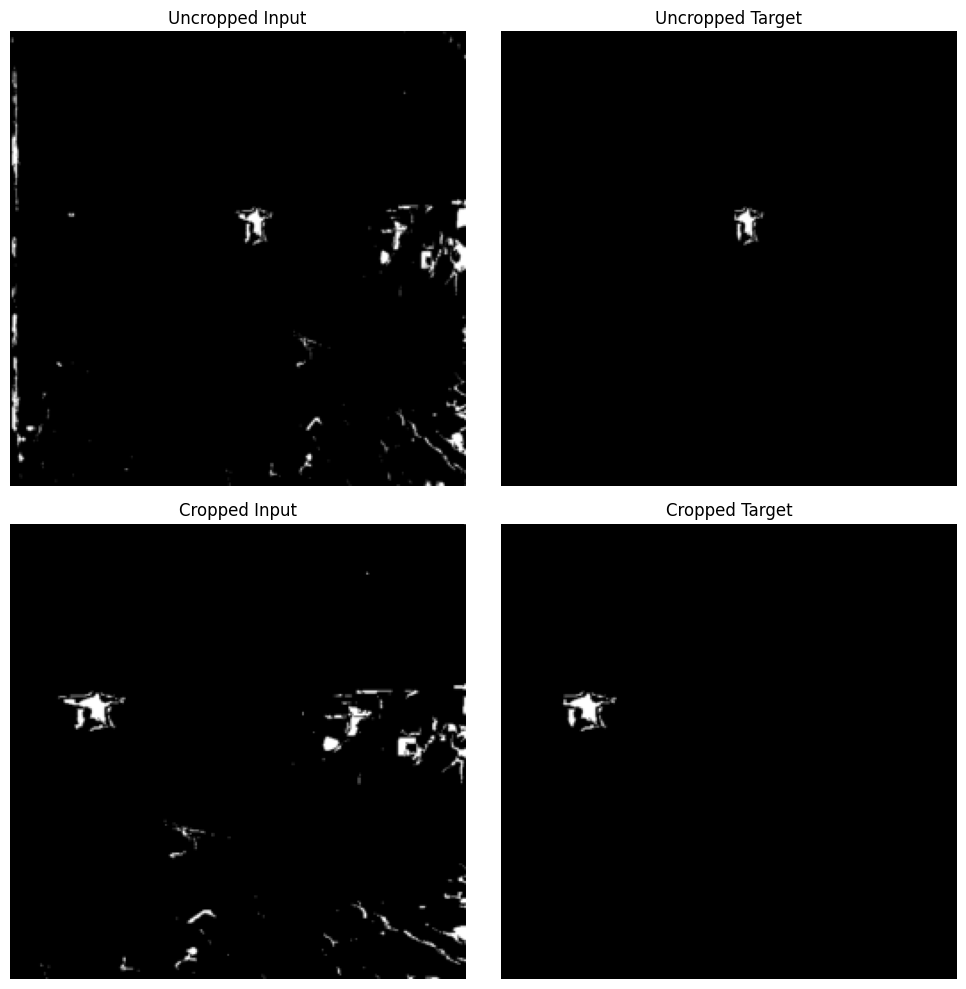

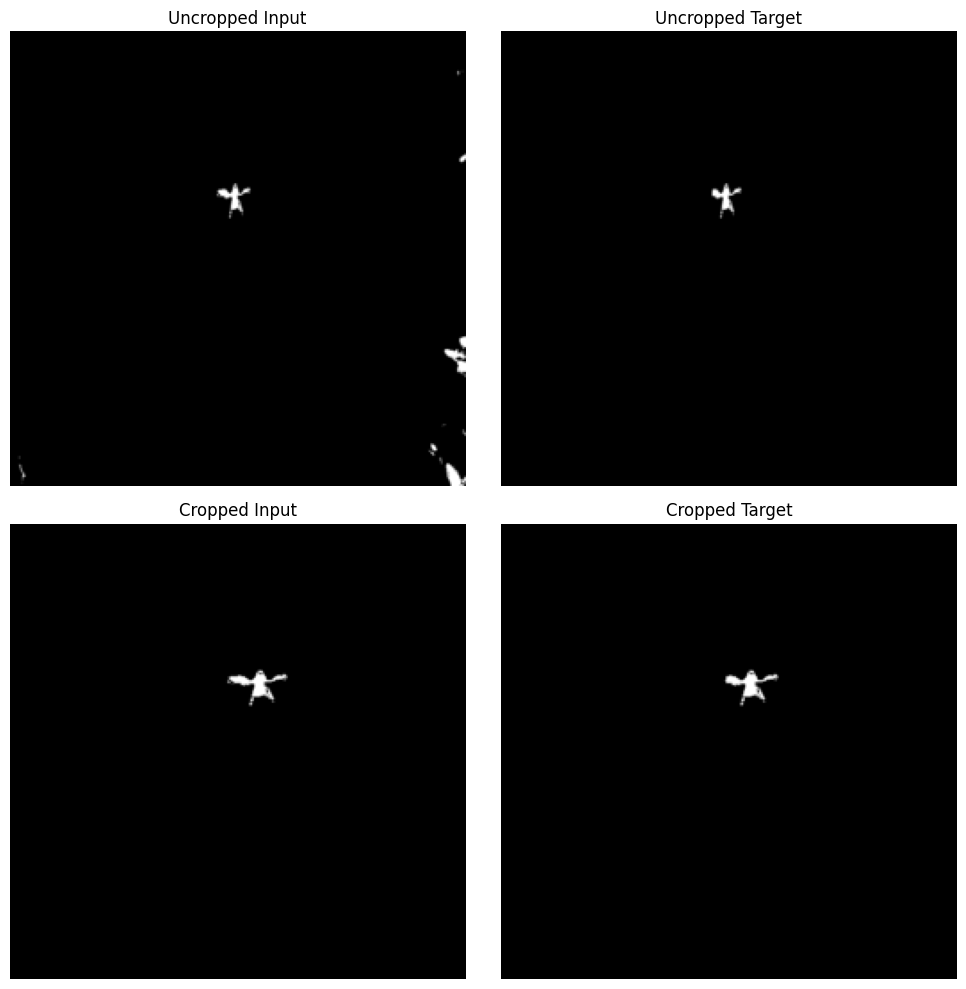

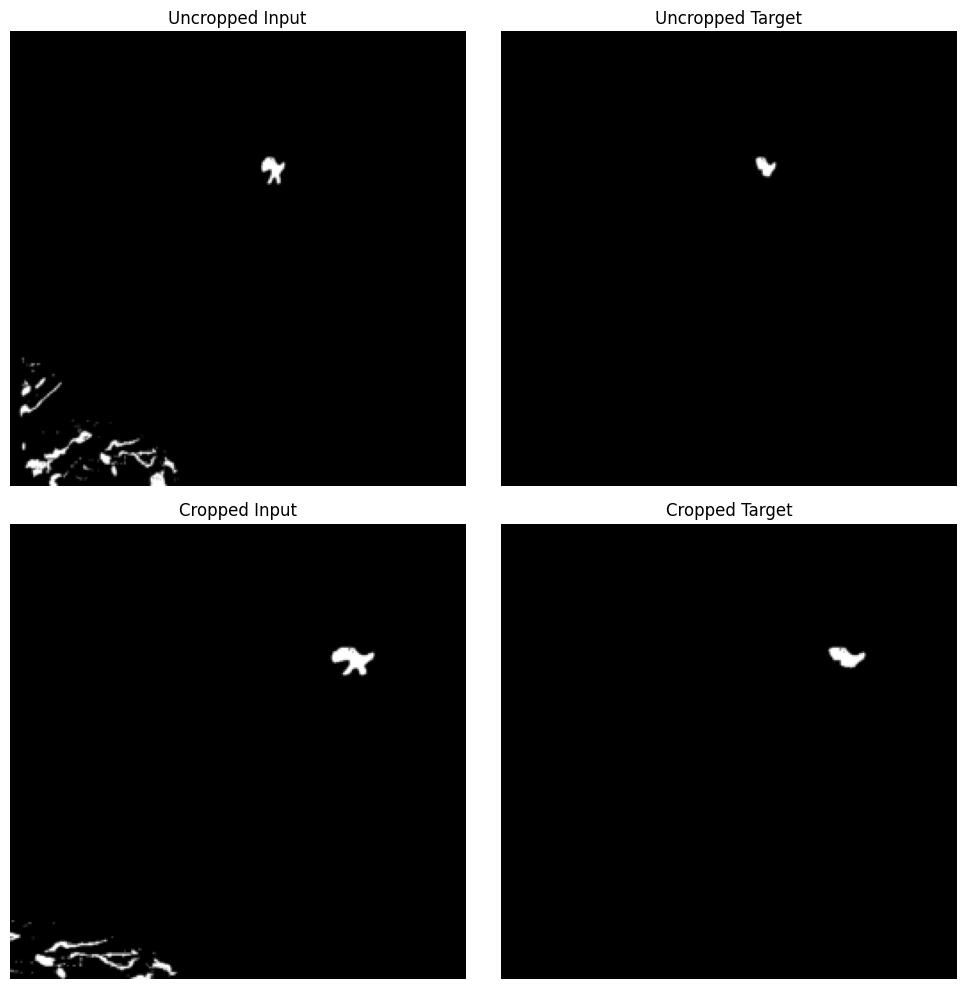

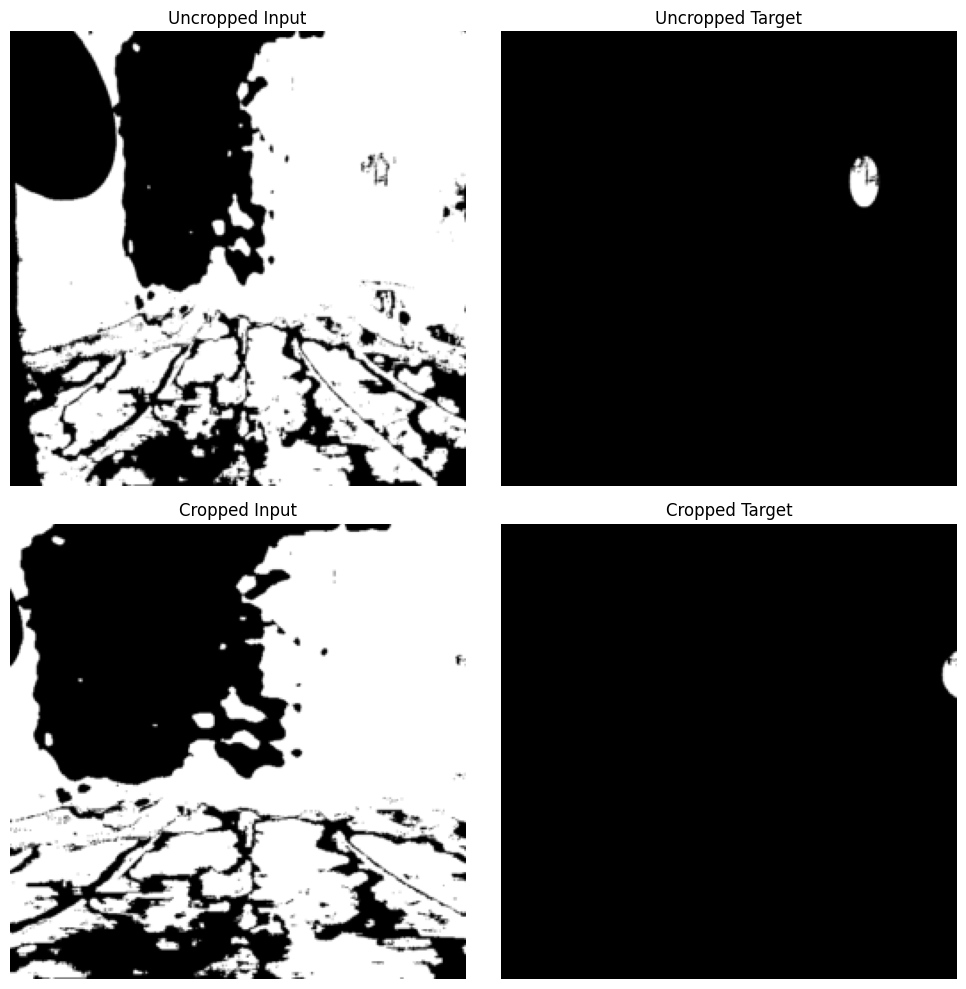

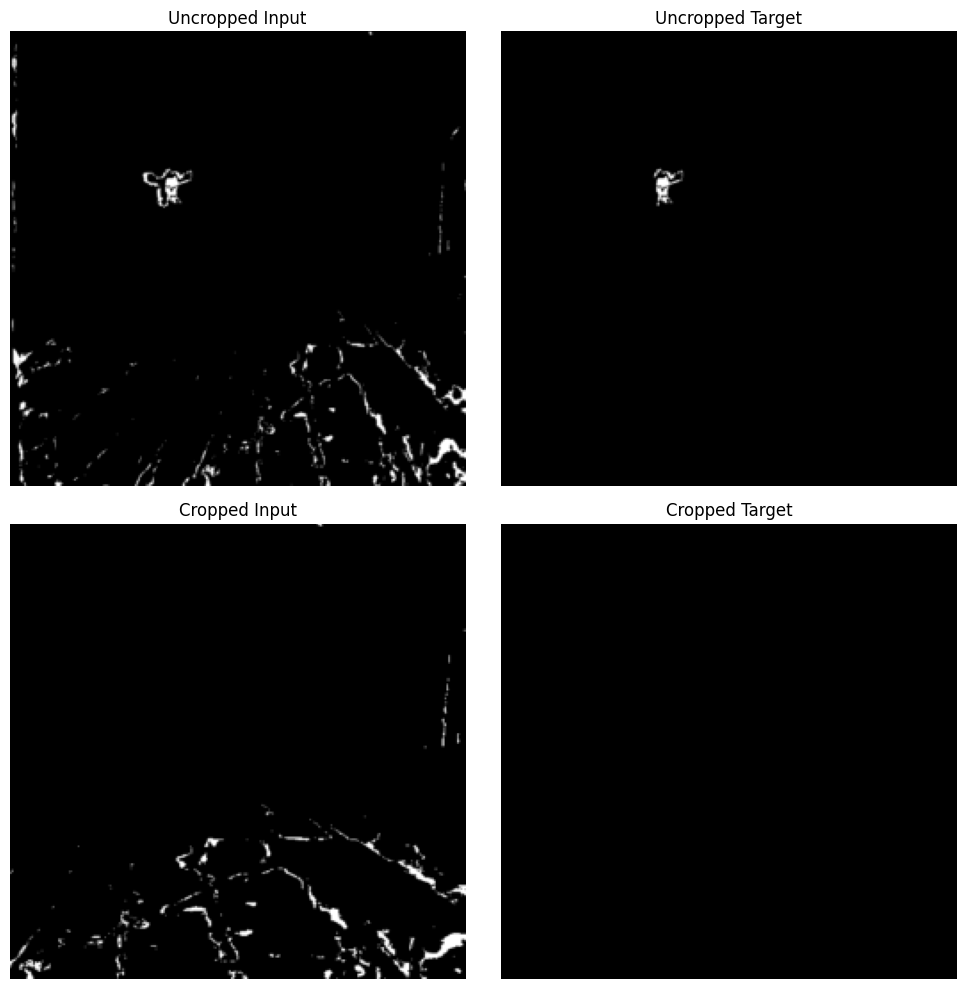

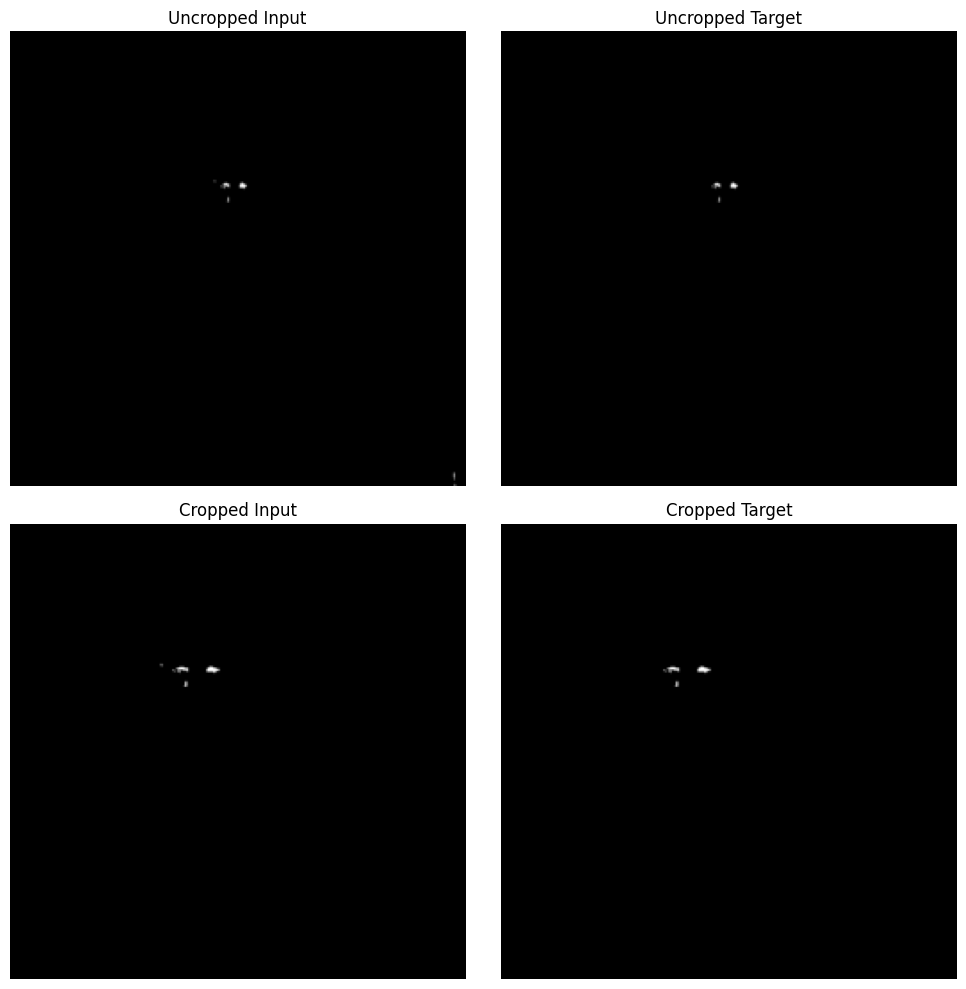

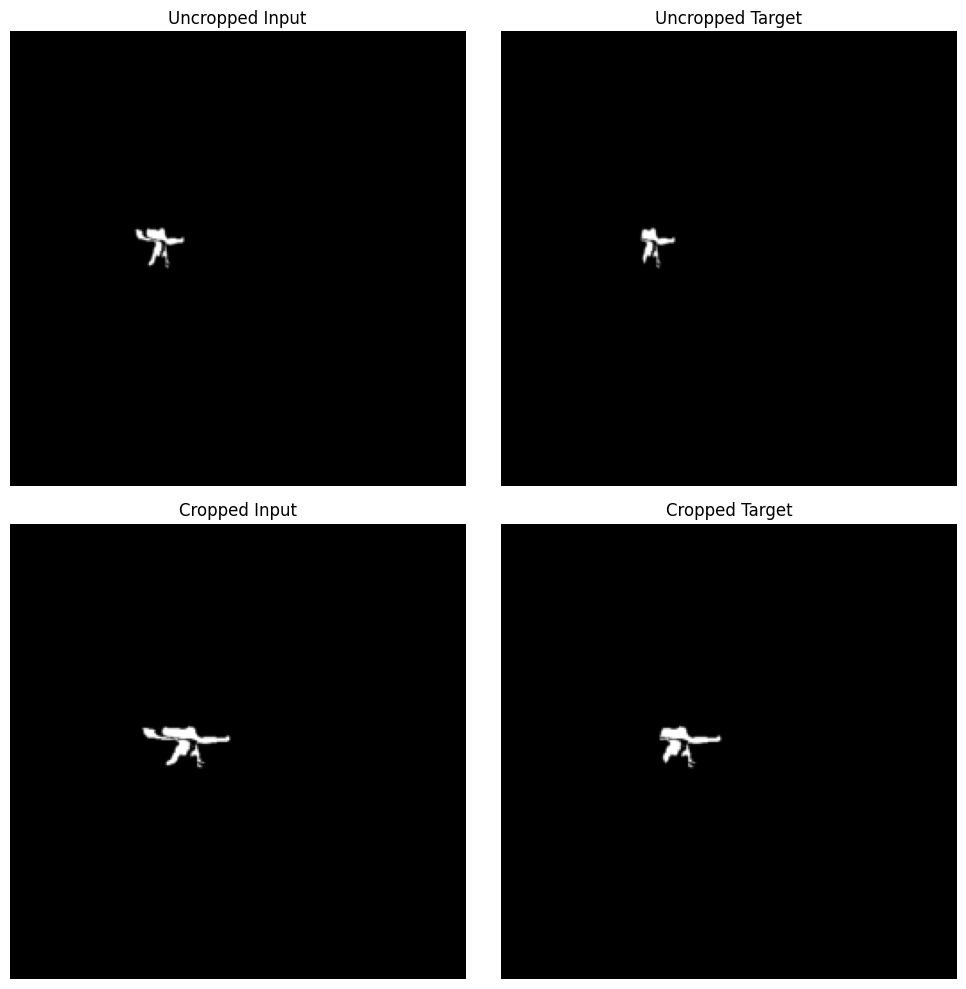

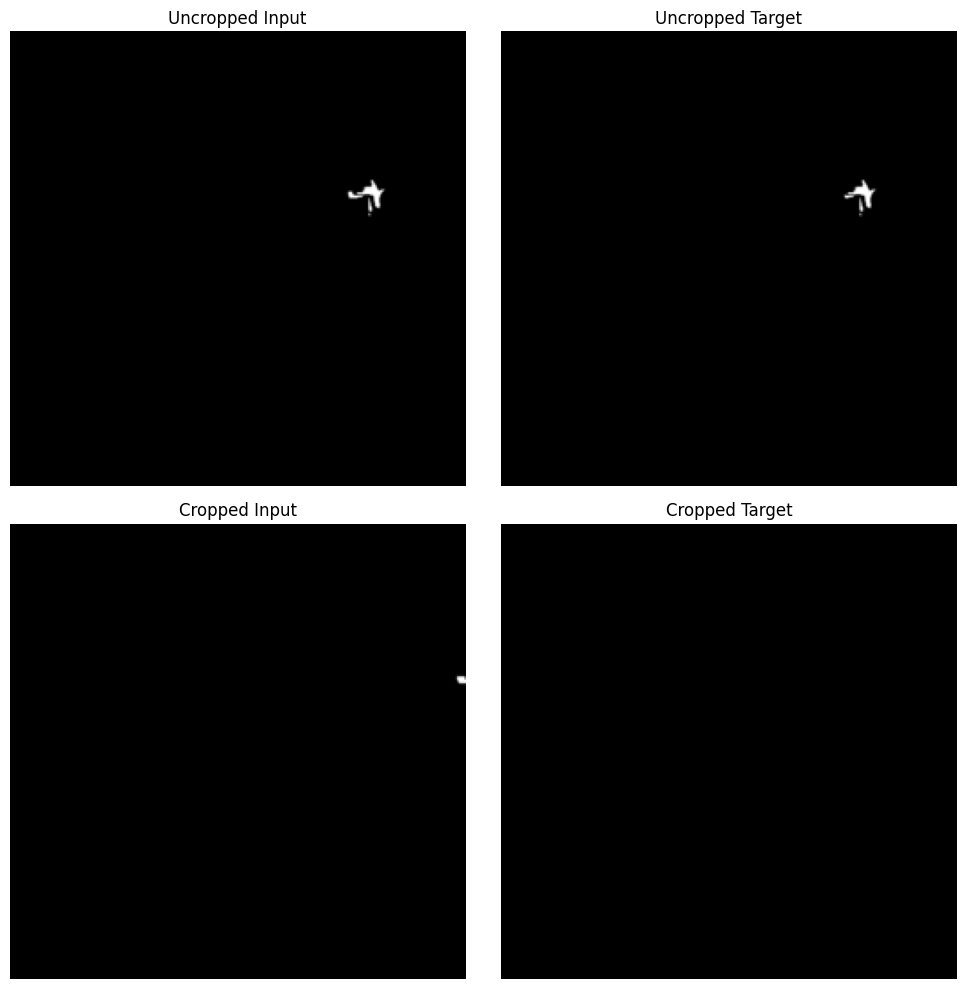

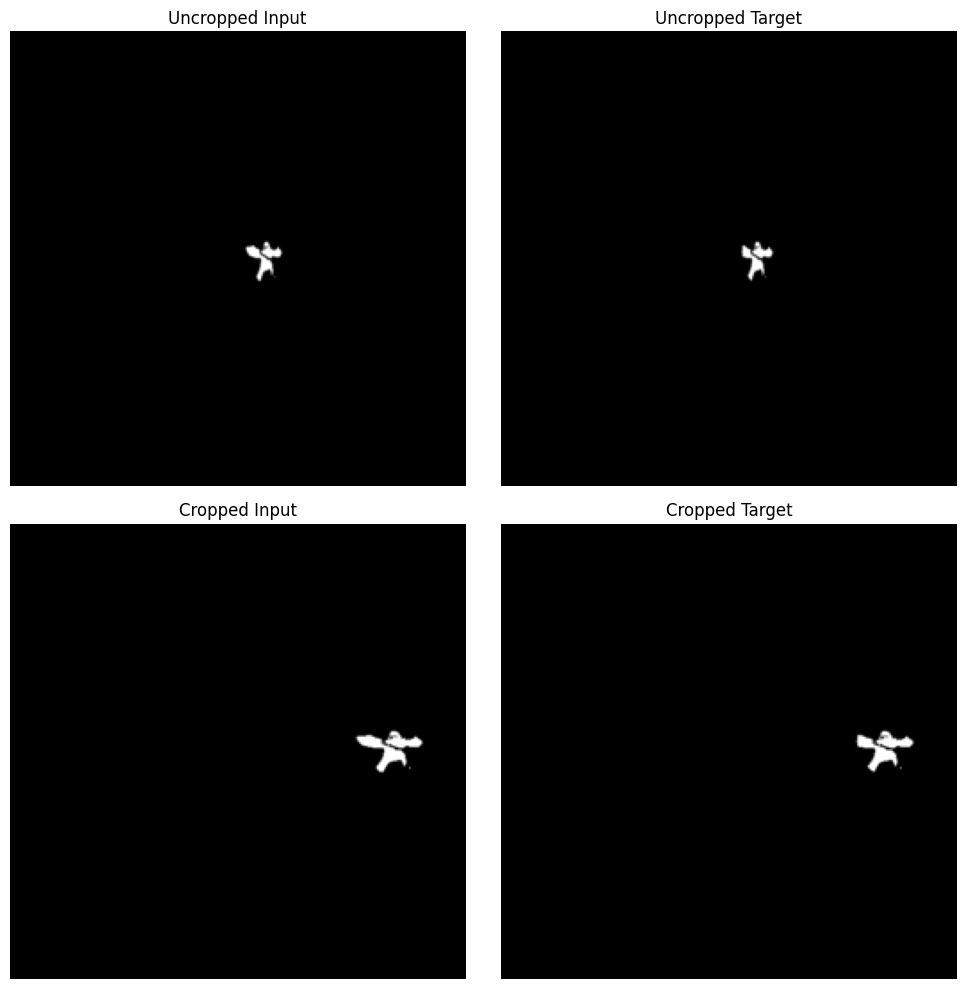

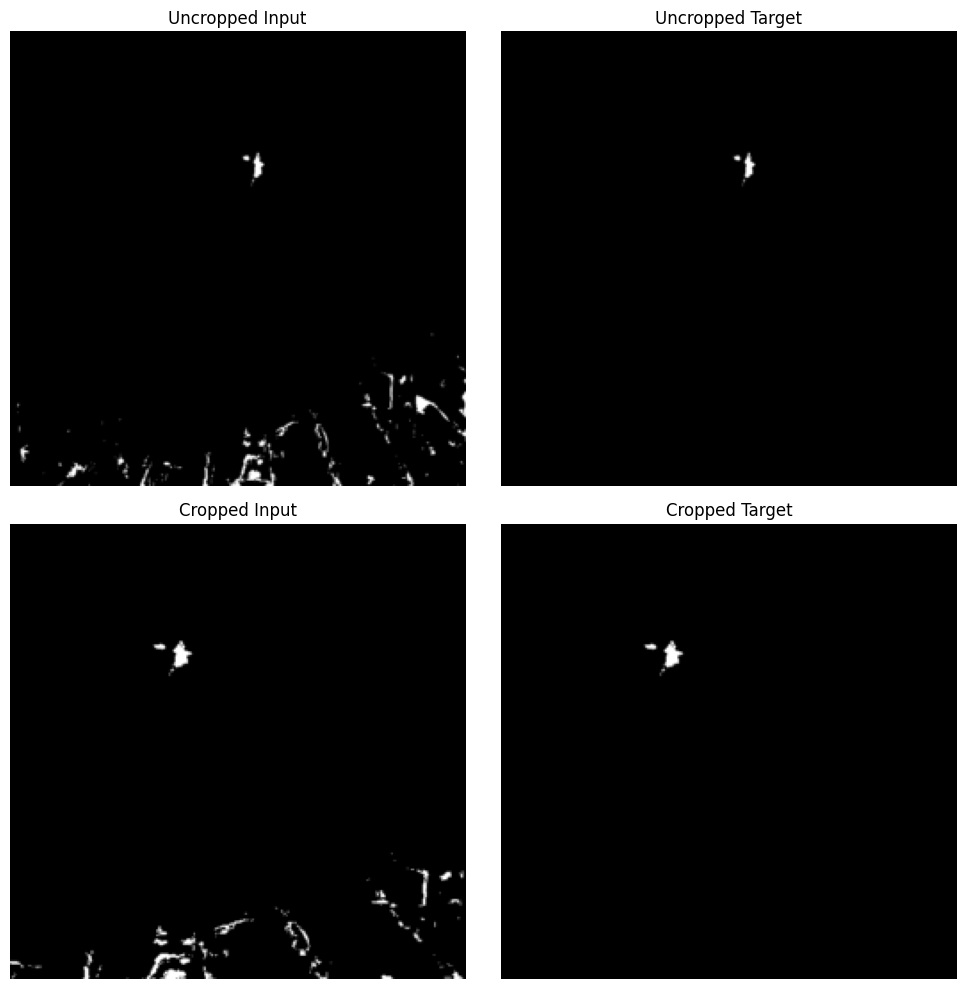

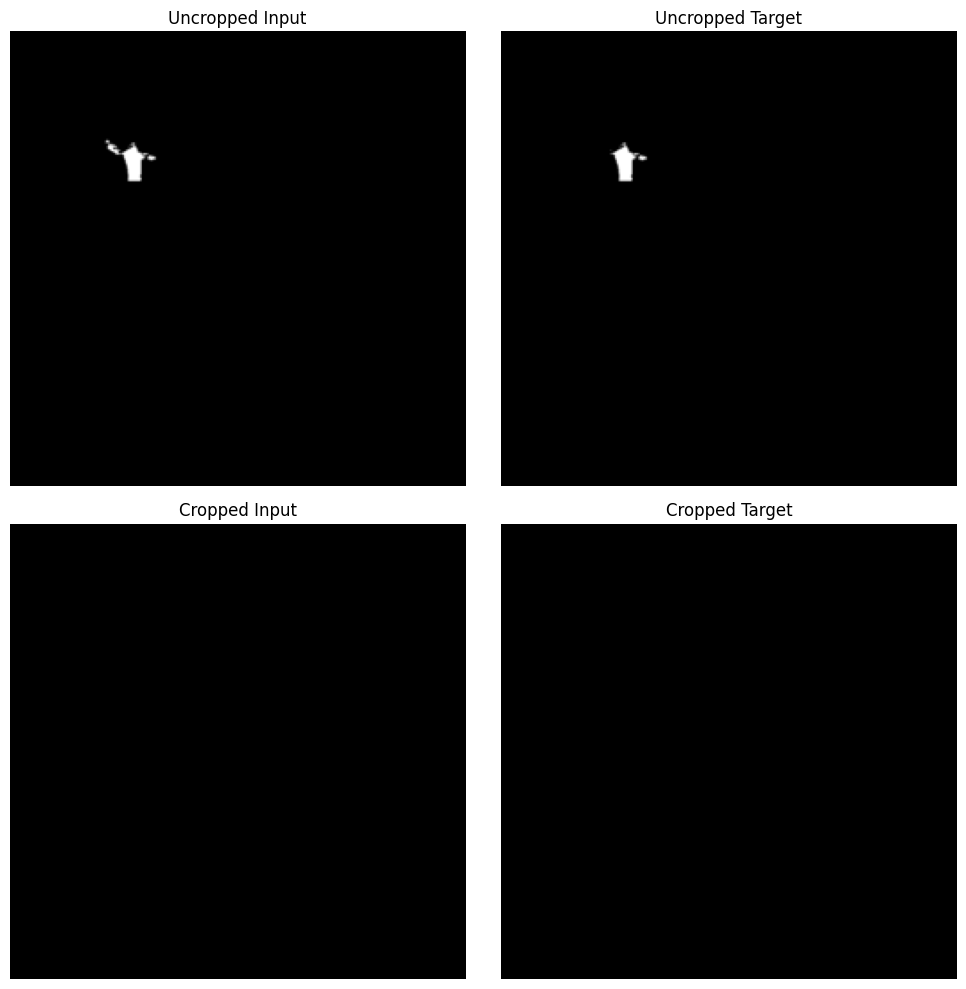

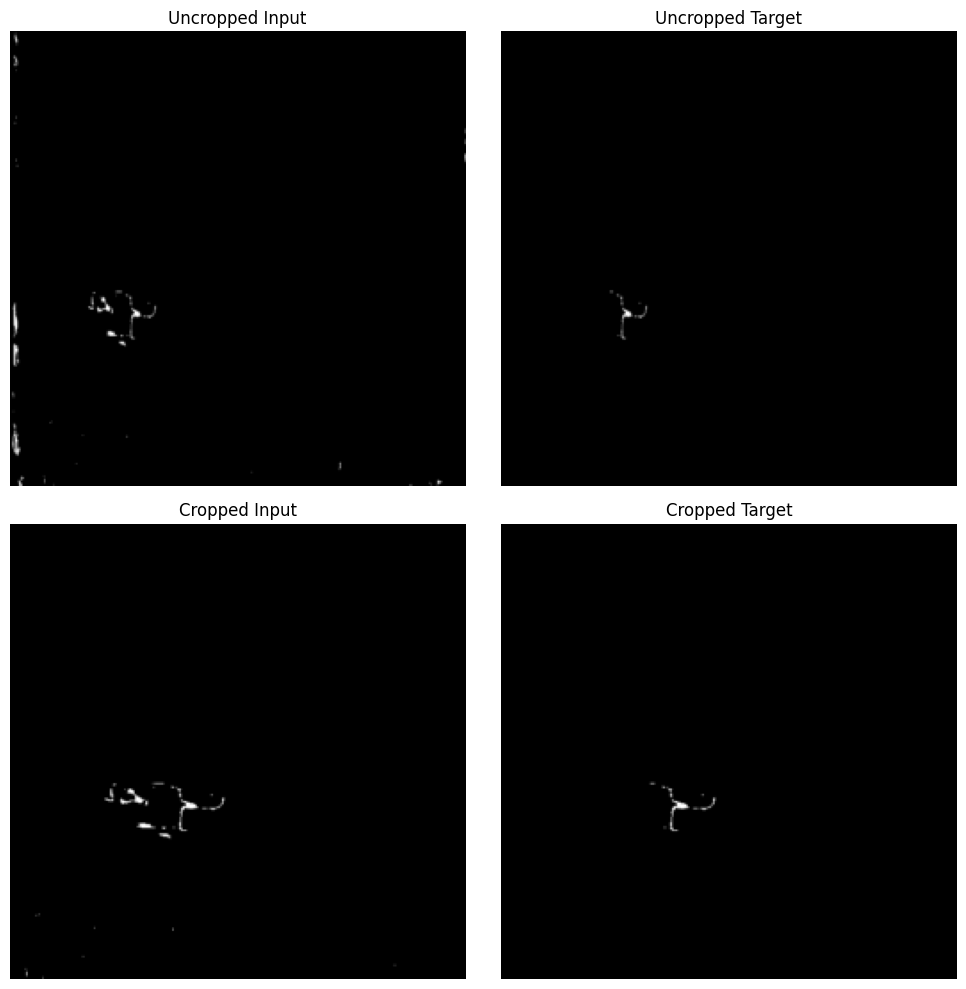

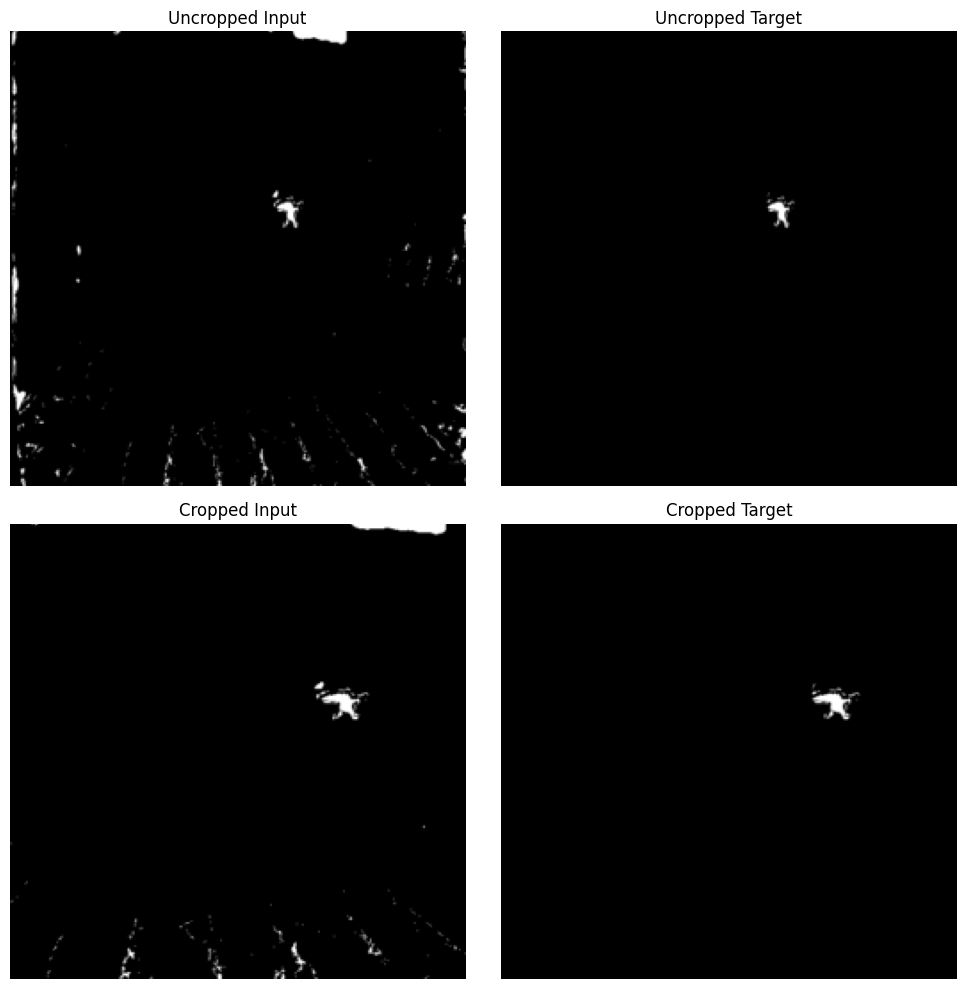

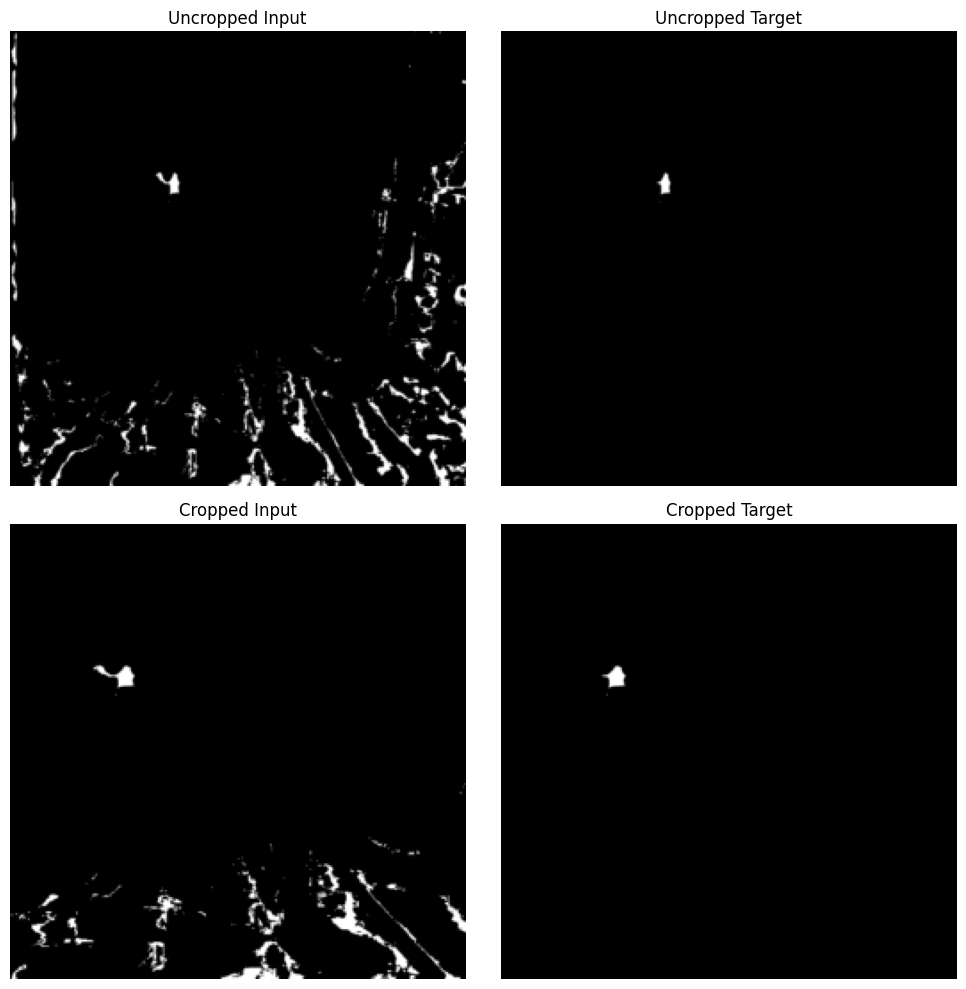

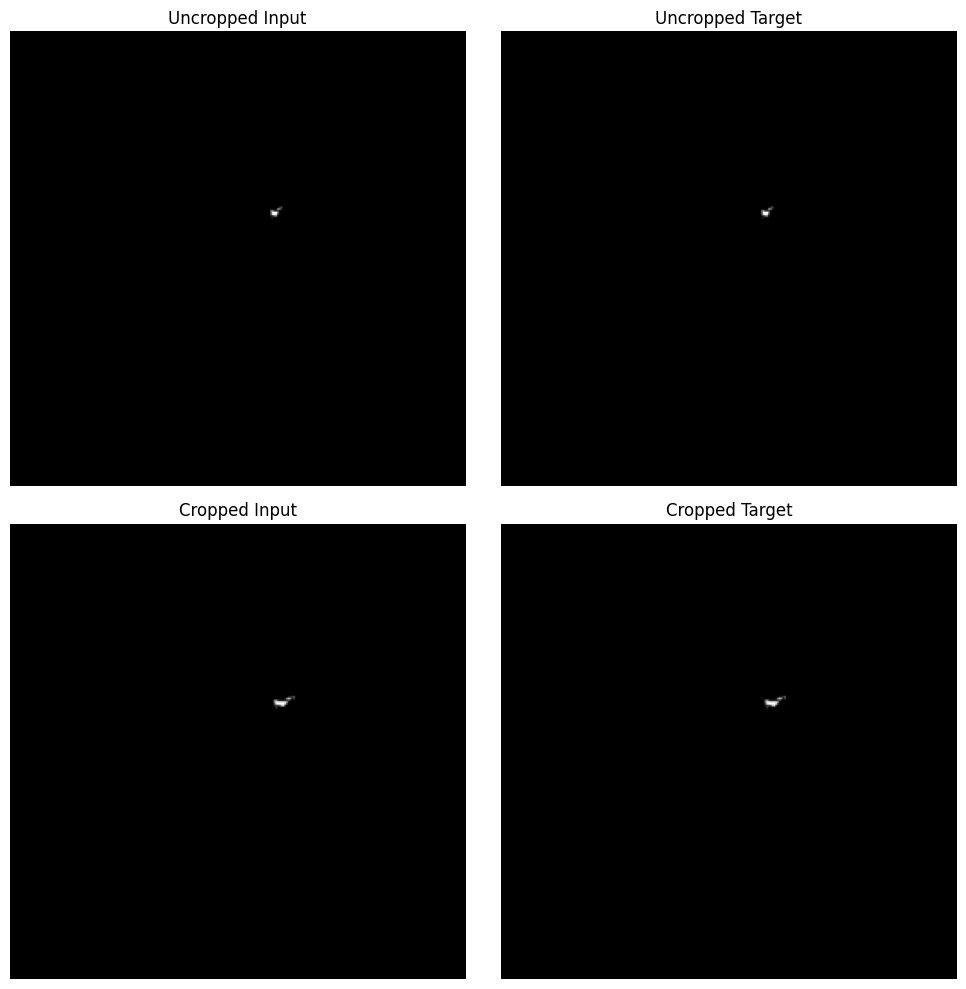

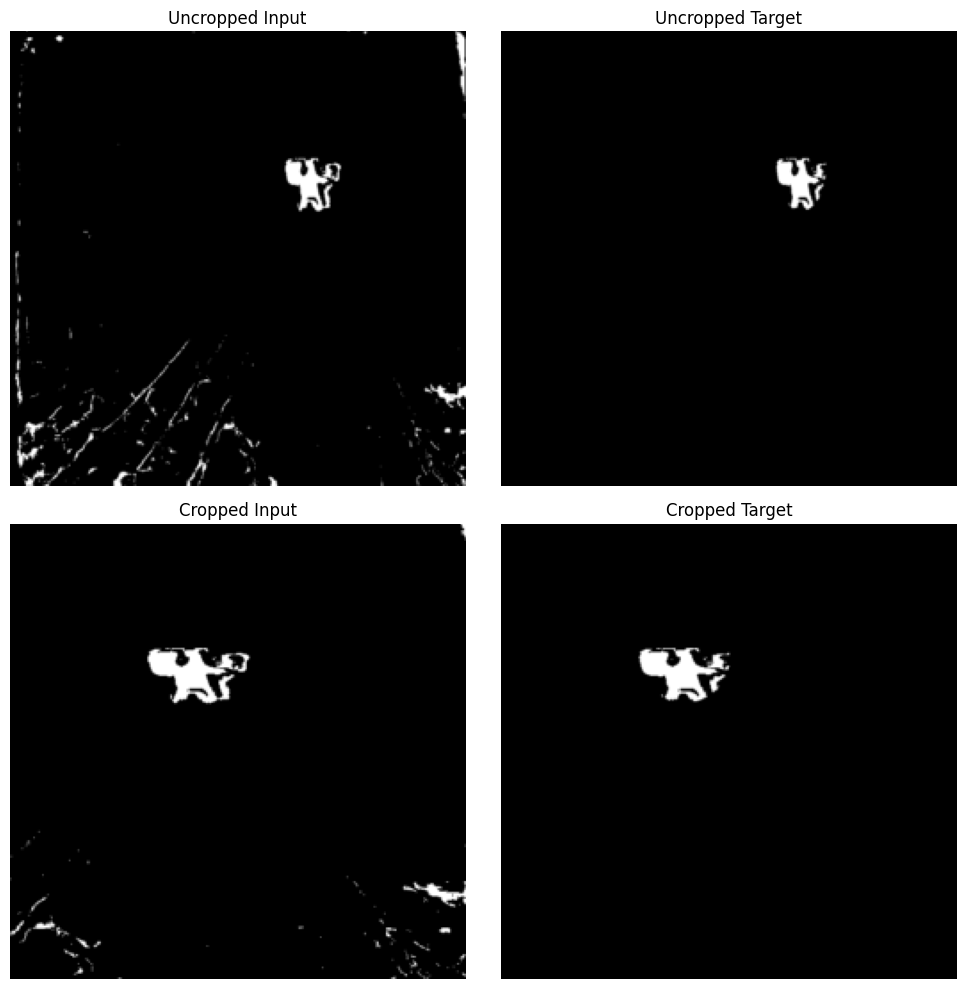

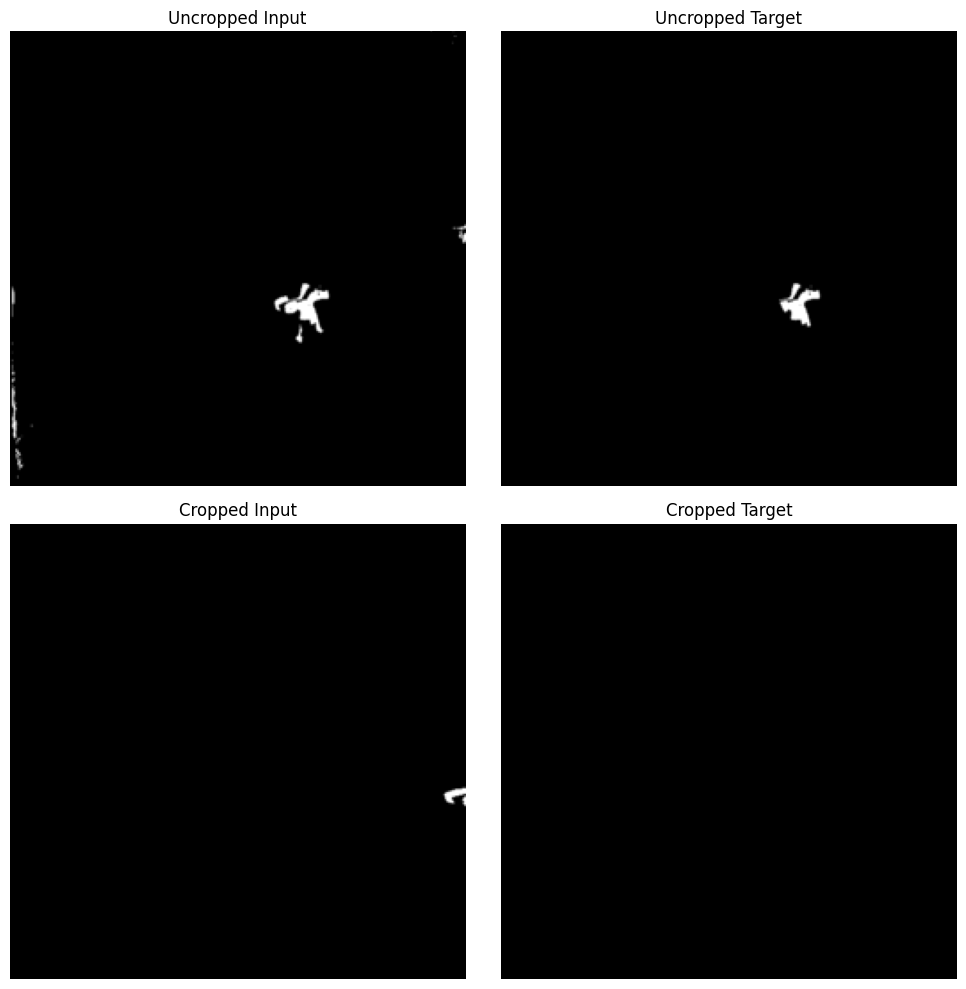

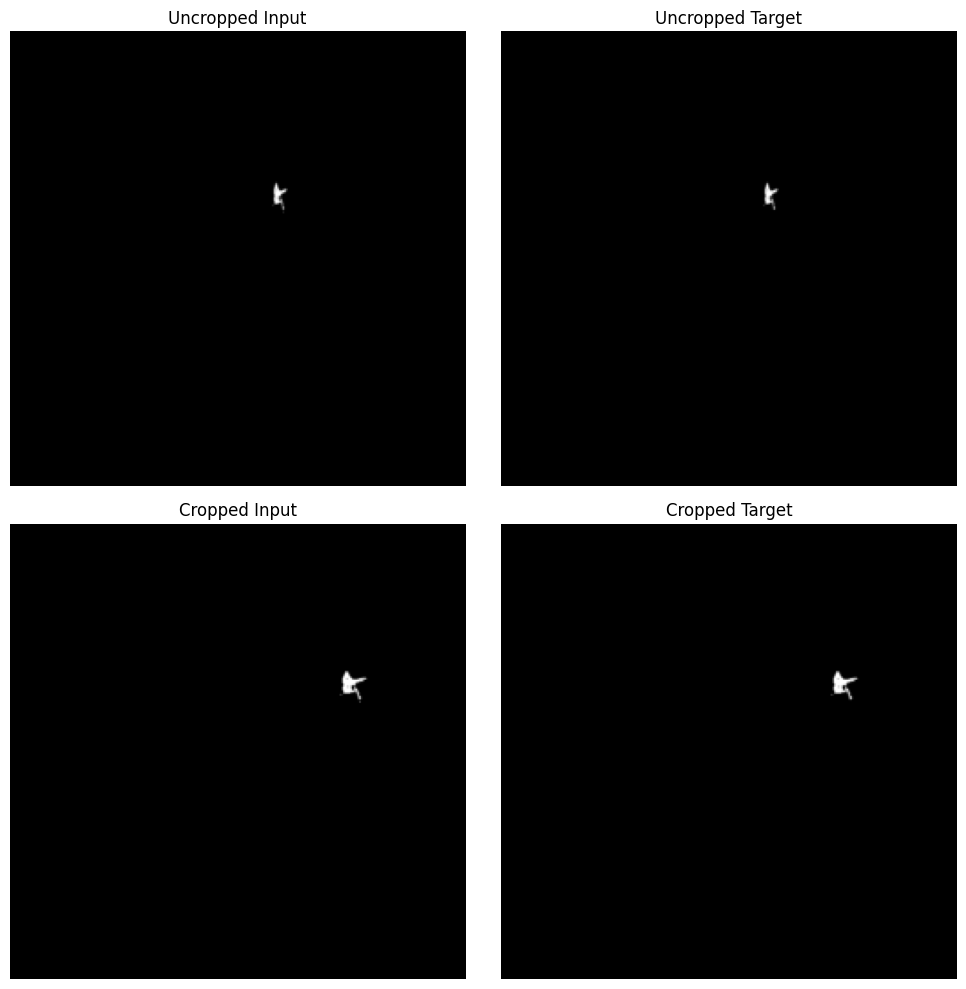

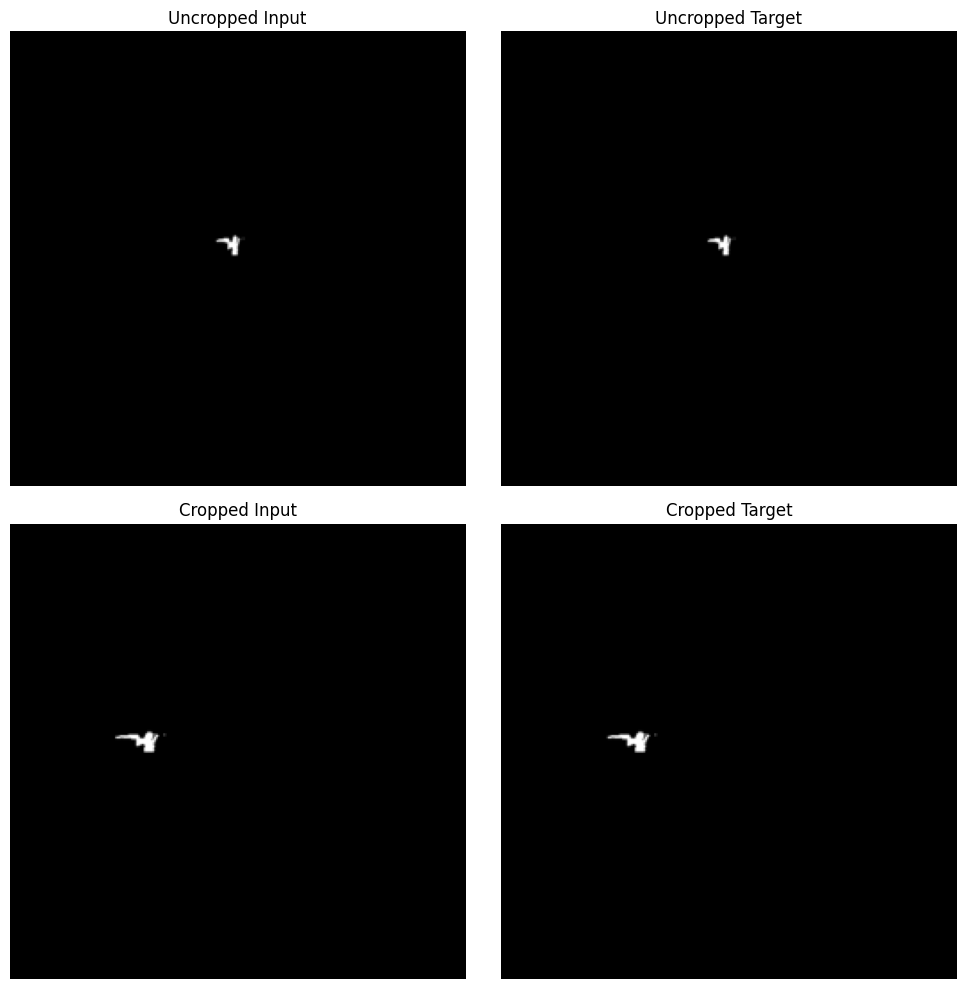

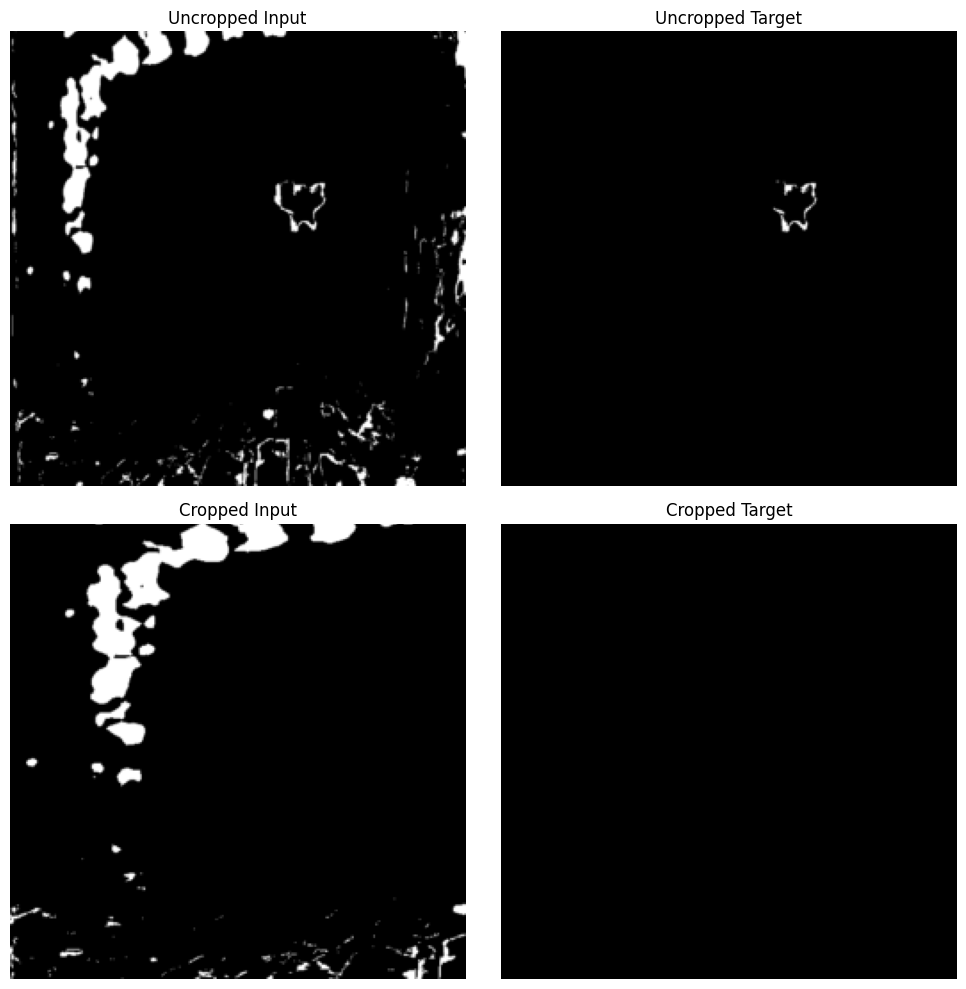

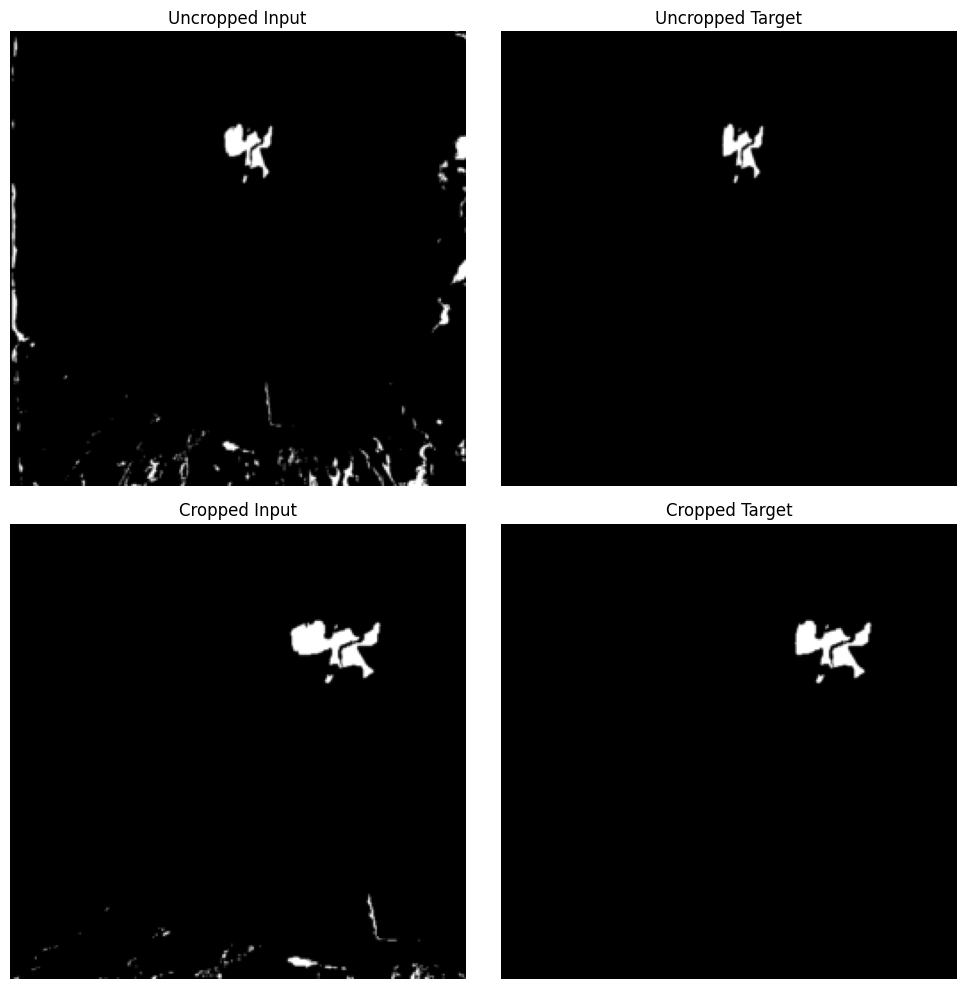

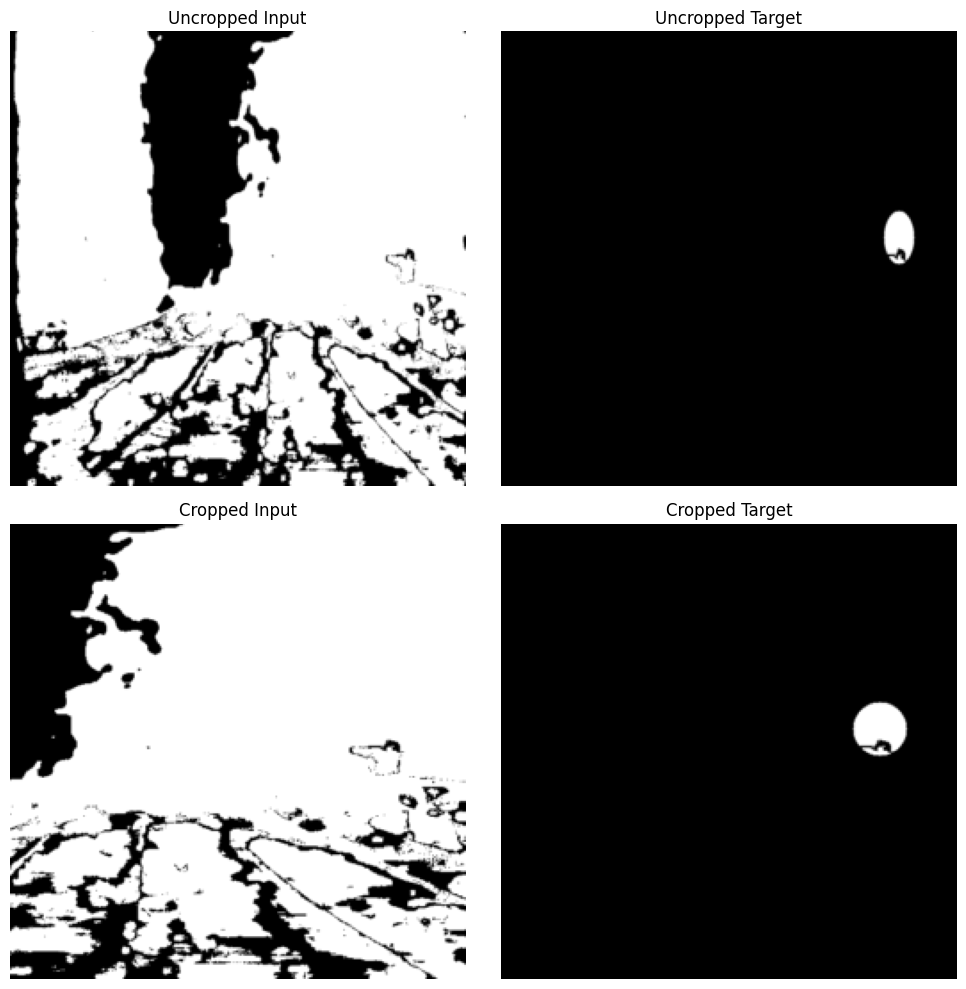

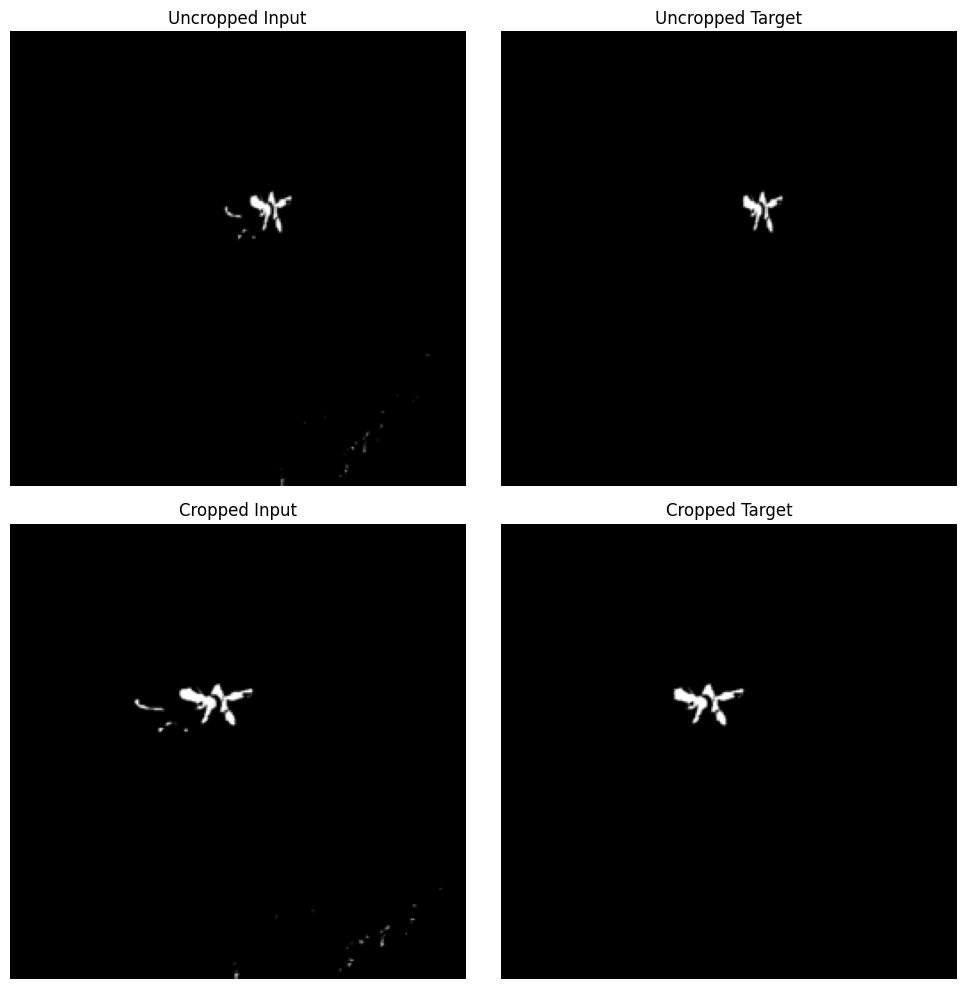

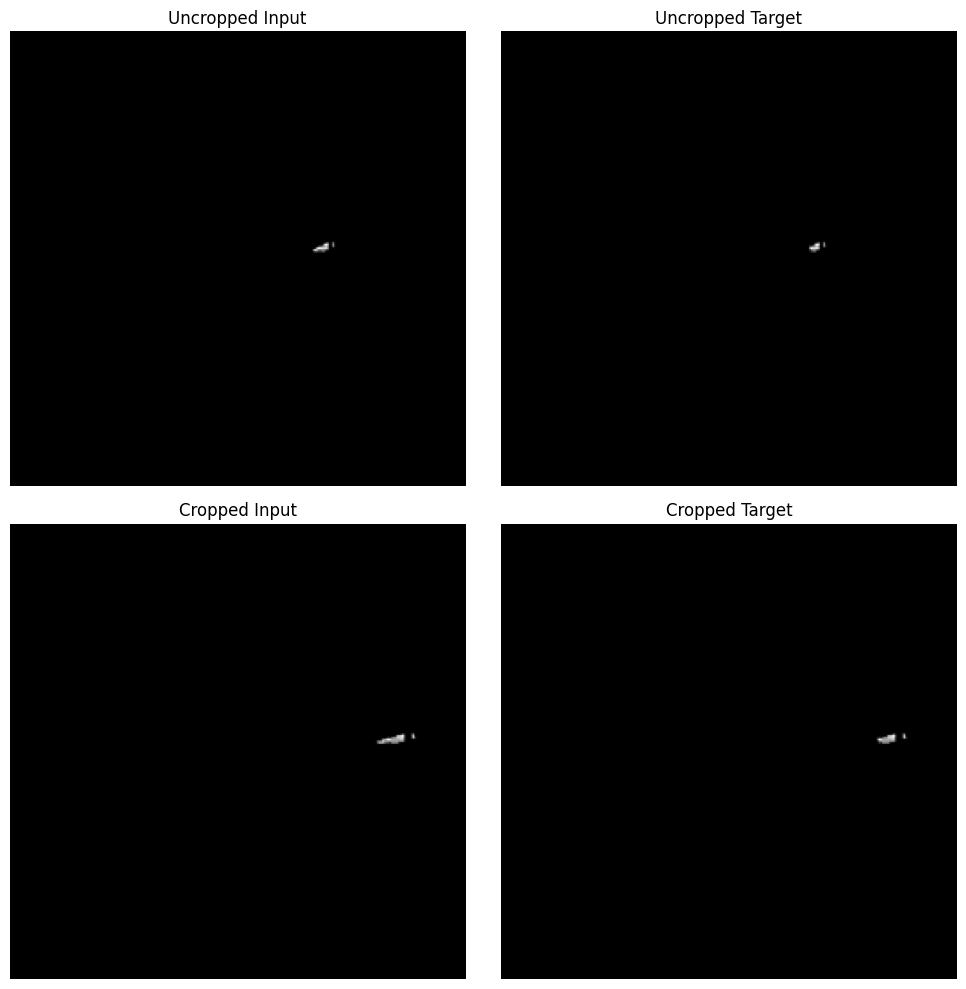

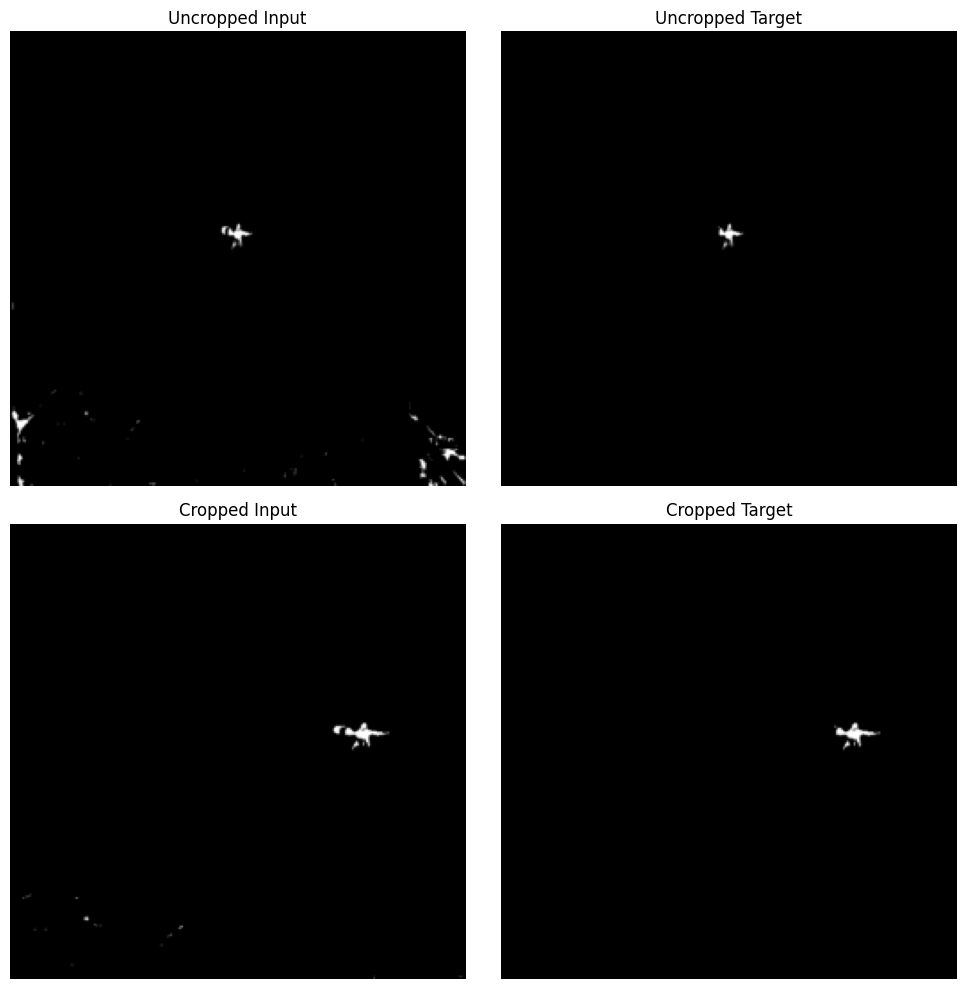

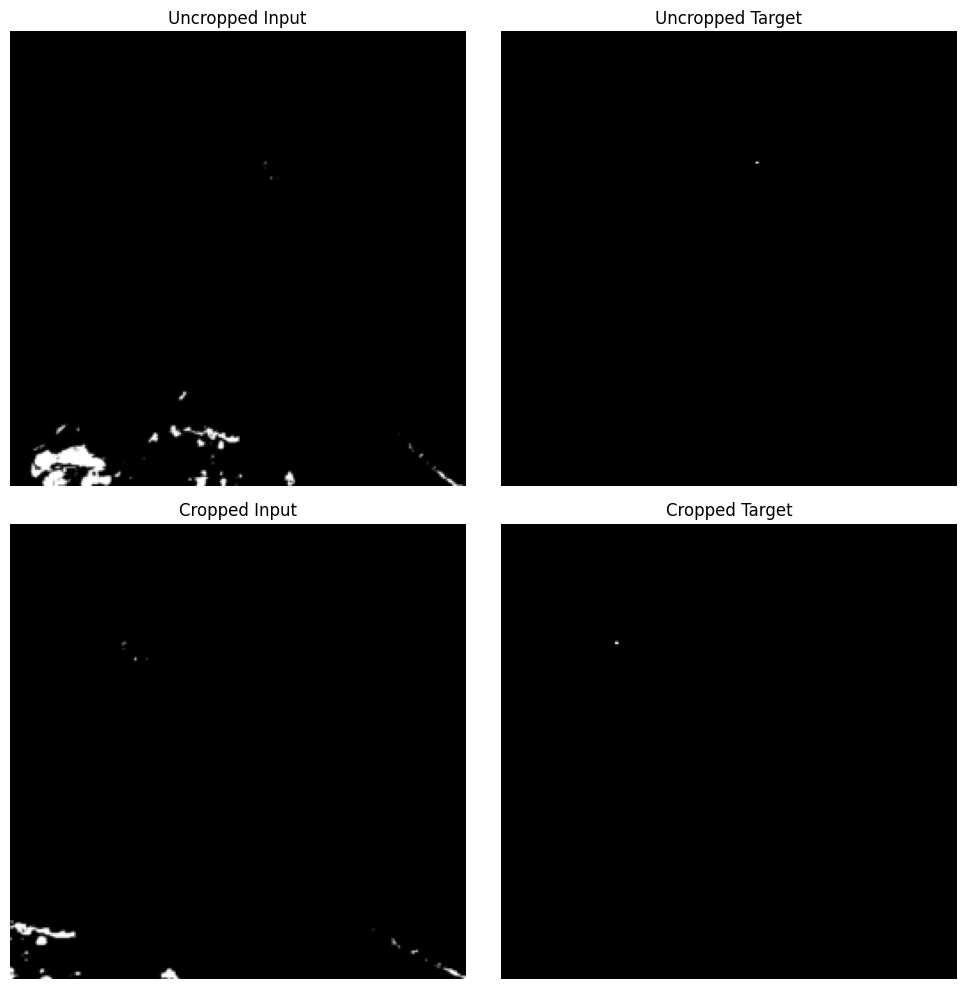

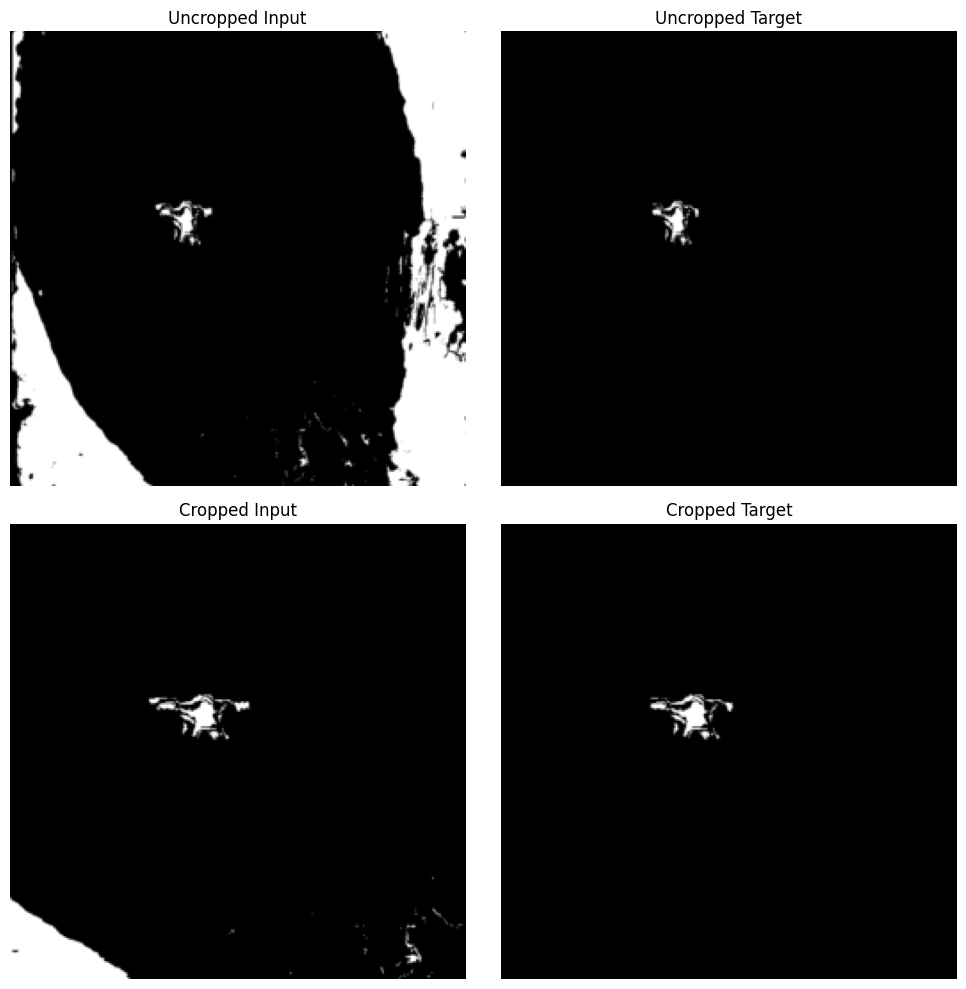

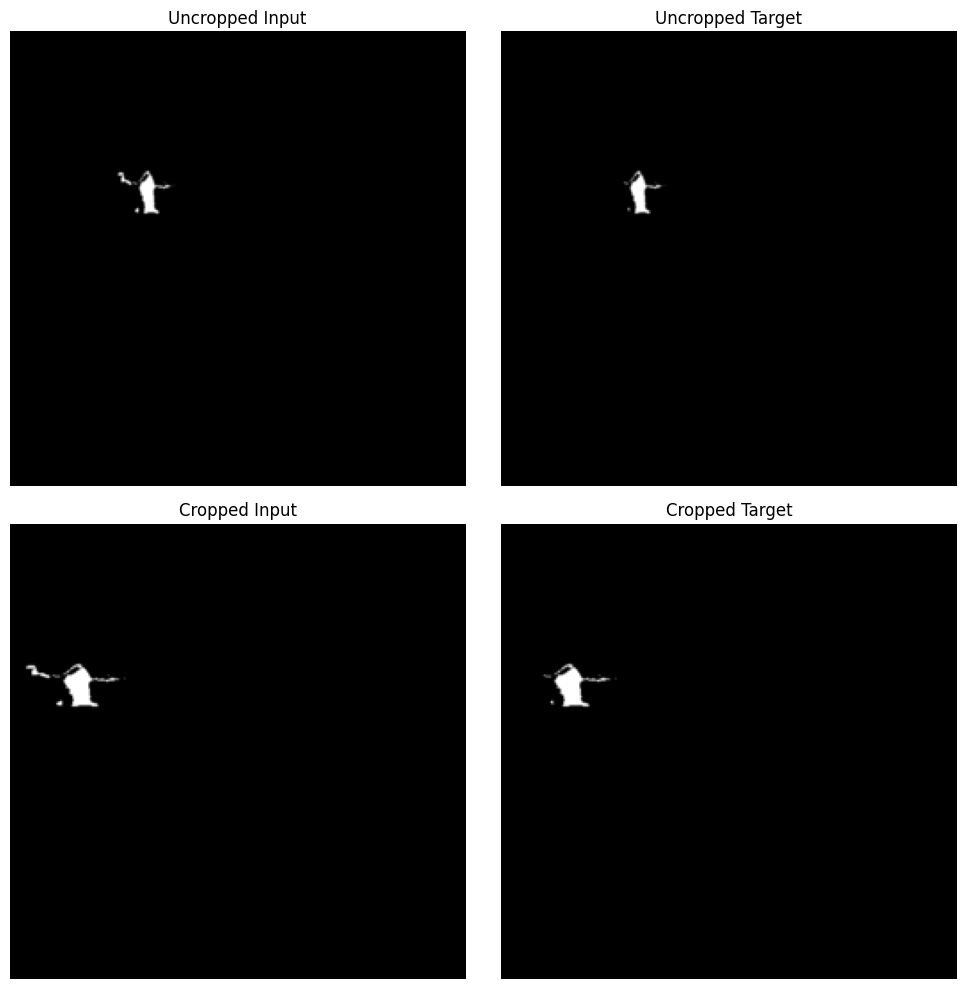

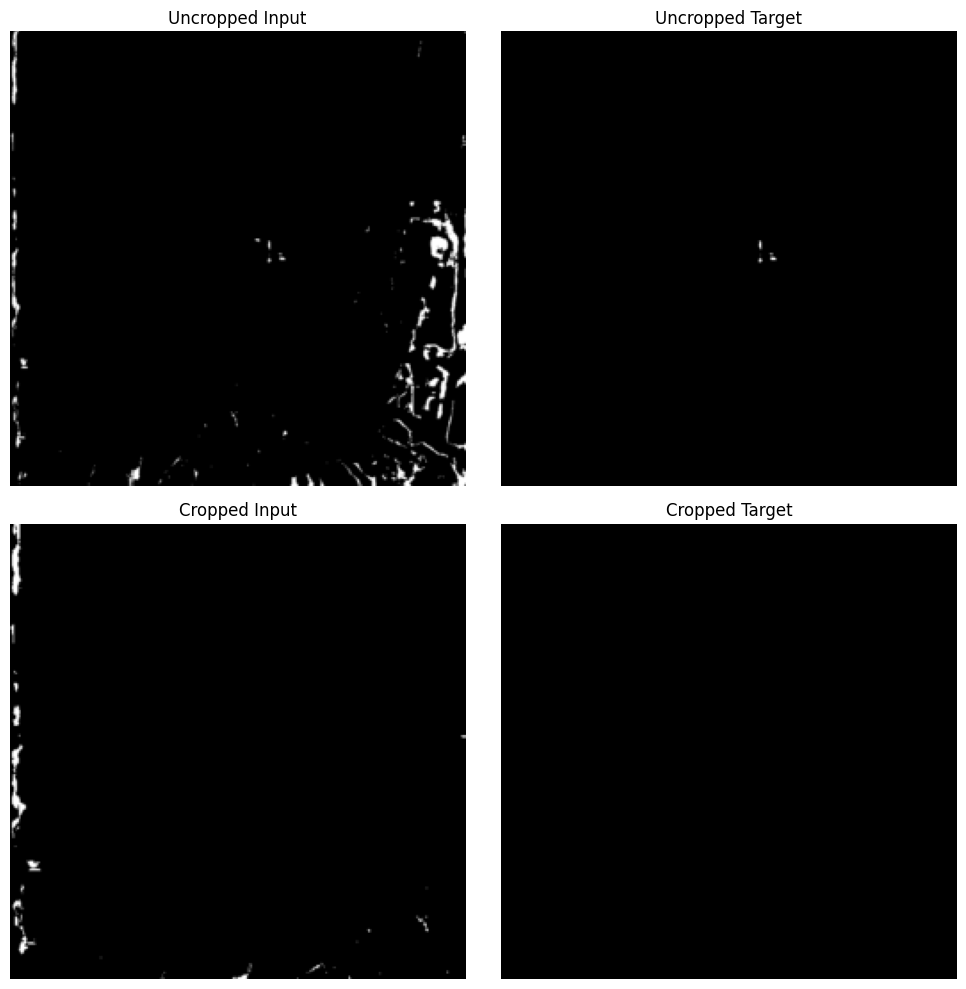

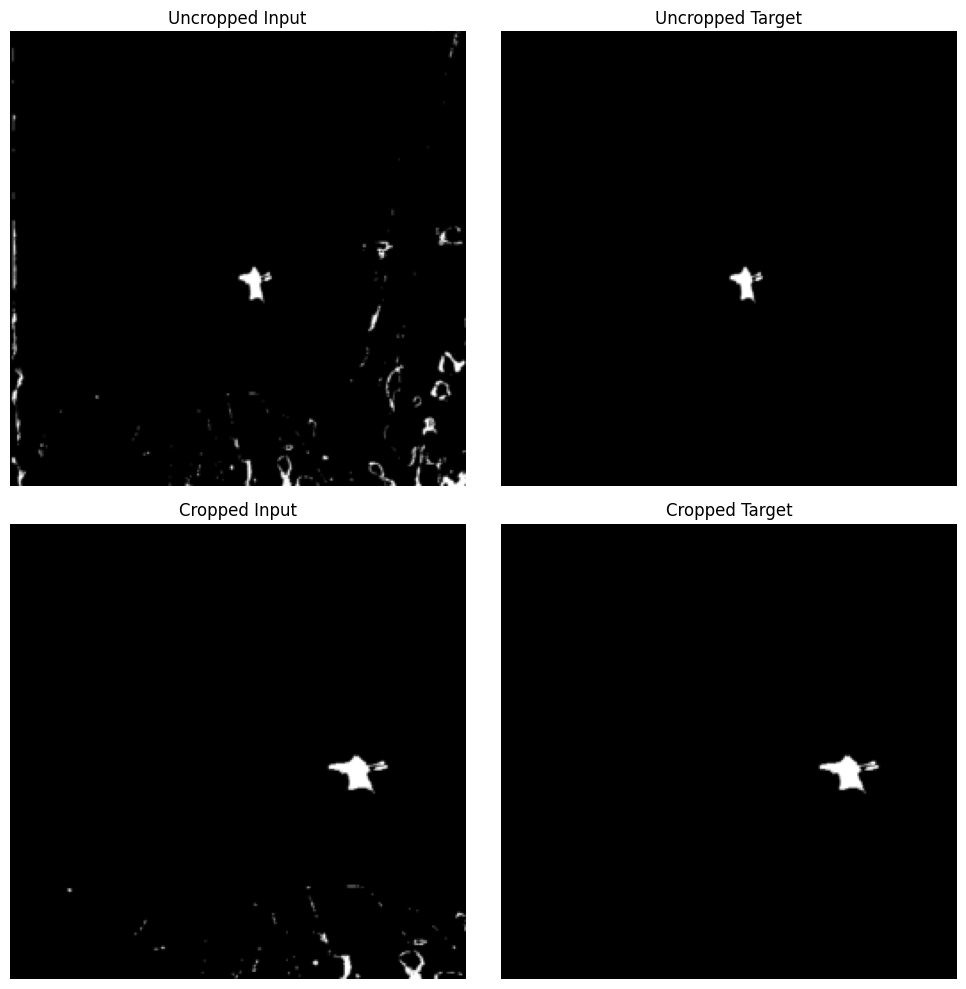

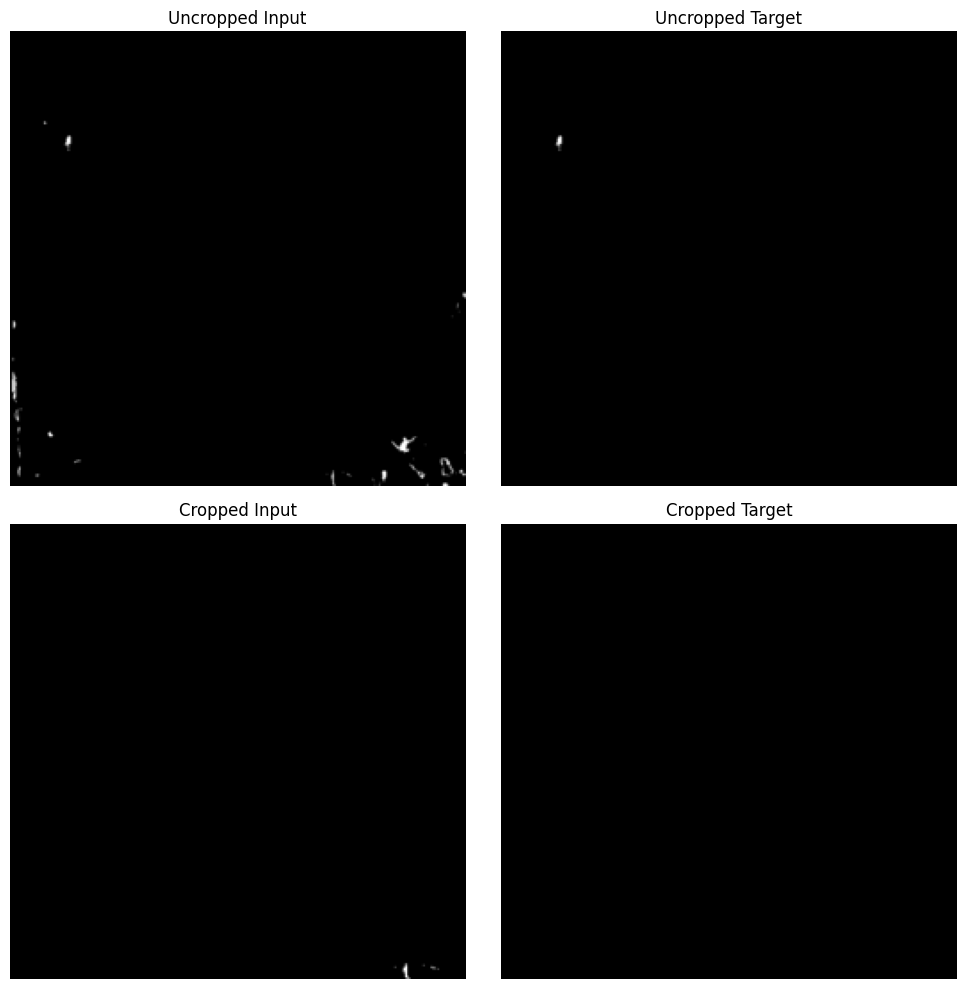

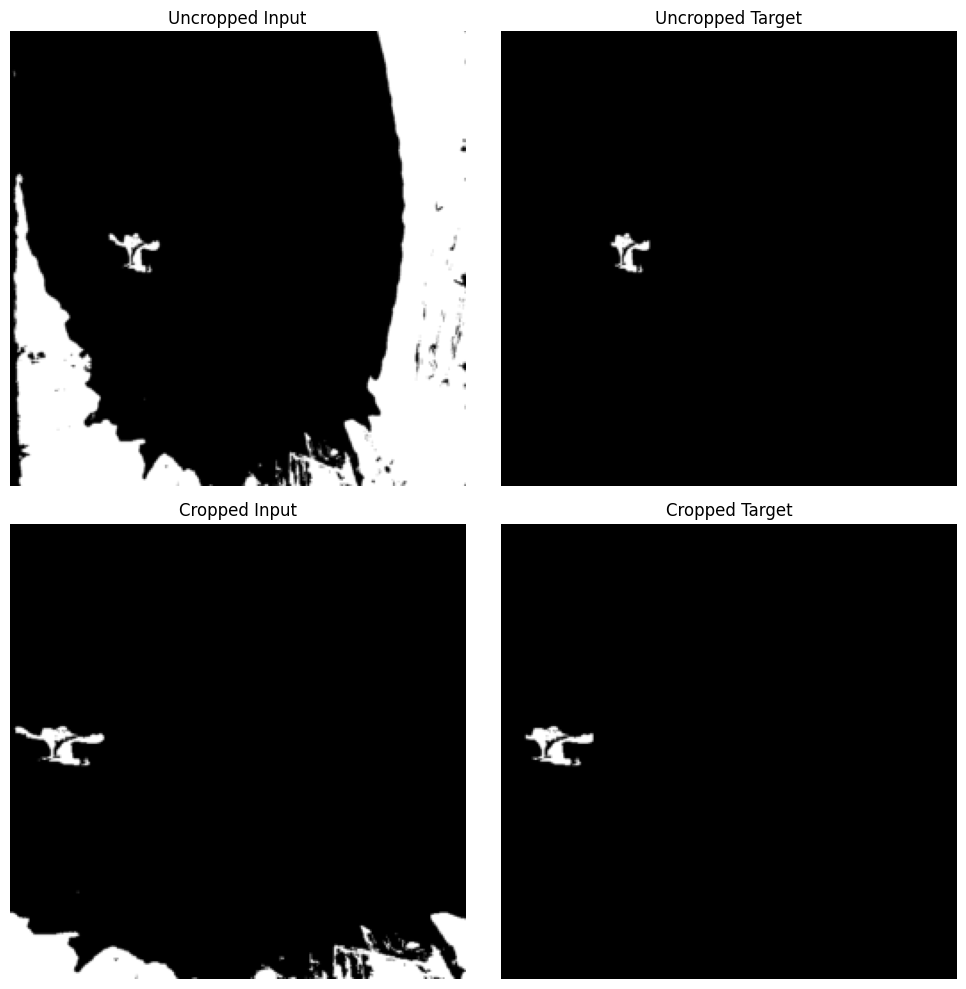

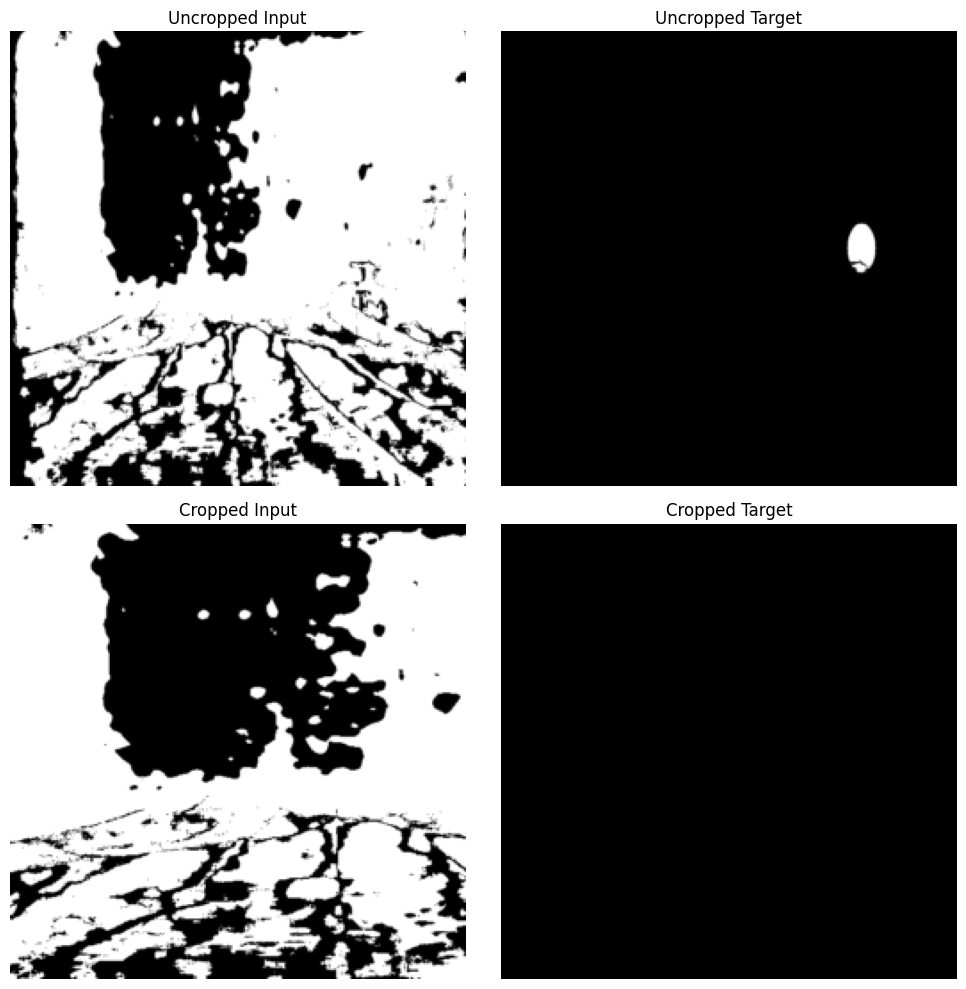

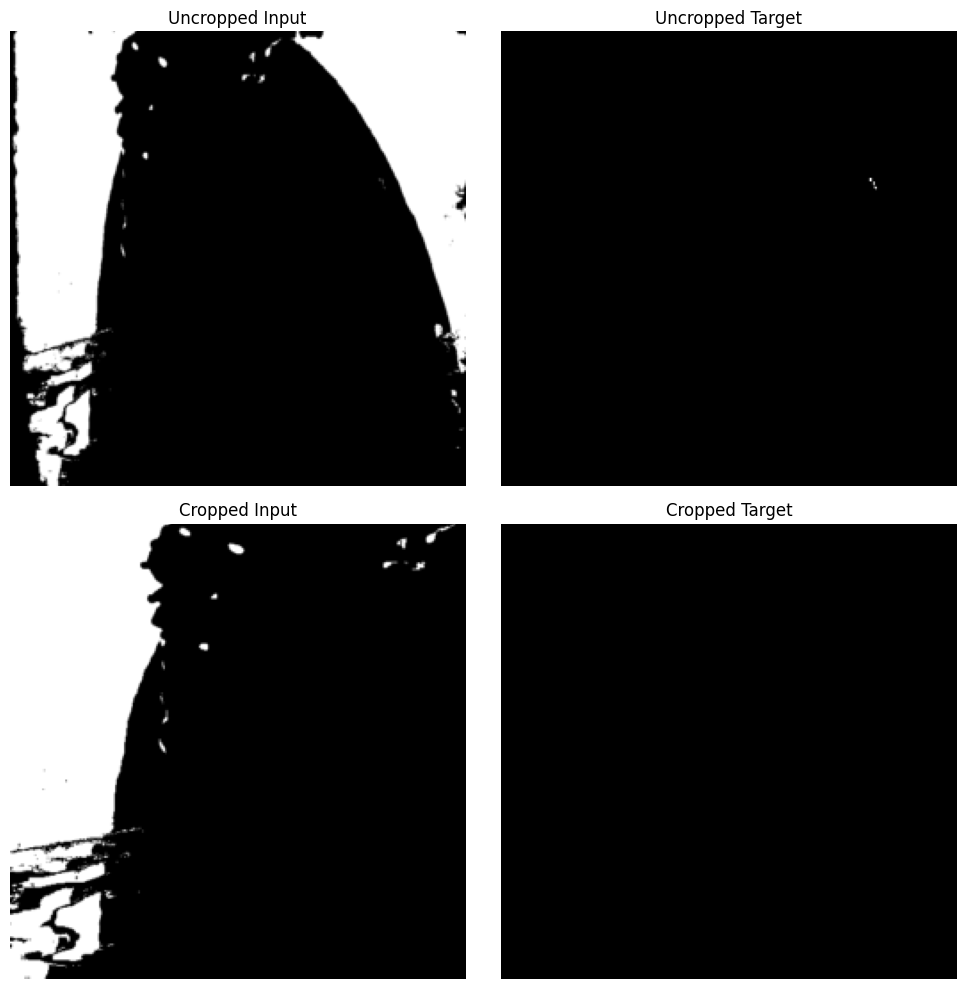

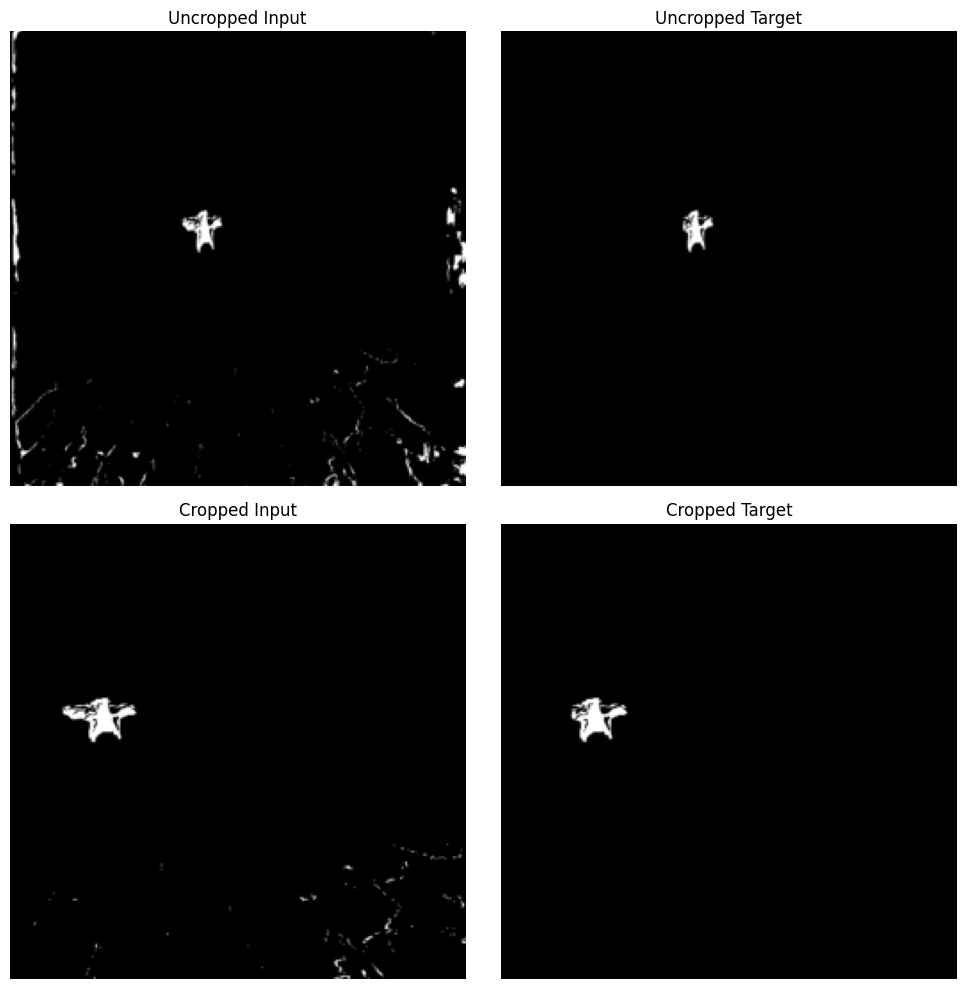

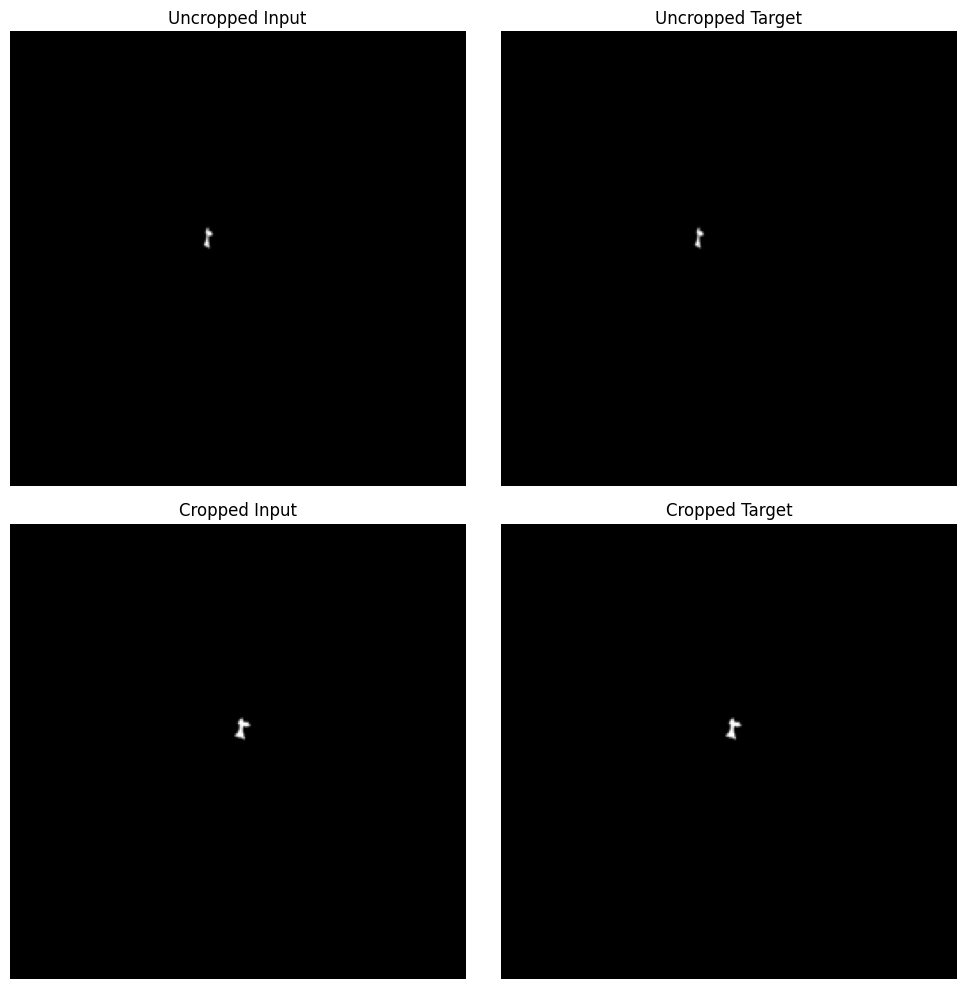

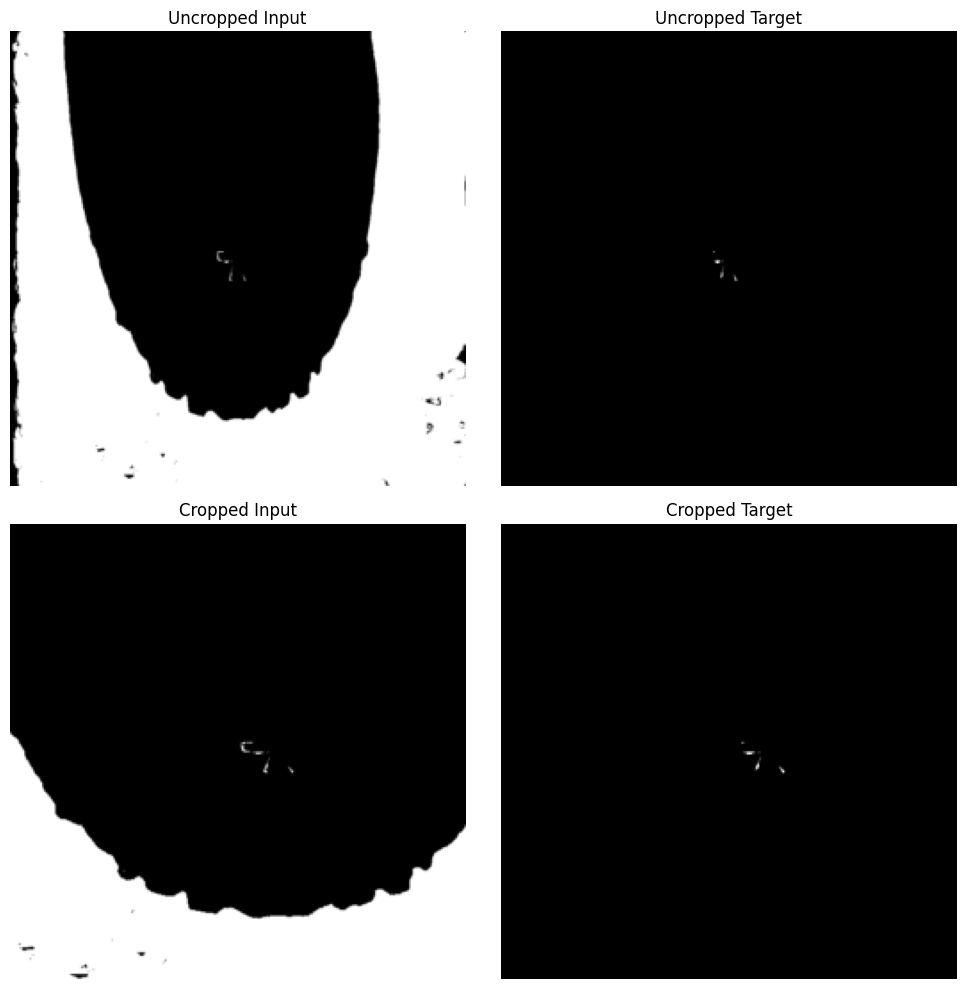

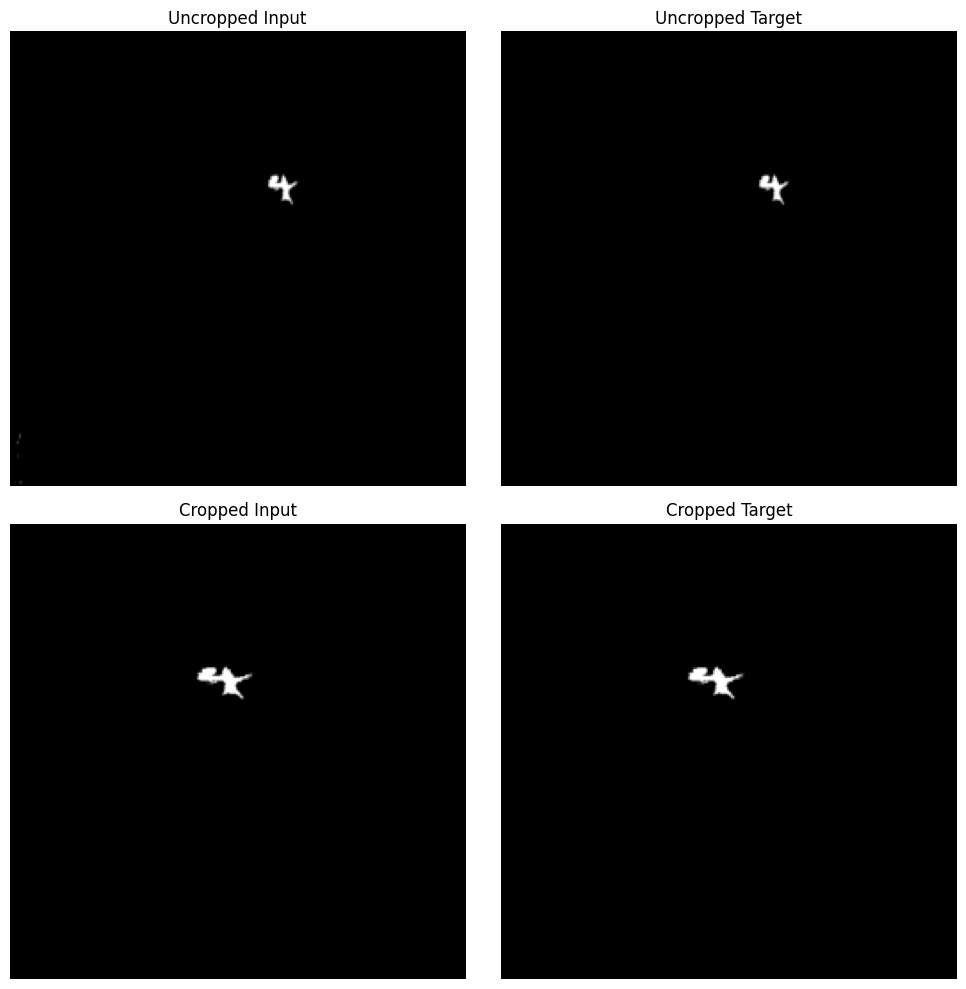

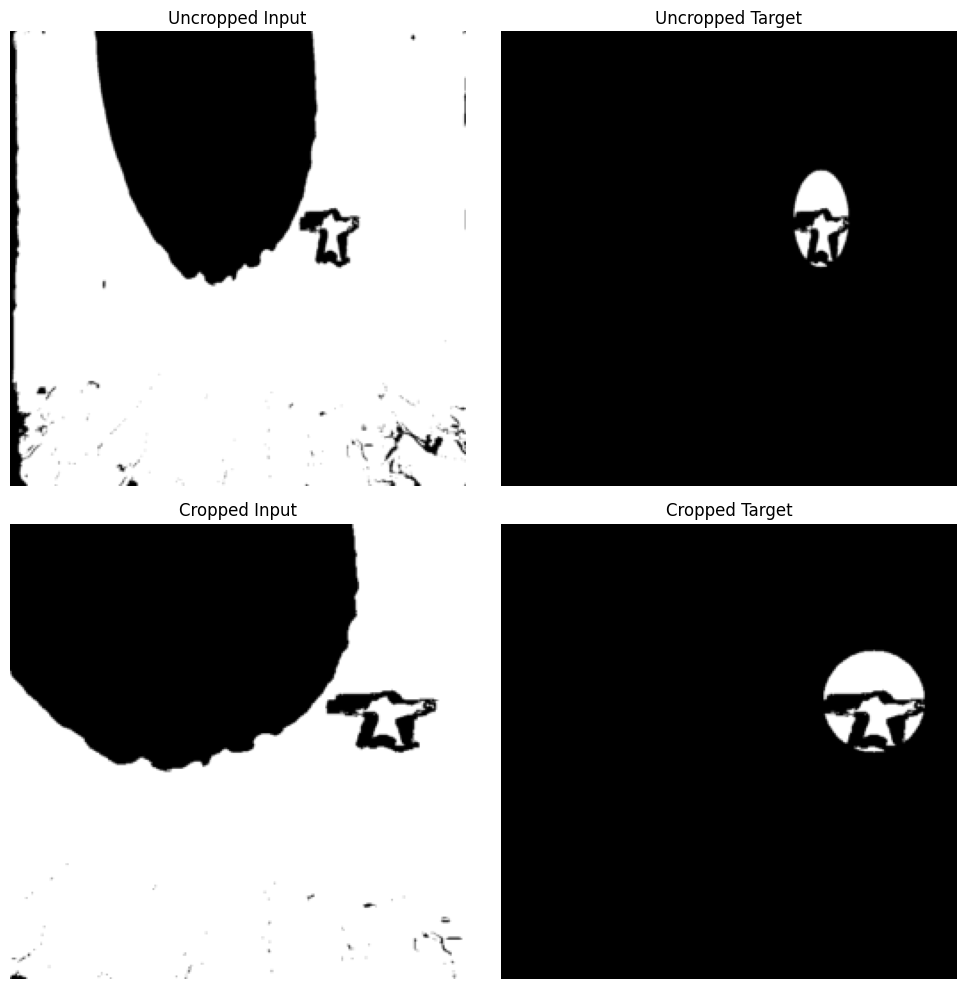

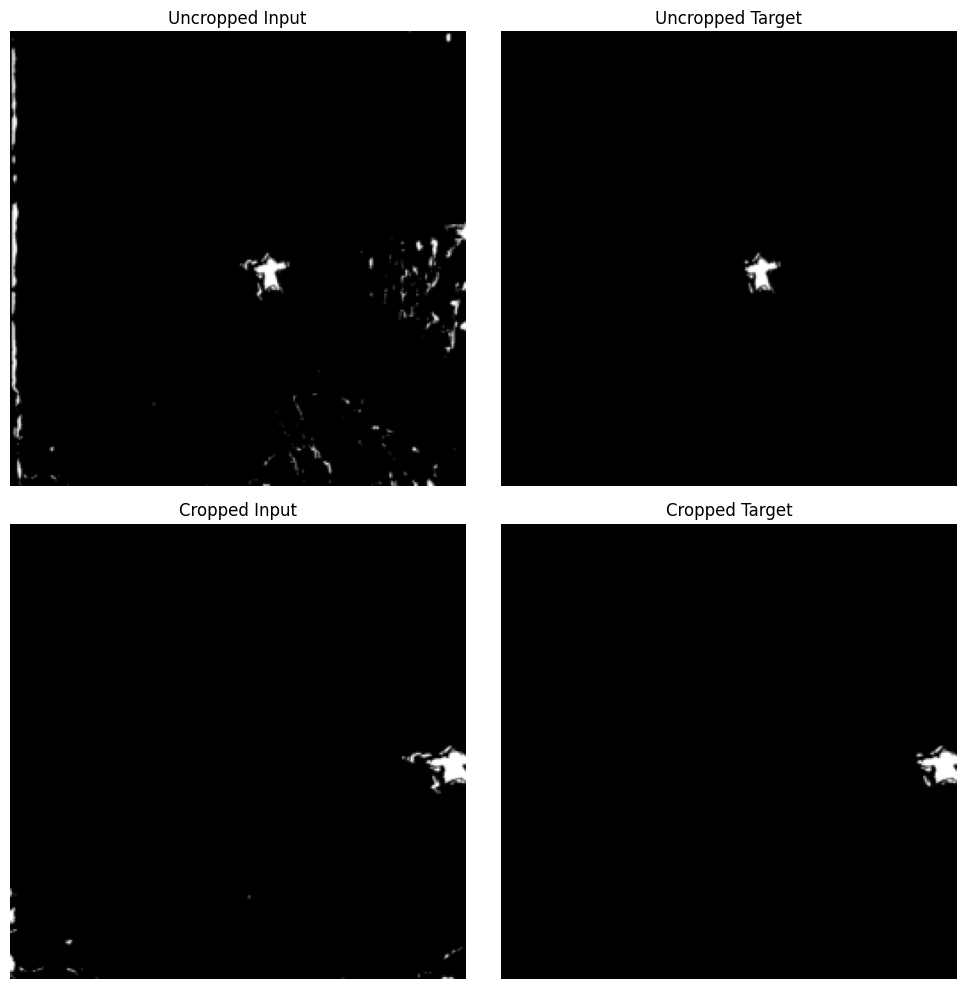

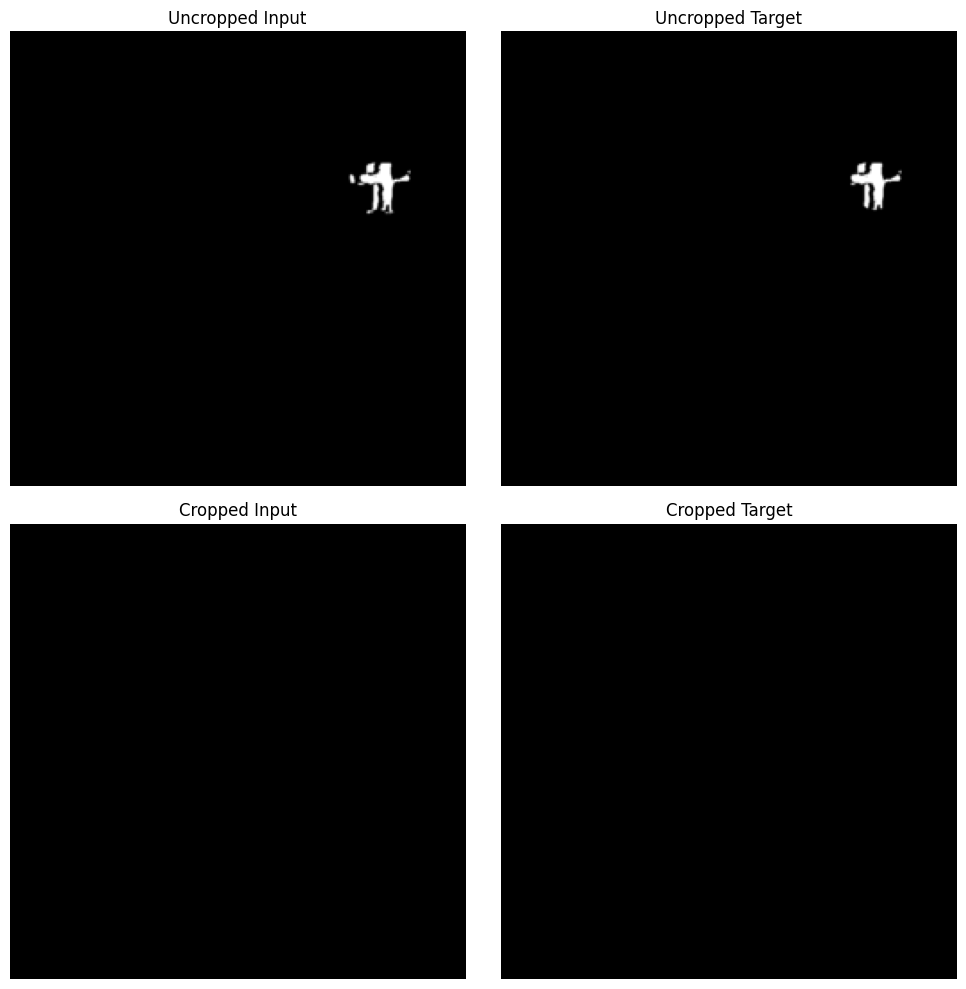

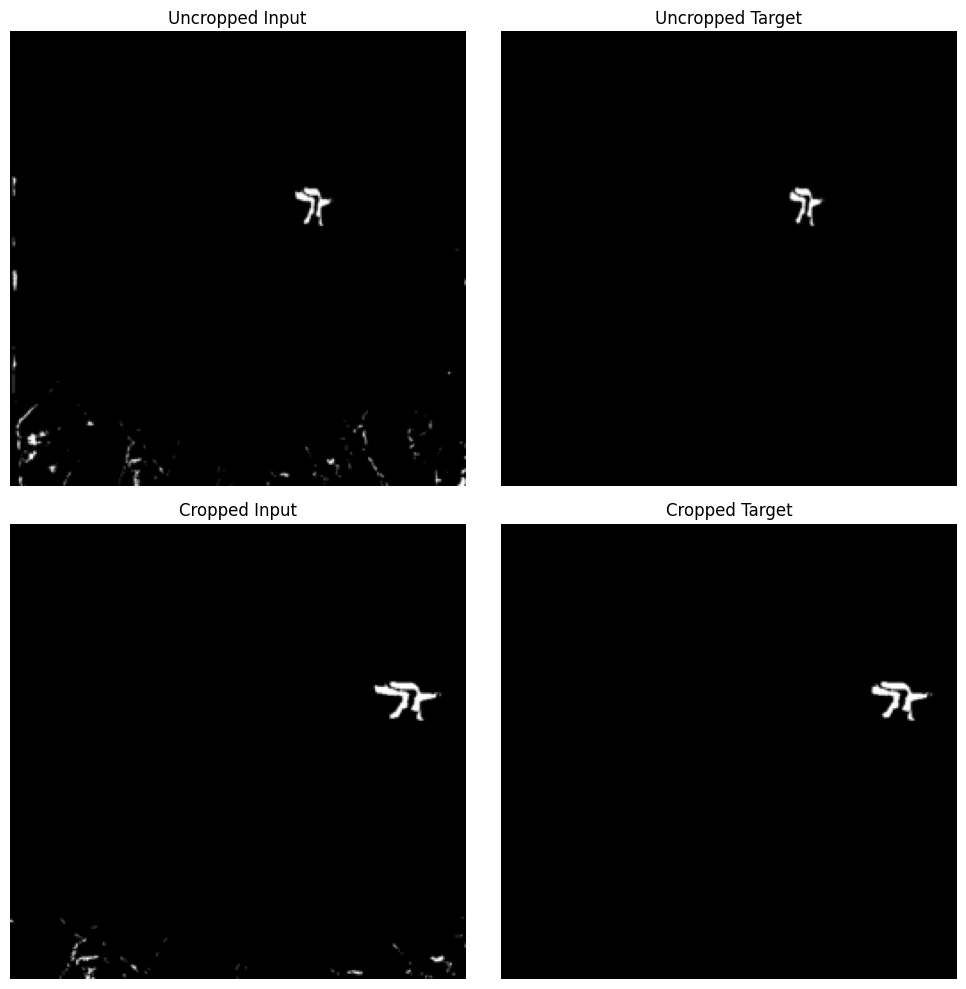

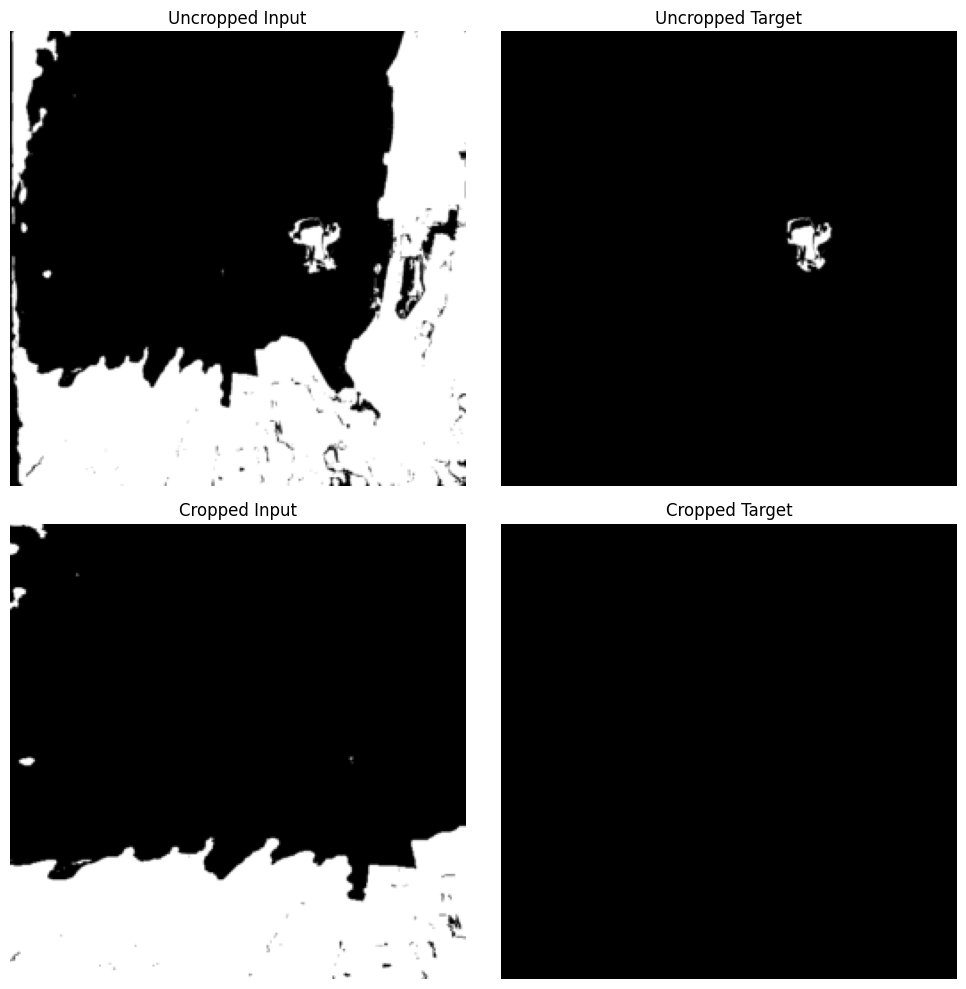

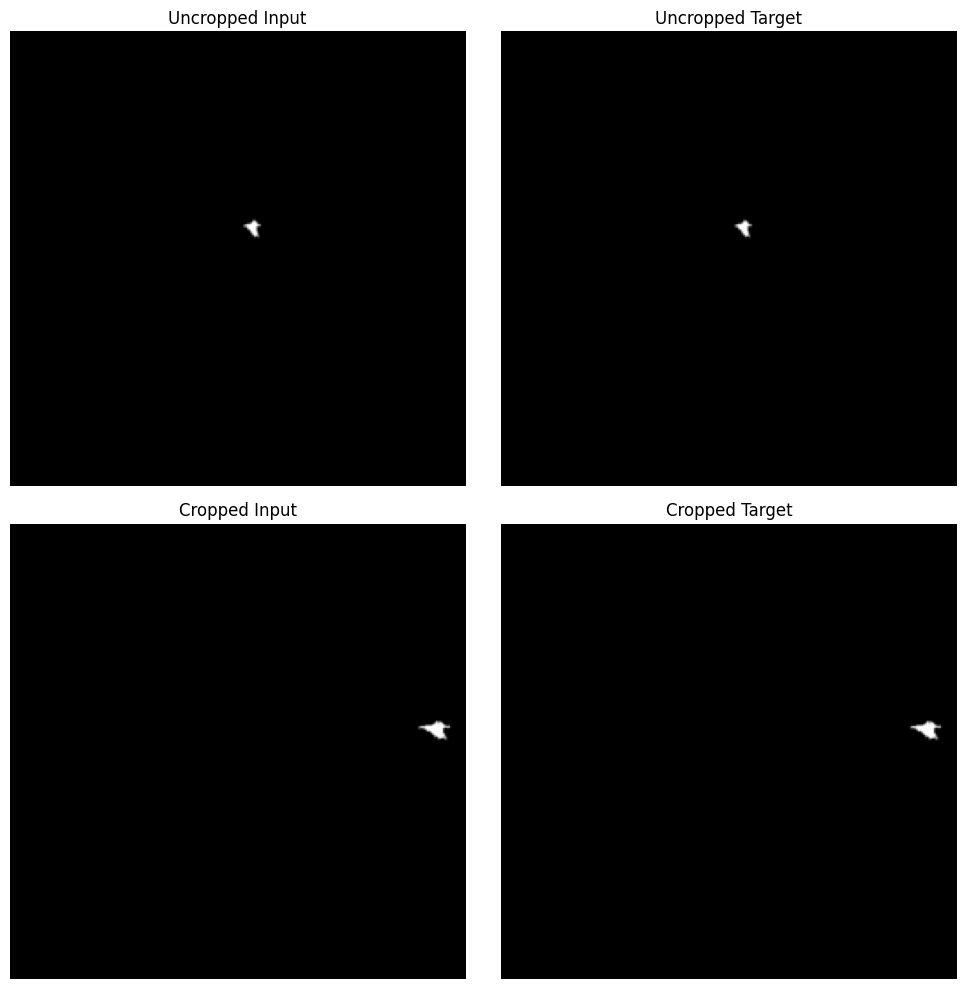

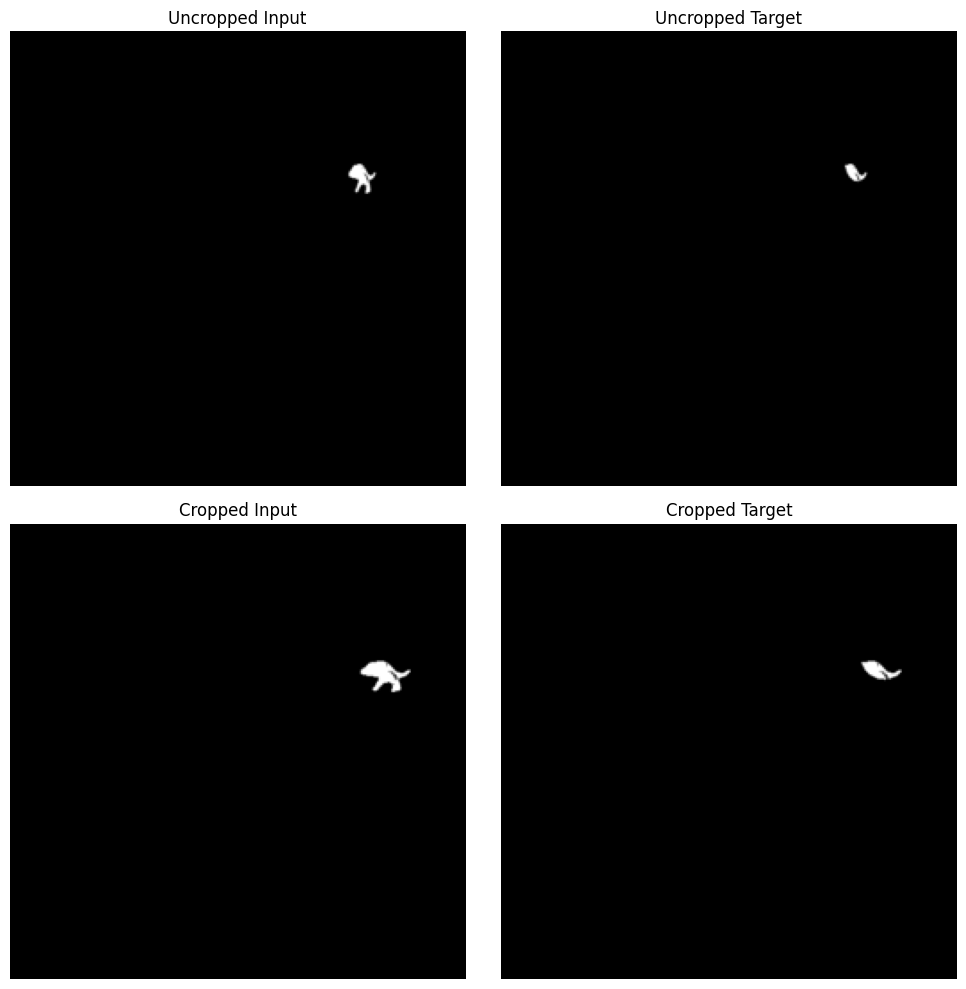

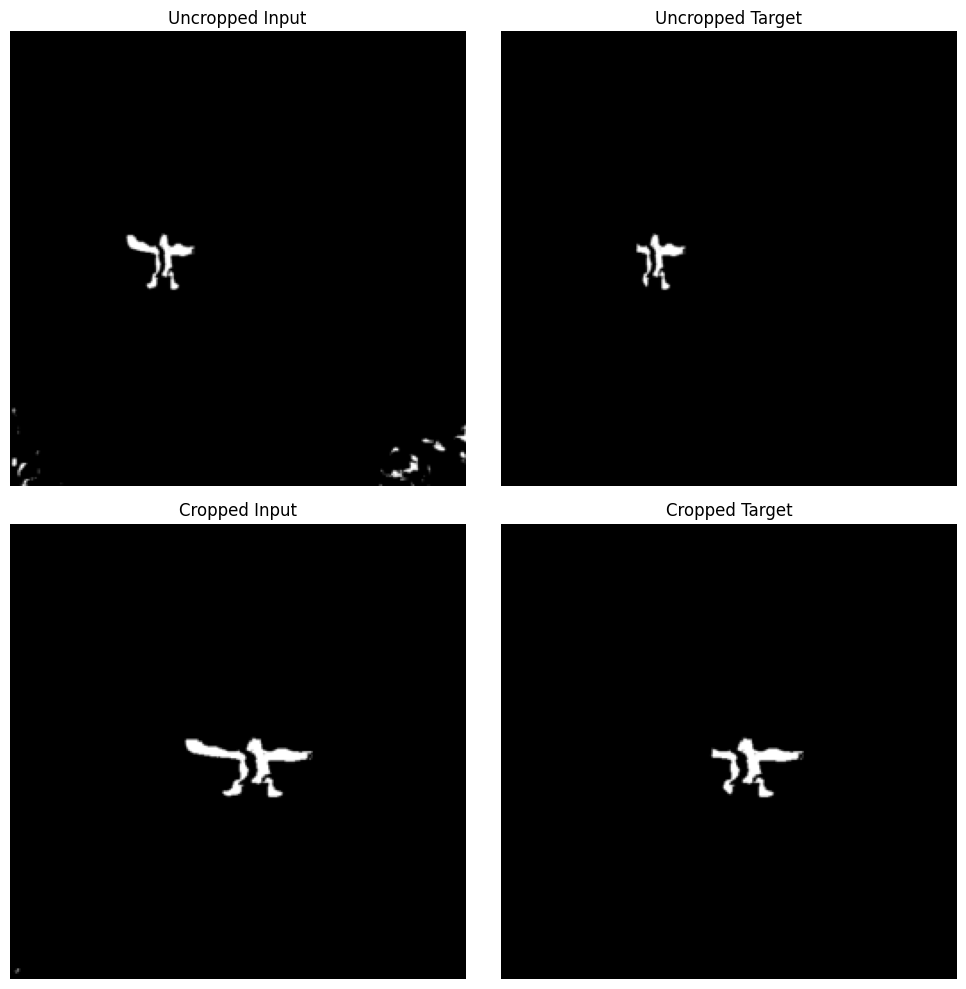

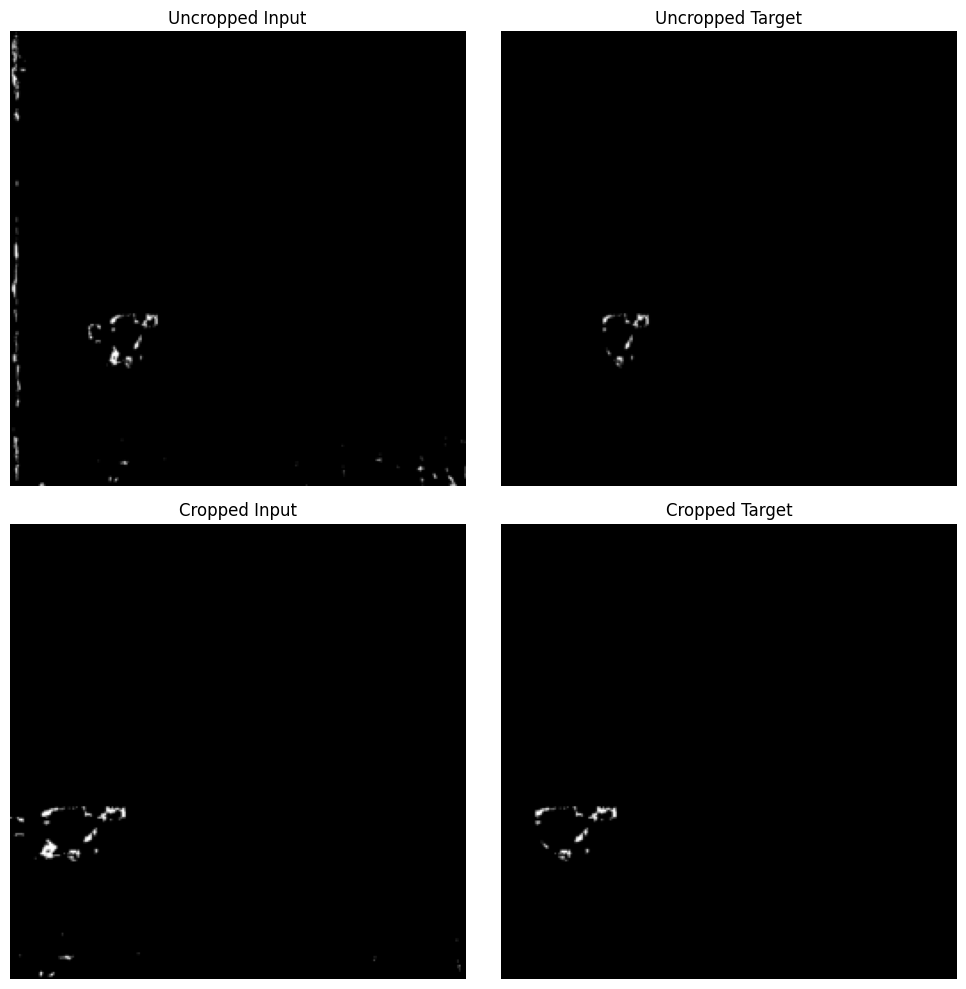

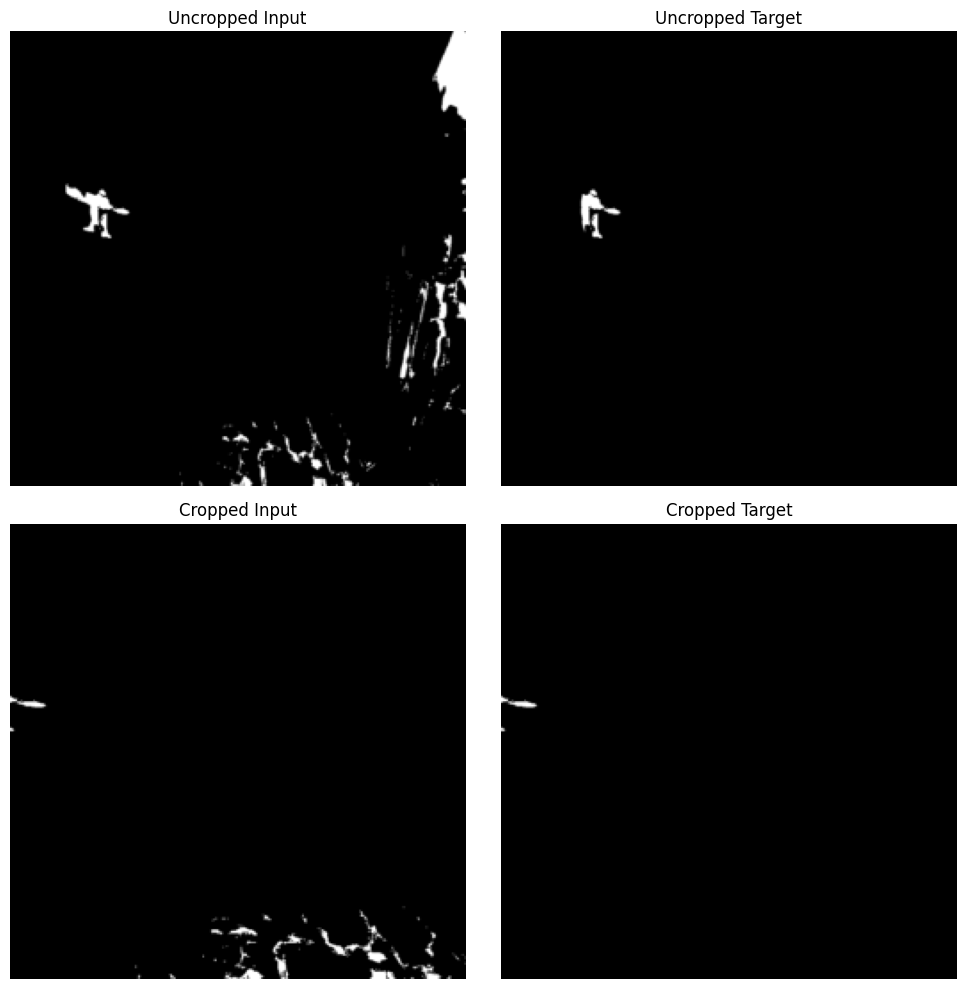

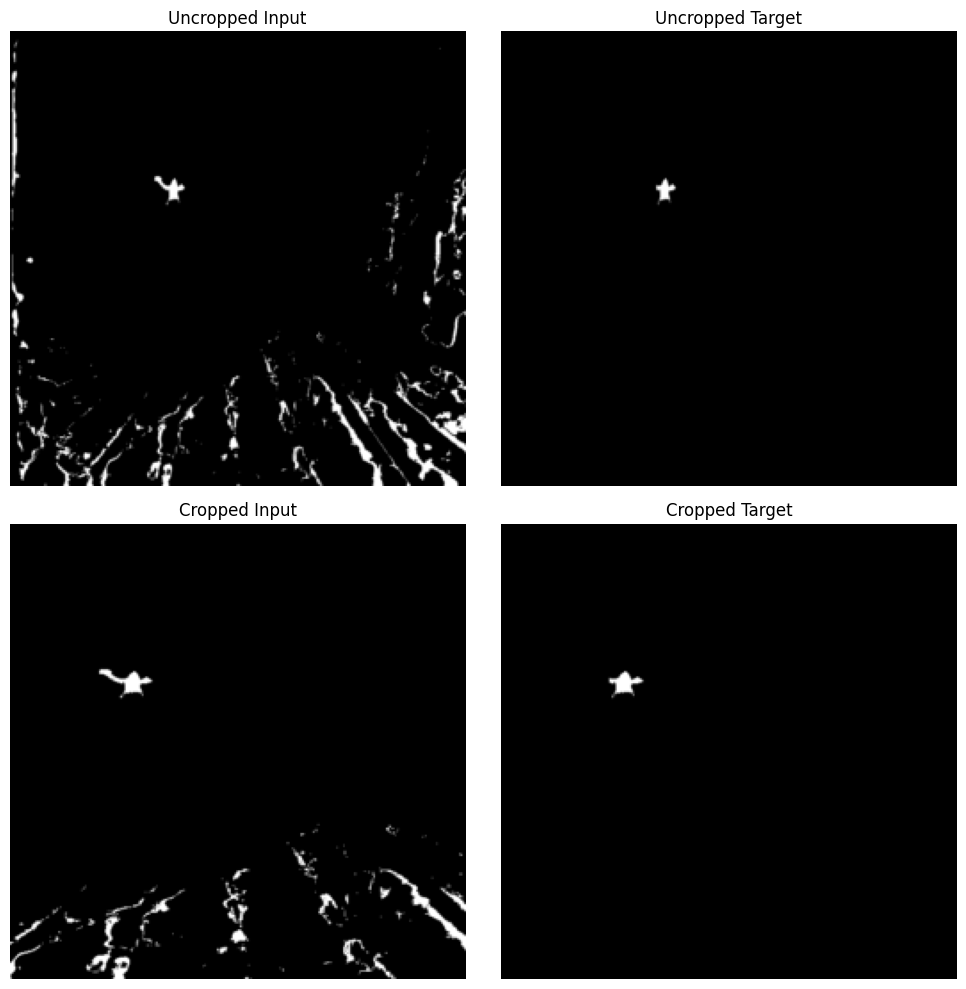

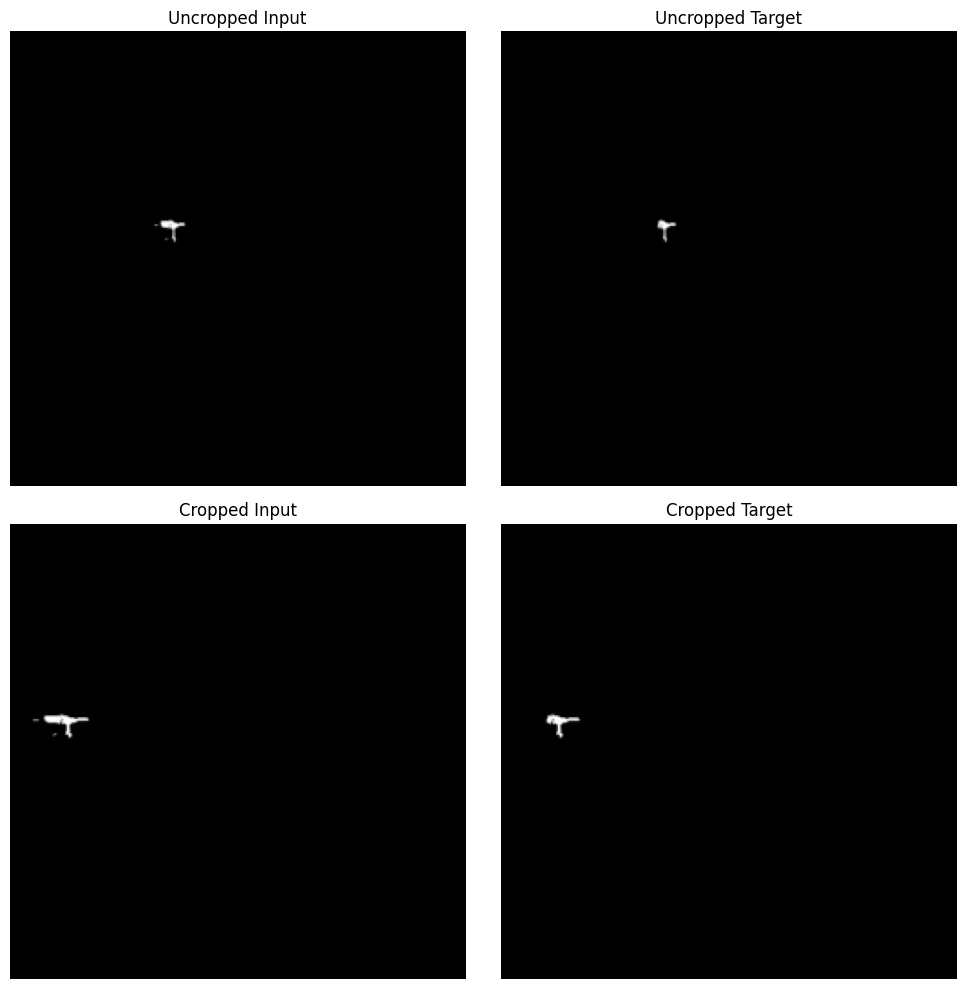

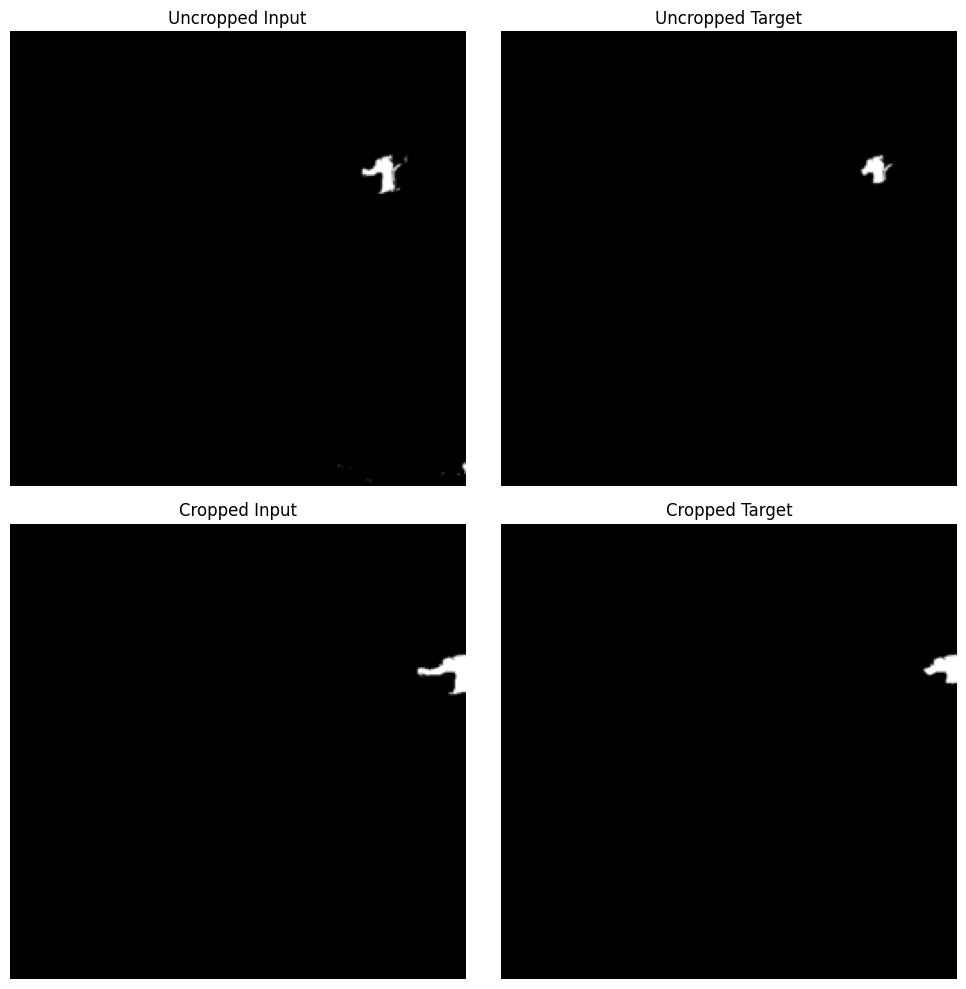

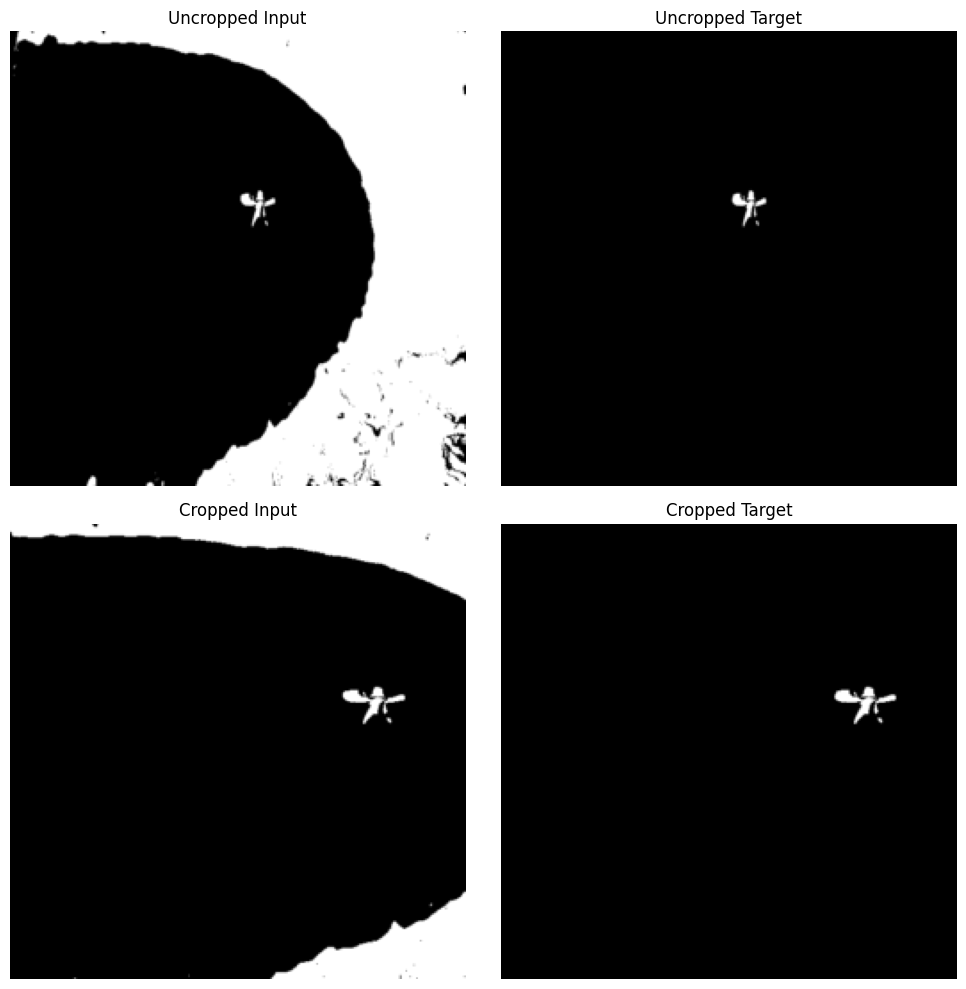

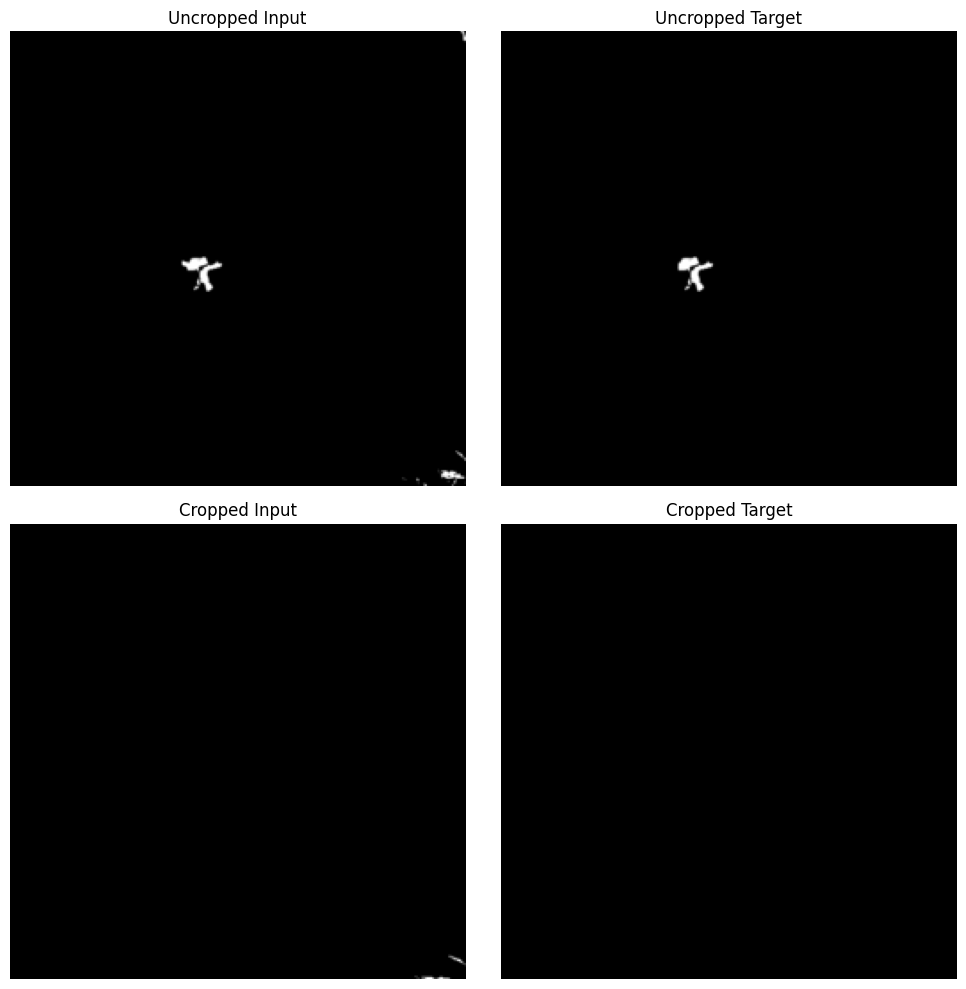

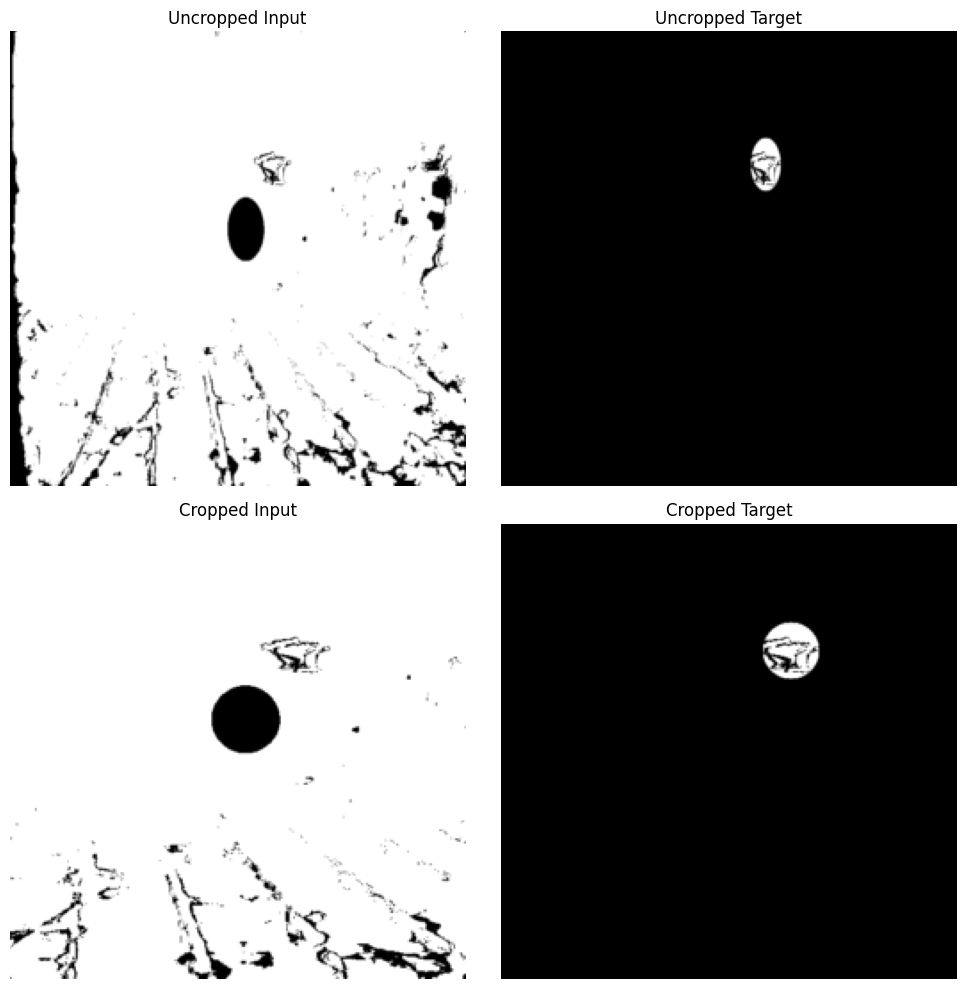

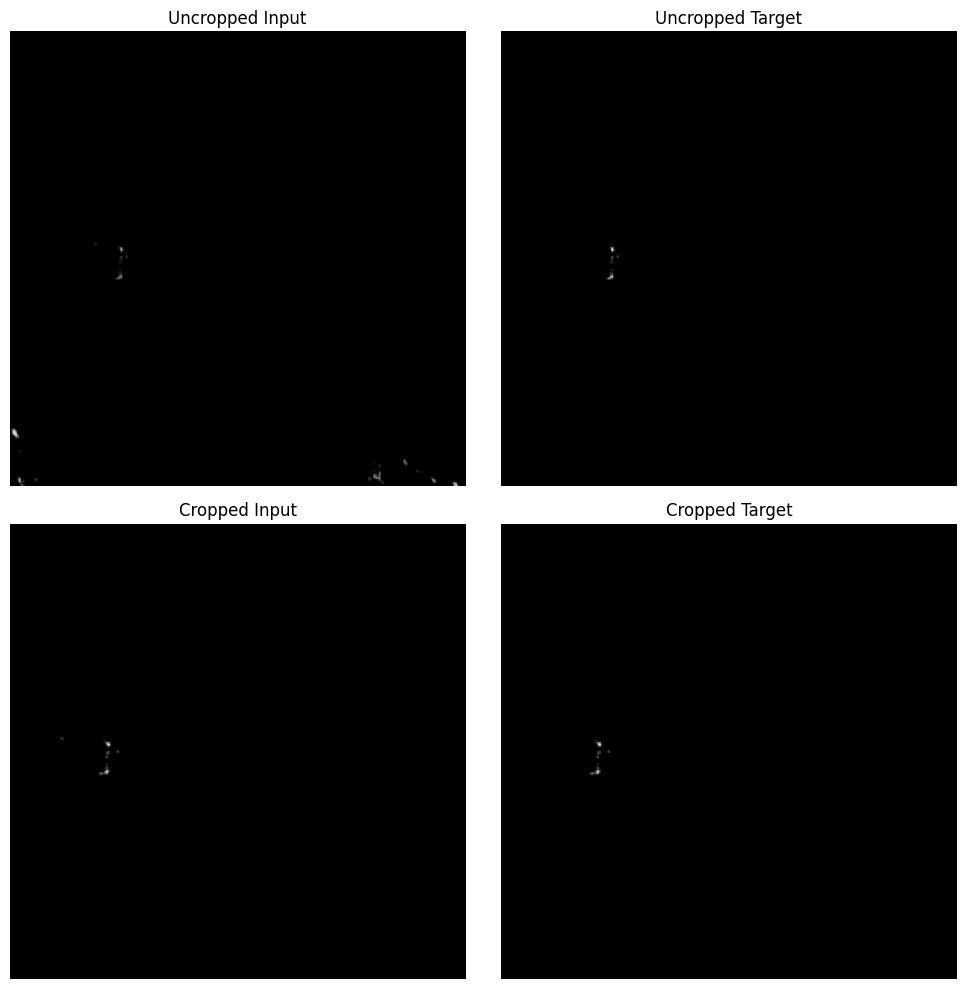

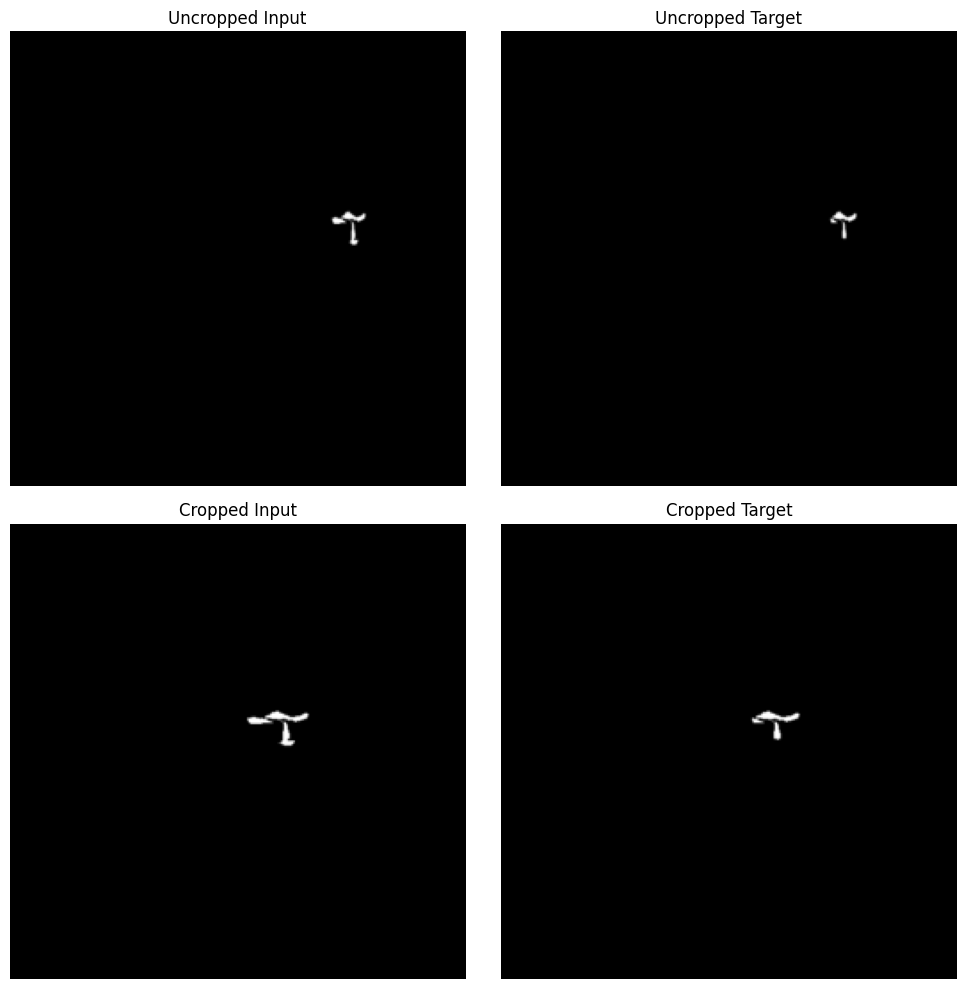

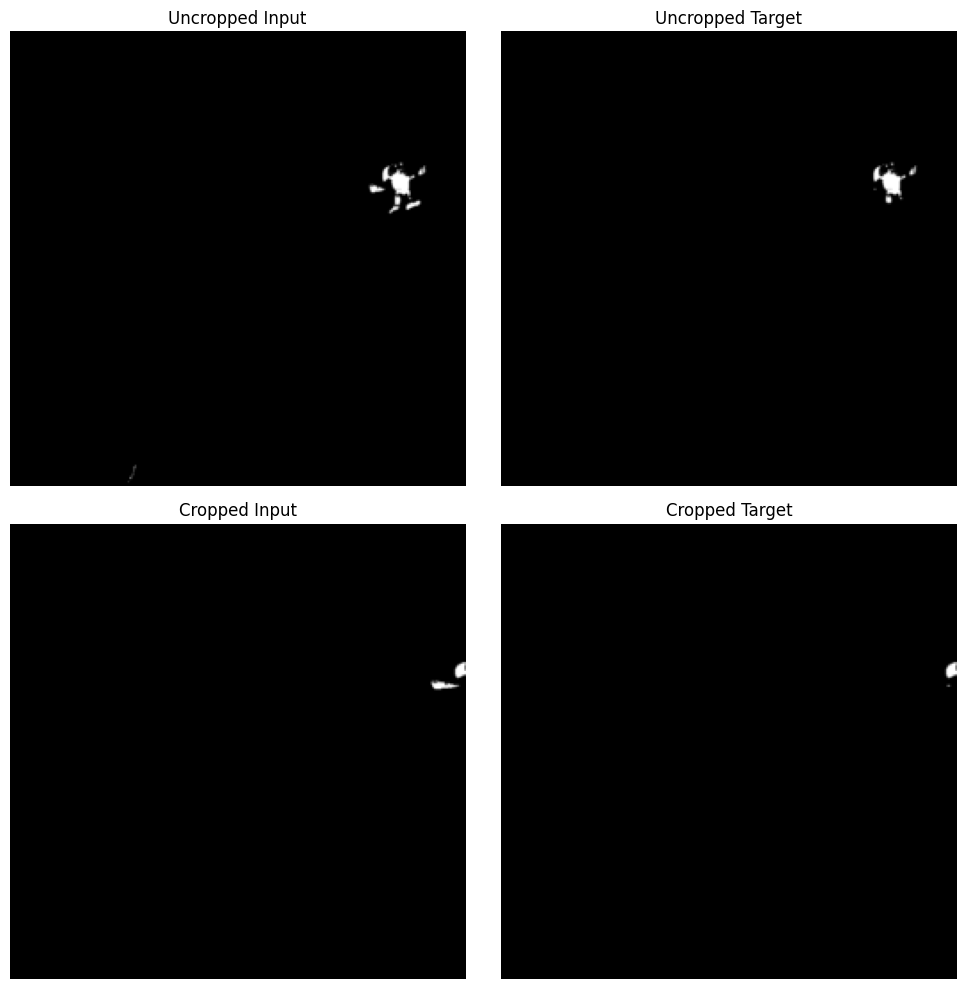

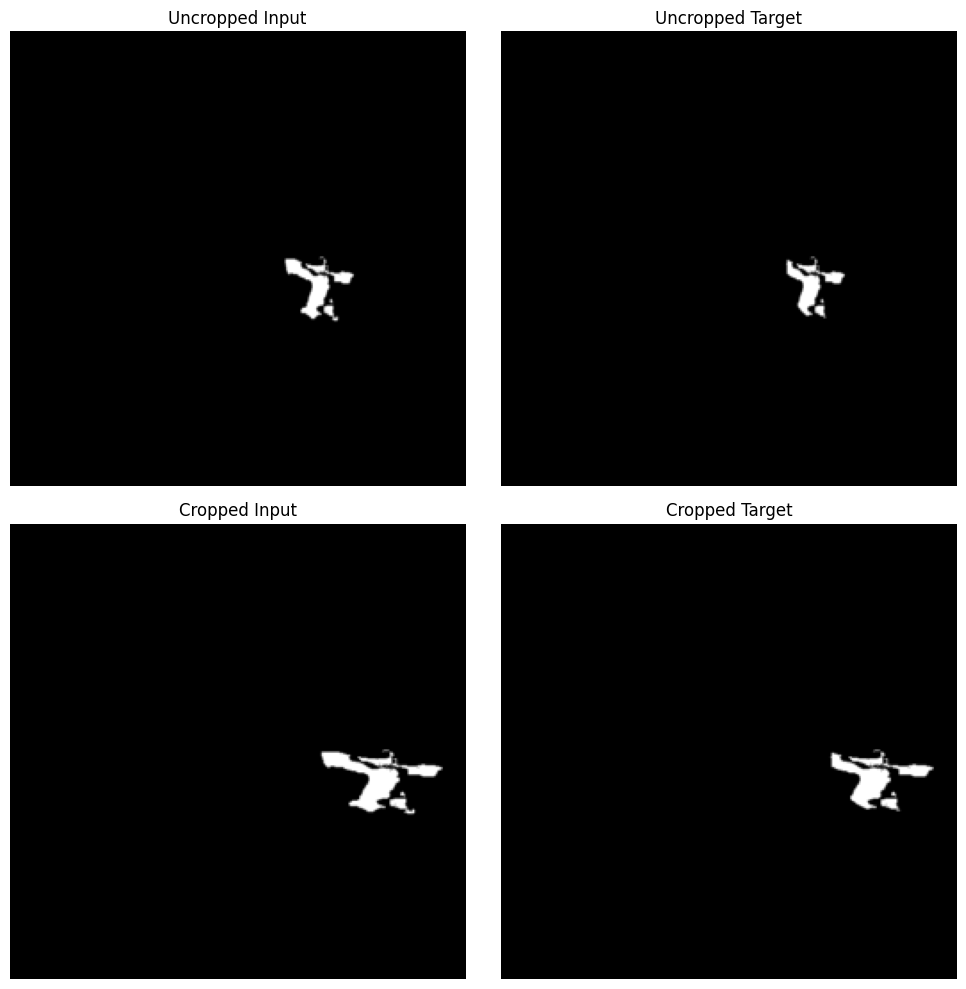

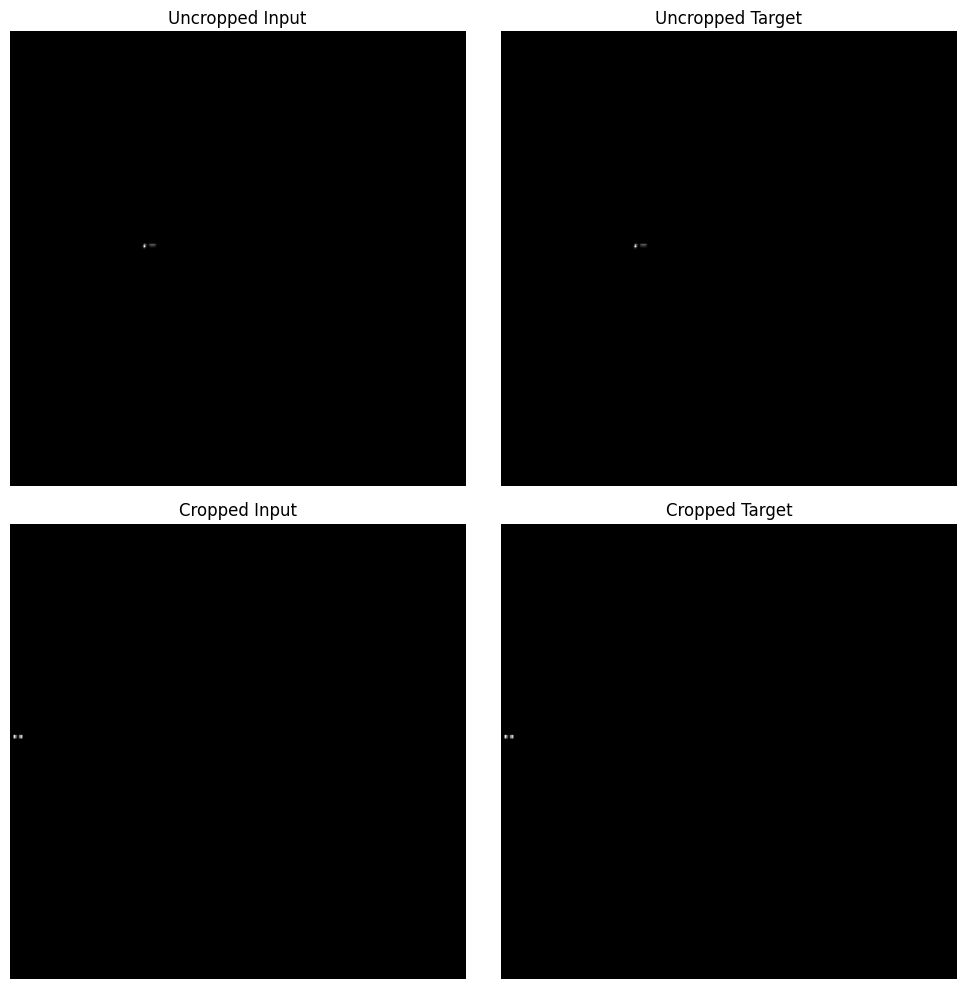

Exception ignored in: <function PluginV3.__del__ at 0x70aaa20c2280>
Traceback (most recent call last):
  File "/home/training/.local/lib/python3.9/site-packages/imageio/core/v3_plugin_api.py", line 370, in __del__
    self.close()
  File "/home/training/.local/lib/python3.9/site-packages/imageio/plugins/pillow.py", line 144, in close
    self._flush_writer()
  File "/home/training/.local/lib/python3.9/site-packages/imageio/plugins/pillow.py", line 476, in _flush_writer
    if len(self.images_to_write) == 0:
AttributeError: 'PillowPlugin' object has no attribute 'images_to_write'


KeyboardInterrupt: 

In [ ]:
# Compare original vs cropped data

class DualViewDataset(torch.utils.data.Dataset):
    def __init__(self, original_dataset, cropped_dataset):
        self.original = original_dataset
        self.cropped = cropped_dataset
        assert len(self.original) == len(self.cropped), "Datasets must be the same length"

    def __len__(self):
        return len(self.original)

    def __getitem__(self, idx):
        uncropped = self.original[idx]
        cropped = self.cropped[idx]
        return {
            'input_uncropped': uncropped['input'],
            'target_uncropped': uncropped['target'],
            'input_cropped': cropped['input'],
            'target_cropped': cropped['target']
        }

batch_size = 64

uncropped_dataset = VideoDataset(path_to_data, augmented=augmented, crop=False, num_vids=7, seq_length=seq_length, img_size=img_size)
cropped_dataset = VideoDataset(path_to_data, augmented=augmented, crop=True, num_vids=7, seq_length=seq_length, img_size=img_size)

dual_dataset = DualViewDataset(uncropped_dataset, cropped_dataset)

loader = DataLoader(dual_dataset, batch_size=batch_size, shuffle=True, num_workers=4)

for idx, batch in enumerate(loader):
    in_seq_uncropped, _ = batch['input_uncropped']
    out_seq_uncropped = batch['target_uncropped']

    in_seq_cropped, _ = batch['input_cropped']
    out_seq_cropped = batch['target_cropped']

    for b in range(batch_size):
        in_frame_uncropped = in_seq_uncropped[b, -1, 0]
        out_frame_uncropped = out_seq_uncropped[b, -1, 0]
        in_frame_cropped = in_seq_cropped[b, -1, 0]
        out_frame_cropped = out_seq_cropped[b, -1, 0]

        if out_frame_uncropped.sum() > 0 or out_frame_cropped.sum() > 0:
            fig, axs = plt.subplots(2, 2, figsize=(10, 10))

            axs[0, 0].imshow(in_frame_uncropped.cpu().numpy(), cmap='gray')
            axs[0, 0].set_title("Uncropped Input")

            axs[0, 1].imshow(out_frame_uncropped.cpu().numpy(), cmap='gray')
            axs[0, 1].set_title("Uncropped Target")

            axs[1, 0].imshow(in_frame_cropped.cpu().numpy(), cmap='gray')
            axs[1, 0].set_title("Cropped Input")

            axs[1, 1].imshow(out_frame_cropped.cpu().numpy(), cmap='gray')
            axs[1, 1].set_title("Cropped Target")

            for ax in axs.flatten():
                ax.axis('off')

            plt.tight_layout()
            plt.show()

            break  # Remove or modify as needed



#### Testing dataloader

100%|██████████| 7/7 [00:00<00:00, 52.14it/s]


Showing sample 0 with non-empty target


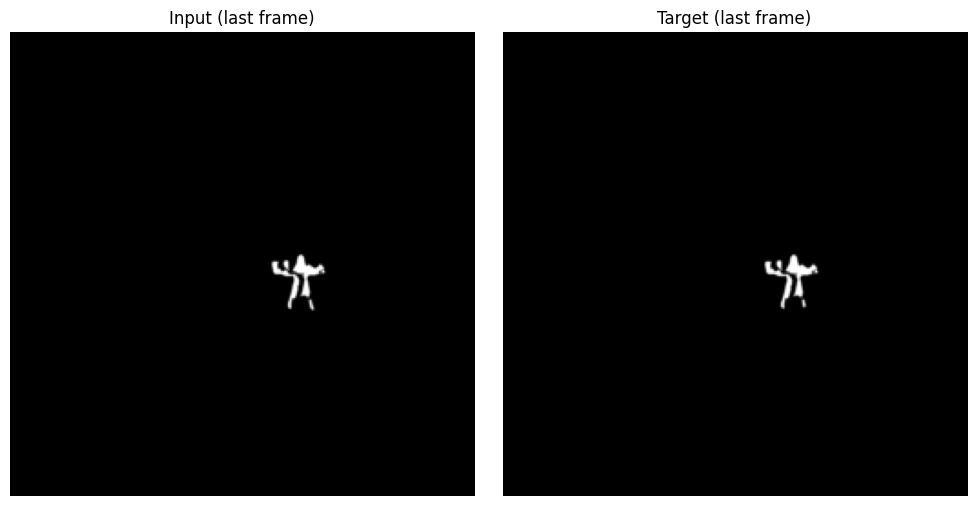

Showing sample 2 with non-empty target


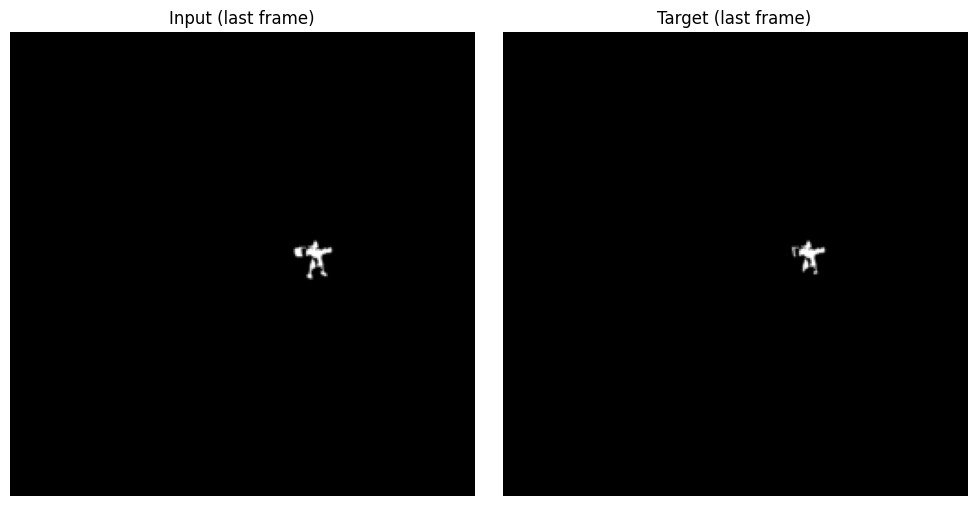

Showing sample 3 with non-empty target


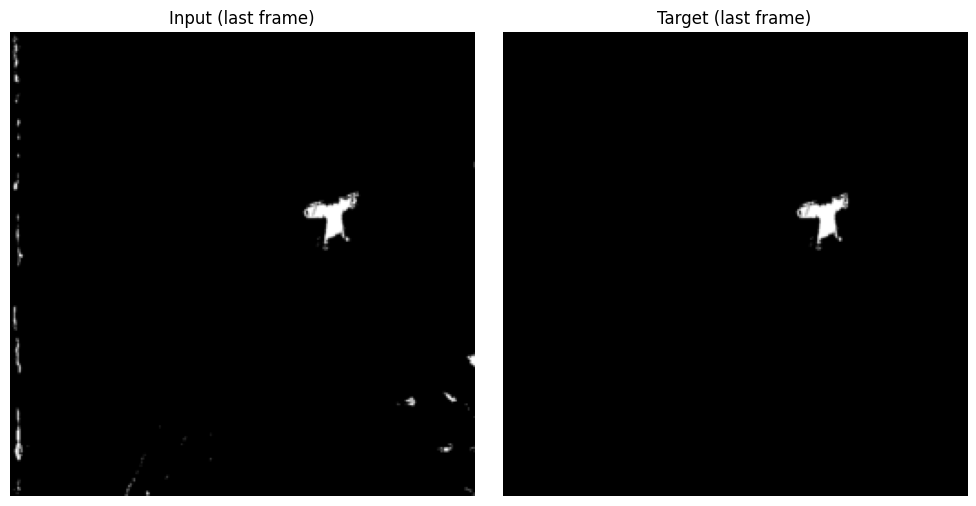

Showing sample 11 with non-empty target


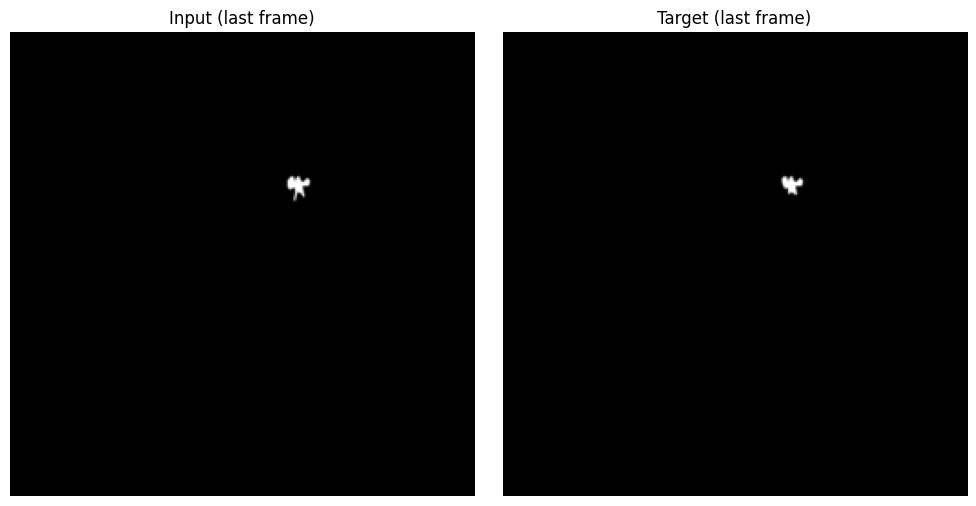

Showing sample 14 with non-empty target


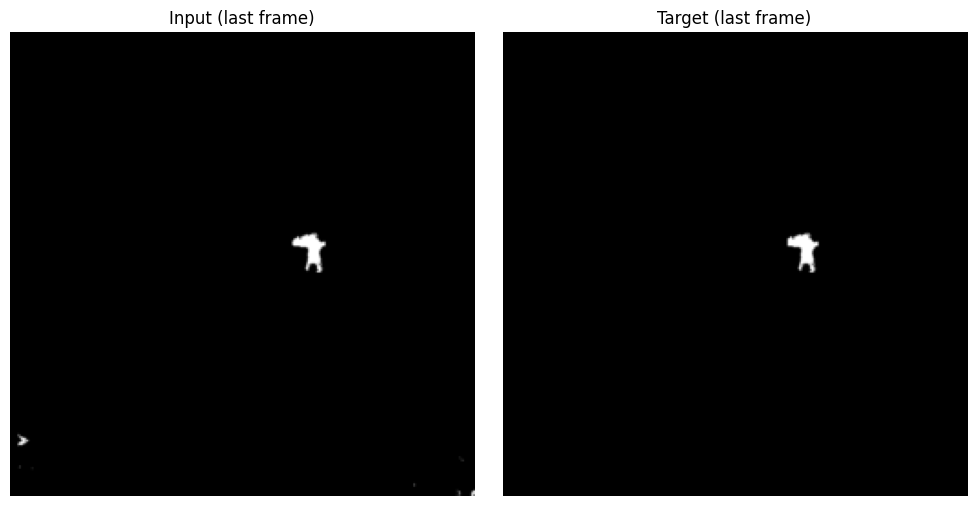

In [ ]:
batch_size = 64
dataset = VideoDataset(path_to_data, augmented=augmented, num_vids=7, seq_length=seq_length, img_size=img_size)
# dataset = VideoDataset(path_to_data, augmented=augmented,crop=True, num_vids=7, seq_length=seq_length, img_size=img_size)
# dataset = ConcatDataset([dataset, cropped_dataset])
loader = DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=4) #NOTE: num_workers is the number of extra processes running in parallel retrieving the data
counter = 0


for idx, datapoint in enumerate(loader):

    in_seq, _ = datapoint['input']
    out_seq = datapoint['target']

    in_frame = in_seq[0, -1, 0, :, :]   # Last input frame in sequence
    out_frame = out_seq[0, -1, 0, :, :] # Last target frame in sequence

    # Show only if mask has content
    if out_frame.sum() > 0:
        print(f"Showing sample {idx} with non-empty target")

        fig, axs = plt.subplots(1, 2, figsize=(10, 5))
        axs[0].imshow(in_frame.cpu().numpy(), cmap='gray')
        axs[0].set_title("Input (last frame)")

        axs[1].imshow(out_frame.cpu().numpy(), cmap='gray')
        axs[1].set_title("Target (last frame)")

        for ax in axs:
            ax.axis('off')
        plt.tight_layout()
        plt.show()

        counter += 1
        if counter >= 5:  # stop after showing 5
            break

    # found_one = False
    # features = datapoint['input']
    # labels = datapoint['target']
    # if counter > 1:
    #     break
    # counter += 1
    # for i in range(batch_size):
    #     image = features[0][i]
    #     if counter > 1502:
    #         found_one = True
    #         break
    #     counter += 1

    # if found_one:
    #     break

# counter
# len(datapoint)
# in_frame = datapoint['input'][0][0, -1, 0, :, :]
# out_frame = datapoint['target'][0, -1, 0, :, :]
# datapoint['input'][:, 0, :, :, :, 1]
# counter

In [ ]:
# Use transforms to resize images
# This is an example, but it must actually be performed before feeding image data to encoder
# For the augmented tensor the image is already resized inside the dataloader

sequence = next(iter(loader))
if augmented:
    input, target = sequence['input'], sequence['target']
    print(f'Tensor shape should be: [{batch_size, seq_length, 1, img_size, img_size, 14}] and is: {input.shape}')
else:

    features = sequence
    image = features['input'][0]
    input, target = features['input'], features['target']
    print(f'\nBatched image shape should be: [{batch_size, seq_length, 1, img_size, img_size}] and is: {image.shape}')



Batched image shape should be: [(1, 3, 1, 256, 256)] and is: torch.Size([1, 3, 1, 256, 256])


tensor(0.)


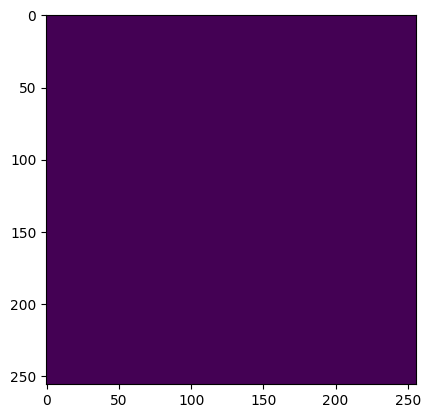

In [ ]:
print(in_frame.max())
plt.imshow(in_frame)

tensor(0.)


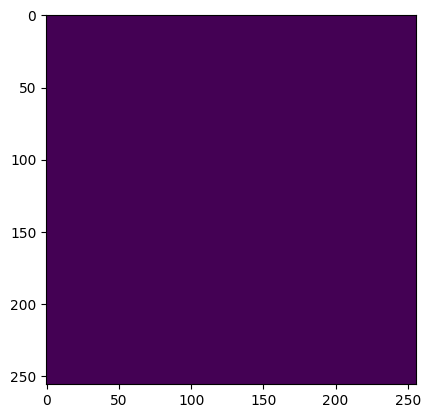

In [ ]:
print(out_frame.max())
plt.imshow(out_frame)

In [ ]:
features[0].shape
counter

1503

In [ ]:
pose = features[1]
pose[28]

tensor([-1.3603,  0.6753,  2.2040,  0.0300,  0.0131,  0.1257,  0.9915])

#### Testing interpolated twist

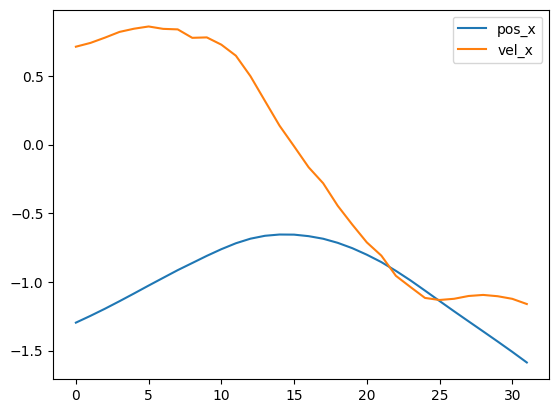

In [ ]:
features[1]
twist = features[2]

plt.plot(pose[:, 0])
plt.plot(twist[:, 0])
plt.legend(["pos_x", "vel_x"])
plt.show()

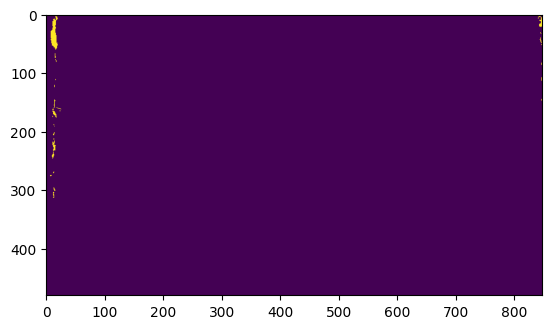

In [ ]:
image = features[0][28]
image.max()
plt.imshow(image)

torch.Size([32, 256, 256])